In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
sys.path.append('../')

from skyburst import Job
from skyburst.traces import philly
from skyburst.traces import philly_utils

In [2]:
jobs = philly.load_philly_traces('~/philly-traces/trace-data')
all_jobs = jobs

/tmp/ipykernel_7264/164241561.py:7: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  dates_df["dates"] = dates_df["dates"].astype("datetime64")


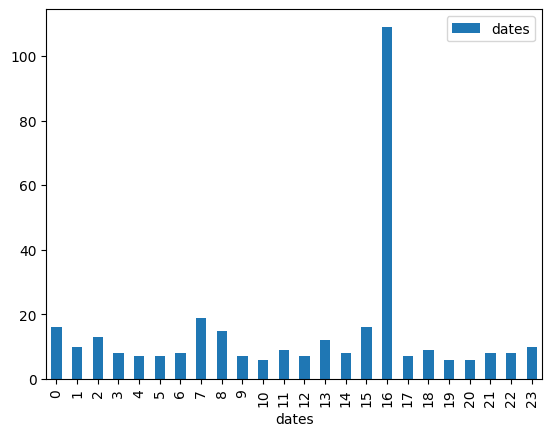

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


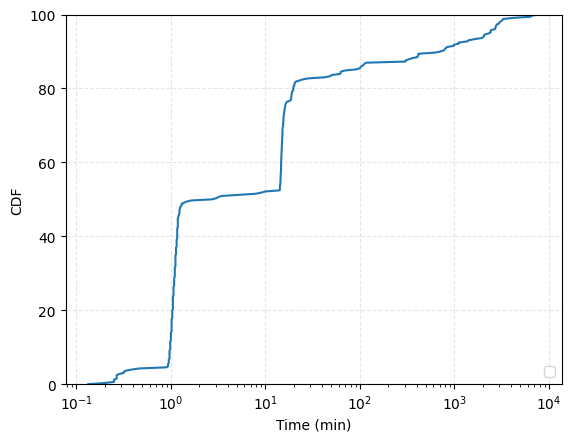

In [3]:
# Filter jobs based on Day
start_day = datetime.datetime(2017, 10, 7)
day_jobs = [j for j in jobs if (j._submitted_time - start_day).days ==0 and j._run_time is not None and j.status == 'Pass']
single_day_jobs = day_jobs
dates = [j._submitted_time for j in day_jobs]
dates_df = pd.DataFrame (dates, columns = ['dates'])
dates_df["dates"] = dates_df["dates"].astype("datetime64")
dates_df.groupby([dates_df["dates"].dt.hour]).count().plot(kind="bar")
plt.show()

# Plotting Job CDF for Phillly Trace
dayrun_times = []
for j in day_jobs:
    if j._run_time is not None and j.status=='Pass':
        dayrun_times.append(j._run_time)
dayrun_times.sort()
#print(run_times)

x, y = philly_utils.get_cdf(dayrun_times)
plt.plot(x, y)
plt.legend(loc='lower right')
plt.xscale('log')
#plt.xlim(10 ** -1, 8* 10 ** 4)
plt.ylim(0, 100)
plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.grid(alpha=.3, linestyle='--')
plt.show()

In [13]:
from math import floor, ceil

# Time Quantum Converter
# 6 seconds per time quantum (1 hr/600)
# Now at 6 minutes per time quantum
TIME_QUANTUM = 1/10.0

# Maximum job time in hours
CLIP_MAX_TIME = 1e9

# Deadline Multiplier d_t = a_t + K * r_t
DEADLINE_CONSTANT = 1.25

# Returns the deadline of a job.
# For continuous simulator
def deadline_mult_fn(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT):
    waiting_time = (deadline_mult - 1)*run_time
    waiting_time = max(1/12.0, waiting_time)
    return arrival_time + waiting_time + run_time

def deadline_ljw(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT, run_thres=8.0):
    if run_time < run_thres:
        return arrival_time + run_time
    waiting_time = (deadline_mult - 1)*run_time
    return arrival_time + waiting_time + run_time

def deadline_infinite_fn(arrival_time, run_time):
    return 1e12

def deadline_zero_fn(arrival_time, run_time):
    return arrival_time + run_time

# Returns the deadline of a job for discrete simulator
def deadline_discrete_fn(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT):
    quantized_arrival_time = ceil(arrival_time/TIME_QUANTUM)*TIME_QUANTUM
    quantized_gap = ceil(deadline_mult*run_time/TIME_QUANTUM)*TIME_QUANTUM
    return quantized_arrival_time + quantized_gap

def no_deadline_discrete_fn(arrival_time, run_time):
    quantized_arrival_time = ceil(arrival_time/TIME_QUANTUM)*TIME_QUANTUM
    quantized_gap = ceil(run_time/TIME_QUANTUM)*TIME_QUANTUM
    return quantized_arrival_time + quantized_gap

# Returns the total cost of a job.
def gpu_cost_fn(resources: dict, run_time: float):
    return resources['GPUs'] * run_time

def time_thres_fn(job, run_thres):
    return job.runtime >= run_thres

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

# Num nodes
NUM_NODES = 16

def preprocess_jobs(jobs: List['JobTrace'], deadline_fn= deadline_discrete_fn , cost_fn=gpu_cost_fn, clip_time: float = CLIP_MAX_TIME):
    """Converts a list of jobs into (arrival_time, run_time, deadline, resources, cost).
    """
    jobs = jobs.copy()
    # Remove invalid jobs (jobs that have not finished and jobs that failed/killed early)
    jobs = [j for j in jobs if j._run_time is not None and j.status=='Pass']
    jobs.sort(key=lambda j: j._submitted_time)
    
    if not clip_time:
        clip_time = 1e9
    
    # Arrival time for jobs
    start_time = jobs[0]._submitted_time
    arrival_times = [(j._submitted_time- start_time).total_seconds()/3600.0 for j in jobs]
    
    # Run time for jobs
    run_times = []
    for j in jobs:
        # Clip the maximum run time for jobs to simplify simulation.
        run_time_hr = j._run_time/60.0
        if run_time_hr > clip_time:
            run_times.append(clip_time)
        else:
            run_times.append(run_time_hr)
    
    deadlines = [deadline_fn(arrival, run) for arrival, run in zip(arrival_times, run_times)]
    
    # Get GPU resources
    resources = []
    for j in jobs:
        detail_dict = j.attempts[-1]['detail']
        gpu_count = sum([len(node_dict['gpus']) for node_dict in detail_dict])
        resources.append({'GPUs': gpu_count})
    
    costs = [cost_fn(res, run) for res, run in zip(resources, run_times)]
    
    return [Job(idx, arr, run, dead, res, cost) \
            for idx, (arr, run, dead, res, cost) in \
            enumerate(list(zip(arrival_times, run_times, deadlines, resources, costs)))]

jobs_subset = jobs #jobs#single_day_jobs  #jobs[10550:10650]#single_day_jobs[100:200]  #jobs[90000:90500] #jobs[50000:55000]
jobs_proc = preprocess_jobs(jobs_subset, deadline_fn=lambda x,y: deadline_discrete_fn(x,y,1.25))

In [14]:
class Node(object):
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.gpu_dict = {}
        for idx in range(self.num_gpus):
            self.gpu_dict[idx] = None
    
    def free_gpus(self):
        return len([v for v in self.gpu_dict.values() if not isinstance(v, Job)])
    
    def try_fit(self, cur_timestamp, job, num_gpus=None):
        gpu_list = []
        if num_gpus==None:
            num_gpus = job.resources['GPUs']

        if num_gpus > self.free_gpus():
            return False, gpu_list

        counter =0
        for idx in range(self.num_gpus):
            gpu_val = self.gpu_dict[idx]
            if not isinstance(gpu_val, Job):
                self.gpu_dict[idx] = job
                gpu_list.append(idx)
                counter +=1
            if counter >= num_gpus:
                break
        return True, gpu_list
    
    def __repr__(self):
        return f'{self.gpu_dict}'        
        

class Cluster(object):
    
    def __init__(self, num_nodes, num_gpus_per_node, preempt=False, reserve=False):
        self.num_nodes = num_nodes
        self.num_gpus_per_node = num_gpus_per_node
        self.nodes = [Node(num_gpus_per_node) for _ in range(num_nodes)]
        self.preempt = preempt
        self.reserve = reserve
        self.active_jobs = {}
        
    
    # Fits on the first node if possible, return False otherwise
    def try_fit(self, cur_timestamp, job):
        num_gpus = job.resources['GPUs']
        if num_gpus <= self.num_gpus_per_node:
            for n_idx, n in enumerate(self.nodes):
                can_fit_in_node, gpu_list = n.try_fit(cur_timestamp, job)
                # Stuff job in free space
                if can_fit_in_node:
                    job.start = cur_timestamp
                    job.allocated_gpus[n_idx] = gpu_list
                    self.active_jobs[job.idx] = job
                    return True, []
            
            # If job cannot be stuffed into free space, attempt to preempt jobs
            return False, []
        else:
            # Gang Schedule (capture on all GPU(s))
            free_gpus_n = [n.free_gpus() for n in self.nodes]
            if num_gpus > sum(free_gpus_n):
                return False, []
            self.active_jobs[job.idx] = job
            left_over_gpus = num_gpus%NUM_GPUS_PER_NODE
            for n_idx, n in enumerate(self.nodes):
                _, gpu_list = n.try_fit(cur_timestamp, job, num_gpus=min(free_gpus_n[n_idx], num_gpus))
                num_gpus -= free_gpus_n[n_idx]
                job.allocated_gpus[n_idx] = gpu_list
                if num_gpus <=0:
                    break
            job.start = cur_timestamp
            return True, []
    
    def is_full(self):
        for n in self.nodes:
            for gpu_idx in n.gpu_dict:
                if not n.gpu_dict[gpu_idx]:
                    return False
        return True
    
    def try_fit_v2(self, cur_timestamp, job):
        num_gpus = job.resources['GPUs']
                        
        # Generate Plan
        free_gpus = [n.free_gpus() for n in self.nodes]
        free_plus_preempted_gpus = free_gpus.copy()
        node_idx_to_pre_job = {}
        
        # Logic to pre-empt GPU(s). Generates candidates jobs to be pre-empted on the cluster.
        preemptible_jobs = {}
        if self.preempt:
            for j_idx, j in self.active_jobs.items():
                latest_possible_j_time =  j.deadline - j.runtime
                # Filter for jobs that will not exceed deadline (if preempted)
                if latest_possible_j_time > cur_timestamp:
                    if j.cost + j.opp_cost < job.cost):
                    preemptible_jobs[j_idx] = j
            for pre_j in preemptible_jobs.values():
                pre_j_matrix = pre_j.allocated_gpus
                for n_idx, gpu_list in pre_j_matrix.items():
                    free_plus_preempted_gpus[n_idx] += len(gpu_list)
                    if n_idx not in node_idx_to_pre_job:
                        node_idx_to_pre_job[n_idx] = [pre_j]
                    else:
                        node_idx_to_pre_job[n_idx] += [pre_j]
        
        # No hope of fitting onto cluster :(
        if num_gpus > sum(free_plus_preempted_gpus):
            return False, []
        
        # Generate job GPU demands
        if num_gpus > self.num_gpus_per_node:
            # Multinode case, i.e. 26 GPUs, 8 GPU/node cluster -> job_gpu_demands = [8,8,8,2]
            job_gpu_demands = [self.num_gpus_per_node]*int(num_gpus/self.num_gpus_per_node)
            if num_gpus%self.num_gpus_per_node:
                job_gpu_demands.append(num_gpus%self.num_gpus_per_node)
        else:
            job_gpu_demands = [num_gpus]

        # Generate Plans - which nodes to place job on and which jobs to preempt
        # Maps node idx to gpu_demand
        node_idx_taken = {}
        # Maps node idx to (gpu_demand, list of job idx of preempted jobs on that node)
        preempted_idx_taken = {}
        remove_idx = []
        
        # Go through free space only first
        for list_idx, gpu_demand in enumerate(job_gpu_demands):
            for n_idx, n in enumerate(self.nodes):
                if free_gpus[n_idx] >= gpu_demand and n_idx not in node_idx_taken:
                    node_idx_taken[n_idx] = gpu_demand
                    remove_idx.append(list_idx)
                    break

        for index in sorted(remove_idx, reverse=True):
            del job_gpu_demands[index]
        
        # Go through free + premptible space
        if job_gpu_demands and self.preempt:
            remove_idx = []
            for list_idx, gpu_demand in enumerate(job_gpu_demands):
                for n_idx, n in enumerate(self.nodes):
                    if free_plus_preempted_gpus[n_idx] >= gpu_demand and \
                    free_plus_preempted_gpus[n_idx] != free_gpus[n_idx] and \
                    n_idx not in node_idx_taken and n_idx not in preempted_idx_taken:
                        gpus_freed = free_gpus[n_idx]
                        preempt_jobs = node_idx_to_pre_job[n_idx]
                        # Sort by cheapest jobs to preempt on the node
                        preempt_jobs.sort(key = lambda x: x.cost)
                        remove_job_list = []
                        for j in preempt_jobs:
                            remove_job_list.append(j)
                            gpus_freed += j.num_gpus
                            if gpus_freed >= gpu_demand:
                                break
                                
                        # Not worth prempting if the sum of preempted jobs cost more :(
#                         if sum([j.cost for j in remove_job_list]) > job.cost:
#                             continue
                        
                        assert len(remove_job_list) >=1
                        preempted_idx_taken[n_idx] = (gpu_demand, [j.idx for j in remove_job_list])
                        remove_idx.append(list_idx)
                        break
            #import pdb; pdb.set_trace()
            for index in sorted(remove_idx, reverse=True):
                del job_gpu_demands[index]
            
        # If there are still demands that cannot be satisifed via free and preempted jobs,
        # it cannot be scheduled on the cluster.
        if job_gpu_demands:
            return False, []
        
        # Execute plan
        remove_jobs = []
        # Populate nodes that enough free gpus
        for n_idx, gpu_demand in node_idx_taken.items():
            gpu_list = self.try_fit_node(self.nodes[n_idx], cur_timestamp, job, num_gpus=gpu_demand)
            job.allocated_gpus[n_idx] = gpu_list
        
        # Poppulate nodes that need jobs preempted first
        buffer = []
        for n_idx, job_tuple in preempted_idx_taken.items():
            gpu_demand, preempted_job_idxs = job_tuple
            for job_idx in preempted_job_idxs:
                if job_idx in buffer:
                    continue
                remove_jobs.append(self.preempt_job(job_idx))
                buffer.append(job_idx)
            gpu_list = self.try_fit_node(self.nodes[n_idx], cur_timestamp, job, num_gpus=gpu_demand)
            job.allocated_gpus[n_idx] = gpu_list
        
        job.start = cur_timestamp
        self.active_jobs[job.idx] = job
        
        return True, remove_jobs
    
    def try_fit_node(self, node, cur_timestamp, job, num_gpus=None):
        gpu_list = []
        if num_gpus==None:
            num_gpus = job.resources['GPUs']

        if num_gpus > node.free_gpus():
            raise ValueError("Should not go here in try_fit_node!")

        counter =0
        for idx in range(node.num_gpus):
            gpu_val = node.gpu_dict[idx]
            if not isinstance(gpu_val, Job):
                node.gpu_dict[idx] = job
                gpu_list.append(idx)
                counter +=1
            if counter >= num_gpus:
                break
        return gpu_list
    
    def preempt_job(self, job_idx):
        assert job_idx in self.active_jobs
        r_job = self.active_jobs[job_idx]
        for n_idx, n in enumerate(self.nodes):
            for gpu_idx, j in n.gpu_dict.items():
                if j is not None and r_job.idx == j.idx:
                    n.gpu_dict[gpu_idx] = None
        r_job.start = None
        r_job.allocated_gpus = {}
        del self.active_jobs[job_idx]
        return r_job
            
    def try_clear(self, t: float):
        """Clears cluster of completed jobs.
        """
        completed_jobs = []
        for job_idx, job in self.active_jobs.items():
            if t >= job.start + job.runtime:
                node_gpu_dict = job.allocated_gpus
                for node_idx, gpu_list in node_gpu_dict.items():
                    node_gpu_dict = self.nodes[node_idx].gpu_dict
                    for gpu_idx in gpu_list:
                        node_gpu_dict[gpu_idx] = None
                completed_jobs.append(job)
        
        for job in completed_jobs:
            job.state = 'LOCAL'
            del self.active_jobs[job.idx]
        return completed_jobs
    
    def __repr__(self):
        repr_str = 'Cluster State:\n'
        for idx, n in enumerate(self.nodes):
            repr_str += f'Node {idx}: {n}\n'
        return repr_str



In [21]:
## Attempt Pre-emption
# Add job into the cluster -> pre empt jobs (what jobs to preempt?)
# Only preempt jobs that have reached deadline & are cheaper than the current job
# Preempted jobs go back into the queue
# Warning very slow!
def continuous_simulator(jobs: List[Job], policy, num_nodes, job_filter_policy=None, preempt=False, reserve=False, verbose=False, debug=False):
    if policy=='fifo':
        sort_func = lambda x: x.arrival
    elif policy == 'edf':
        sort_func = lambda x: x.deadline
    elif policy == 'sjf':
        sort_func = lambda x: x.runtime
    elif policy == 'svjf':
        sort_func = lambda x: x.cost
    elif policy == 'ljf':
        sort_func = lambda x: -x.runtime
    elif policy == 'lvjf':
        sort_func = lambda x: -x.cost
    else:
        raise ValueError(f'Policy {policy} does not match!')
    
    job_filter_fn = None
    if job_filter_policy is not None:
        job_filter_policy, run_thres = job_filter_policy.split('-')
        if job_filter_policy == 'ljw':
            job_filter_fn = lambda x: time_thres_fn(x, int(run_thres))
        else:
            raise ValueError(f'Incorrect job filter policy {job_filter_policy}.')
    finished_jobs = []
    jobs = copy.deepcopy(jobs)
    num_jobs = len(jobs)

    queue = []
    cloud_cost = 0
    cluster = Cluster(num_nodes=num_nodes, num_gpus_per_node=GPUS_PER_NODE, preempt=preempt, reserve=reserve)
    t=0
    while len(jobs) >0 or len(queue)>0:
        # Clear cluster of jobs that have completed
        finished_jobs.extend(cluster.try_clear(t))
        
        # Check for jobs that have waited too long (move to cloud).
        for job in queue[:]:
            if t >= job.deadline - job.runtime:
                queue.remove(job)
                job.state = 'TIMEOUT-CLOUD'
                finished_jobs.append(job)
                cloud_cost += job.cost
        
        # Add jobs to queue that have arrived
        for job in jobs[:]:
            if job.arrival < t:
                raise ValueError("Should not have entered here!")
                
            if job.arrival == t:
                jobs.remove(job)
                if job_filter_fn is not None:
                    # If arrival job does not satisfy job filter, move job to cloud.
                    if not job_filter_fn(job):
                        job.state = 'FILTER-CLOUD'
                        finished_jobs.append(job)
                        cloud_cost += job.cost
                        continue
                queue.append(job)
            else:
                break
            
                
        # Sort queue based on heuristic
        queue.sort(key = sort_func)
        
        # Go through queue and fit jobs onto cluster as needed
        preempted_jobs = []
        for job in queue[:]:
            can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
            if can_fit:
                queue.remove(job)
                queue.extend(preempted_jobs)
            else:
                break
        
        next_time_list = []
        # Skip to next timestep where a new job either arrives or to the next job in queue
        for job_idx, job in cluster.active_jobs.items():
            release_time = job.start + job.runtime
            next_time_list.append(release_time)

        if len(jobs)>0:
            next_time_list.append(jobs[0].arrival)
        
        if len(next_time_list)==0:
            assert len(queue)==0 and len(jobs) ==0
            break
        
        if min(next_time_list) < t:
            raise ValueError('Simulator is severely bugged; Raise a Git Issue.')
                
        if verbose or debug:
            print(f'Timestamp: {t}')
            print(f'Jobs left: {len(jobs)}')
            print(f'Cloud Cost: {cloud_cost}')
            print(cluster)
            print('Queue: ' + str(queue) + '\n')
            print('Finished Jobs: ' + str(finished_jobs) + '\n')
            if debug:
                import pdb; pdb.set_trace()
        
        t = min(next_time_list)
    finished_jobs.extend(cluster.try_clear(1e12))
    
    # Compute Avg. Waiting Time
    total_waiting_time = 0.0
    for job in finished_jobs:
        # Moved to cloud
        if job.start is None:
            if job.state == 'TIMEOUT-CLOUD':
                total_waiting_time += job.deadline - job.runtime - job.arrival
            elif job.state == 'FILTER-CLOUD':
                pass
            else:
                raise ValueError('Invalid State!')
        else:
            assert job.state == 'LOCAL'
            total_waiting_time += job.start - job.arrival

    print(f'{policy}-{num_nodes}')
    print(f'Cloud Cost ({policy}-{num_nodes}): {cloud_cost}')
    print(f'Avg Waiting Time ({policy}-{num_nodes}): {total_waiting_time/len(finished_jobs)}')
    print(len(finished_jobs))
    return f'{policy}-{num_nodes}', finished_jobs

In [ ]:
algs = ['fifo', 'sjf', 'ljf']

#num_nodes = [72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136] #[105, 110, 120, 125]
num_nodes = list(range(48, 141, 4))

def continuous_hyperparameter_search(jobs, algs, nodes_list, deadline_fn, job_filter_policy=None):
    jobs_proc = preprocess_jobs(jobs, deadline_fn=deadline_fn)
    tuples = []
    for n_nodes in nodes_list:
        for alg in algs:
            tuples.append((jobs_proc, alg, n_nodes, job_filter_policy))
    results = []
    with multiprocessing.Pool(processes=31) as pool:
        results = pool.starmap(continuous_simulator, tuples)
    results_dict = {}
    for r in results:
        results_dict[r[0]] = r[1]
    return results_dict


# ajw_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, deadline_infinite_fn)
# file = open('logs/ajw_philly_cont.log', 'wb')
# pickle.dump(ajw_results, file)
# file.close()

# njw_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, deadline_zero_fn)
# file = open('logs/njw_philly_cont.log', 'wb')
# pickle.dump(njw_results, file)
# file.close()

for ddl in [1.5]: #[1.1, 1.25, 1.5, 1.8, 2, 3, 5, 10]:
    temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
    hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, deadline_fn=temp_fn)
    file = open(f'logs/vjw_philly_{ddl}_cont.log', 'wb')
    pickle.dump(hybrid_results, file)
    file.close()

# def deadline_ljw(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT, run_thres=8.0):
#     if run_time < run_thres:
#         return arrival_time + run_time
#     waiting_time = (deadline_mult - 1)*run_time
#     return arrival_time + waiting_time + run_time
# for run_thres in [1]:
#     for ddl in [1.5]:
#         temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
#         hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                           deadline_fn=temp_fn, job_filter_policy = f'ljw-{run_thres}')
#         file = open(f'logs/vjw_philly_{ddl}_{run_thres}_cont.log', 'wb')
#         pickle.dump(hybrid_results, file)
#         file.close()



ljf-48
Cloud Cost (ljf-48): 434360.95555555157
Avg Waiting Time (ljf-48): 1.0322768447696653
83154
ljf-52
Cloud Cost (ljf-52): 383824.804166665
Avg Waiting Time (ljf-52): 0.9417850965278636
83154
fifo-52
Cloud Cost (fifo-52): 383248.72194444126
Avg Waiting Time (fifo-52): 1.2015539307251373
83154
fifo-48
Cloud Cost (fifo-48): 437030.8747222165
Avg Waiting Time (fifo-48): 1.2873277109000092
83154
fifo-56
Cloud Cost (fifo-56): 334067.4447222206
Avg Waiting Time (fifo-56): 1.1188997856717169
83154
ljf-56
Cloud Cost (ljf-56): 335385.1705555554
Avg Waiting Time (ljf-56): 0.8689634660457793
83154
fifo-60
Cloud Cost (fifo-60): 283817.0588888921
Avg Waiting Time (fifo-60): 1.033056728078607
83154
fifo-68
Cloud Cost (fifo-68): 196435.86888889174
Avg Waiting Time (fifo-68): 0.8399202634070847
83154
ljf-60
Cloud Cost (ljf-60): 285283.50638889265
Avg Waiting Time (ljf-60): 0.7851034993977438
83154
fifo-64
Cloud Cost (fifo-64): 242268.49861111603
Avg Waiting Time (fifo-64): 0.9580833553808237
83154

In [ ]:
def discrete_simulator(jobs: List[Job], policy, num_nodes, preempt=False, reserve=False, verbose=False, debug=False):
    if policy=='fifo':
        sort_func = lambda x: x.arrival
    elif policy == 'edf':
        sort_func = lambda x: x.deadline
    elif policy == 'sjf':
        sort_func = lambda x: x.runtime
    elif policy == 'svjf':
        sort_func = lambda x: x.cost
    elif policy == 'ljf':
        sort_func = lambda x: -x.runtime
    elif policy == 'lvjf':
        sort_func = lambda x: -x.cost
    else:
        raise ValueError(f'Policy {policy} does not match!')

    jobs = copy.deepcopy(jobs)
    num_jobs = len(jobs)
    finished_jobs = []
    queue = []
    cloud_cost = 0
    cluster = Cluster(num_nodes=num_nodes, num_gpus_per_node=GPUS_PER_NODE, preempt=preempt, reserve=reserve)
    t=0
    while len(jobs) >0 or len(queue)>0:
        #print(t)
        next_time_list = []
        # Clear cluster of jobs that have completed
        finished_jobs.extend(cluster.try_clear(t))
        
        # Check for jobs that have waited too long (move to cloud).
        for job in queue[:]:
            if t >= job.deadline - job.runtime:
                queue.remove(job)
                finished_jobs.append(job)
                cloud_cost += job.cost
        
        # Add jobs to queue that have arrived
        for job in jobs[:]:
            if job.arrival < t - TIME_QUANTUM:
                raise ValueError('Should have added long ago!')
            elif job.arrival <= t:
                jobs.remove(job)
                queue.append(job)
            else:
                break
        
        if cluster.is_full():
            t+= TIME_QUANTUM
            continue
                
        # Sort queue based on heuristic
        queue.sort(key = sort_func)
        
        # Go through queue and fit jobs onto cluster as needed
        preempted_jobs = []
        for job in queue[:]:
            can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
            if can_fit:
                queue.remove(job)
                queue.extend(preempted_jobs)
            #break

        if verbose or debug:
            print(f'Timestamp: {t}')
            print(f'Jobs left: {len(jobs)}')
            print(f'Cloud Cost: {cloud_cost}')
            print(cluster)
            print('Queue: ' + str(queue) + '\n')
            print('Finished Jobs: ' + str(finished_jobs) + '\n')
            if debug:
                import pdb; pdb.set_trace()
        
        t += TIME_QUANTUM
    finished_jobs.extend(cluster.try_clear(1e12))
    # Compute Avg. Waiting Time
    total_waiting_time = 0.0
    for job in finished_jobs:
        # Moved to cloud
        if job.start is None:
            total_waiting_time += job.deadline - job.runtime - job.arrival
        else:
            total_waiting_time += job.start - job.arrival
    
    print(f'{policy}-{num_nodes}')
    print(f'Cloud Cost ({policy}-{num_nodes}): {cloud_cost}')
    print(f'Avg Waiting Time ({policy}-{num_nodes}): {total_waiting_time/len(finished_jobs)}')
    return f'{policy}-{num_nodes}', finished_jobs

def discrete_hyperparameter_search(jobs, algs, nodes_list, deadline_fn):
    jobs_proc = preprocess_jobs(jobs, deadline_fn=deadline_fn)
    tuples = []
    for n_nodes in nodes_list:
        for alg in algs:
            tuples.append((jobs_proc, alg, n_nodes))

    with multiprocessing.Pool(processes=31) as pool:
        results = pool.starmap(discrete_simulator, tuples)
    
    results_dict = {}
    for r in results:
        results_dict[r[0]] = r[1]
    return results_dict

ajw_results = discrete_hyperparameter_search(all_jobs, algs, num_nodes, deadline_infinite_fn)
file = open('logs/ajw_philly_discrete.log', 'wb')
pickle.dump(ajw_results, file)
file.close()

njw_results = discrete_hyperparameter_search(all_jobs, algs, num_nodes, no_deadline_fn)
file = open('logs/njw_philly_discrete.log', 'wb')
pickle.dump(njw_results, file)
file.close()

for ddl in [1.25, 1.5, 2, 5]:
    temp_fn = lambda x, y: deadline_discrete_fn(x,y,deadline_mult=ddl)
    hybrid_results = discrete_hyperparameter_search(all_jobs, algs, num_nodes, deadline_fn=temp_fn)
    file = open(f'logs/vjw_philly_{ddl}_discrete.log', 'wb')
    pickle.dump(hybrid_results, file)
    file.close()

In [29]:


for i, j in results.items():
    print(i)
    cloud_cost = j[0]
    finished_jobs = j[1]
    # Compute Avg. Waiting Time
    total_waiting_time = 0.0
    for job in finished_jobs:
        # Moved to cloud
        if job.start is None:
            total_waiting_time += job.deadline - job.runtime - job.arrival
        else:
            total_waiting_time += job.start - job.arrival
    print(f'Cloud Cost: {cloud_cost}')
    print(f'Avg Waiting Time: {total_waiting_time/len(finished_jobs)}')
    

fifo-96
Cloud Cost: 0
Avg Waiting Time: 1.9409502906393863
edf-96
Cloud Cost: 0
Avg Waiting Time: 1.9409502906393863
ljf-96
Cloud Cost: 0
Avg Waiting Time: 3.468751349635873
lvjf-96
Cloud Cost: 0
Avg Waiting Time: 5.948200006681382


In [9]:
import pickle
file = open('normal.log', 'wb')
pickle.dump(results, file)
file.close()
#quantized_gpu_traces(results['lvjf-16'][1])

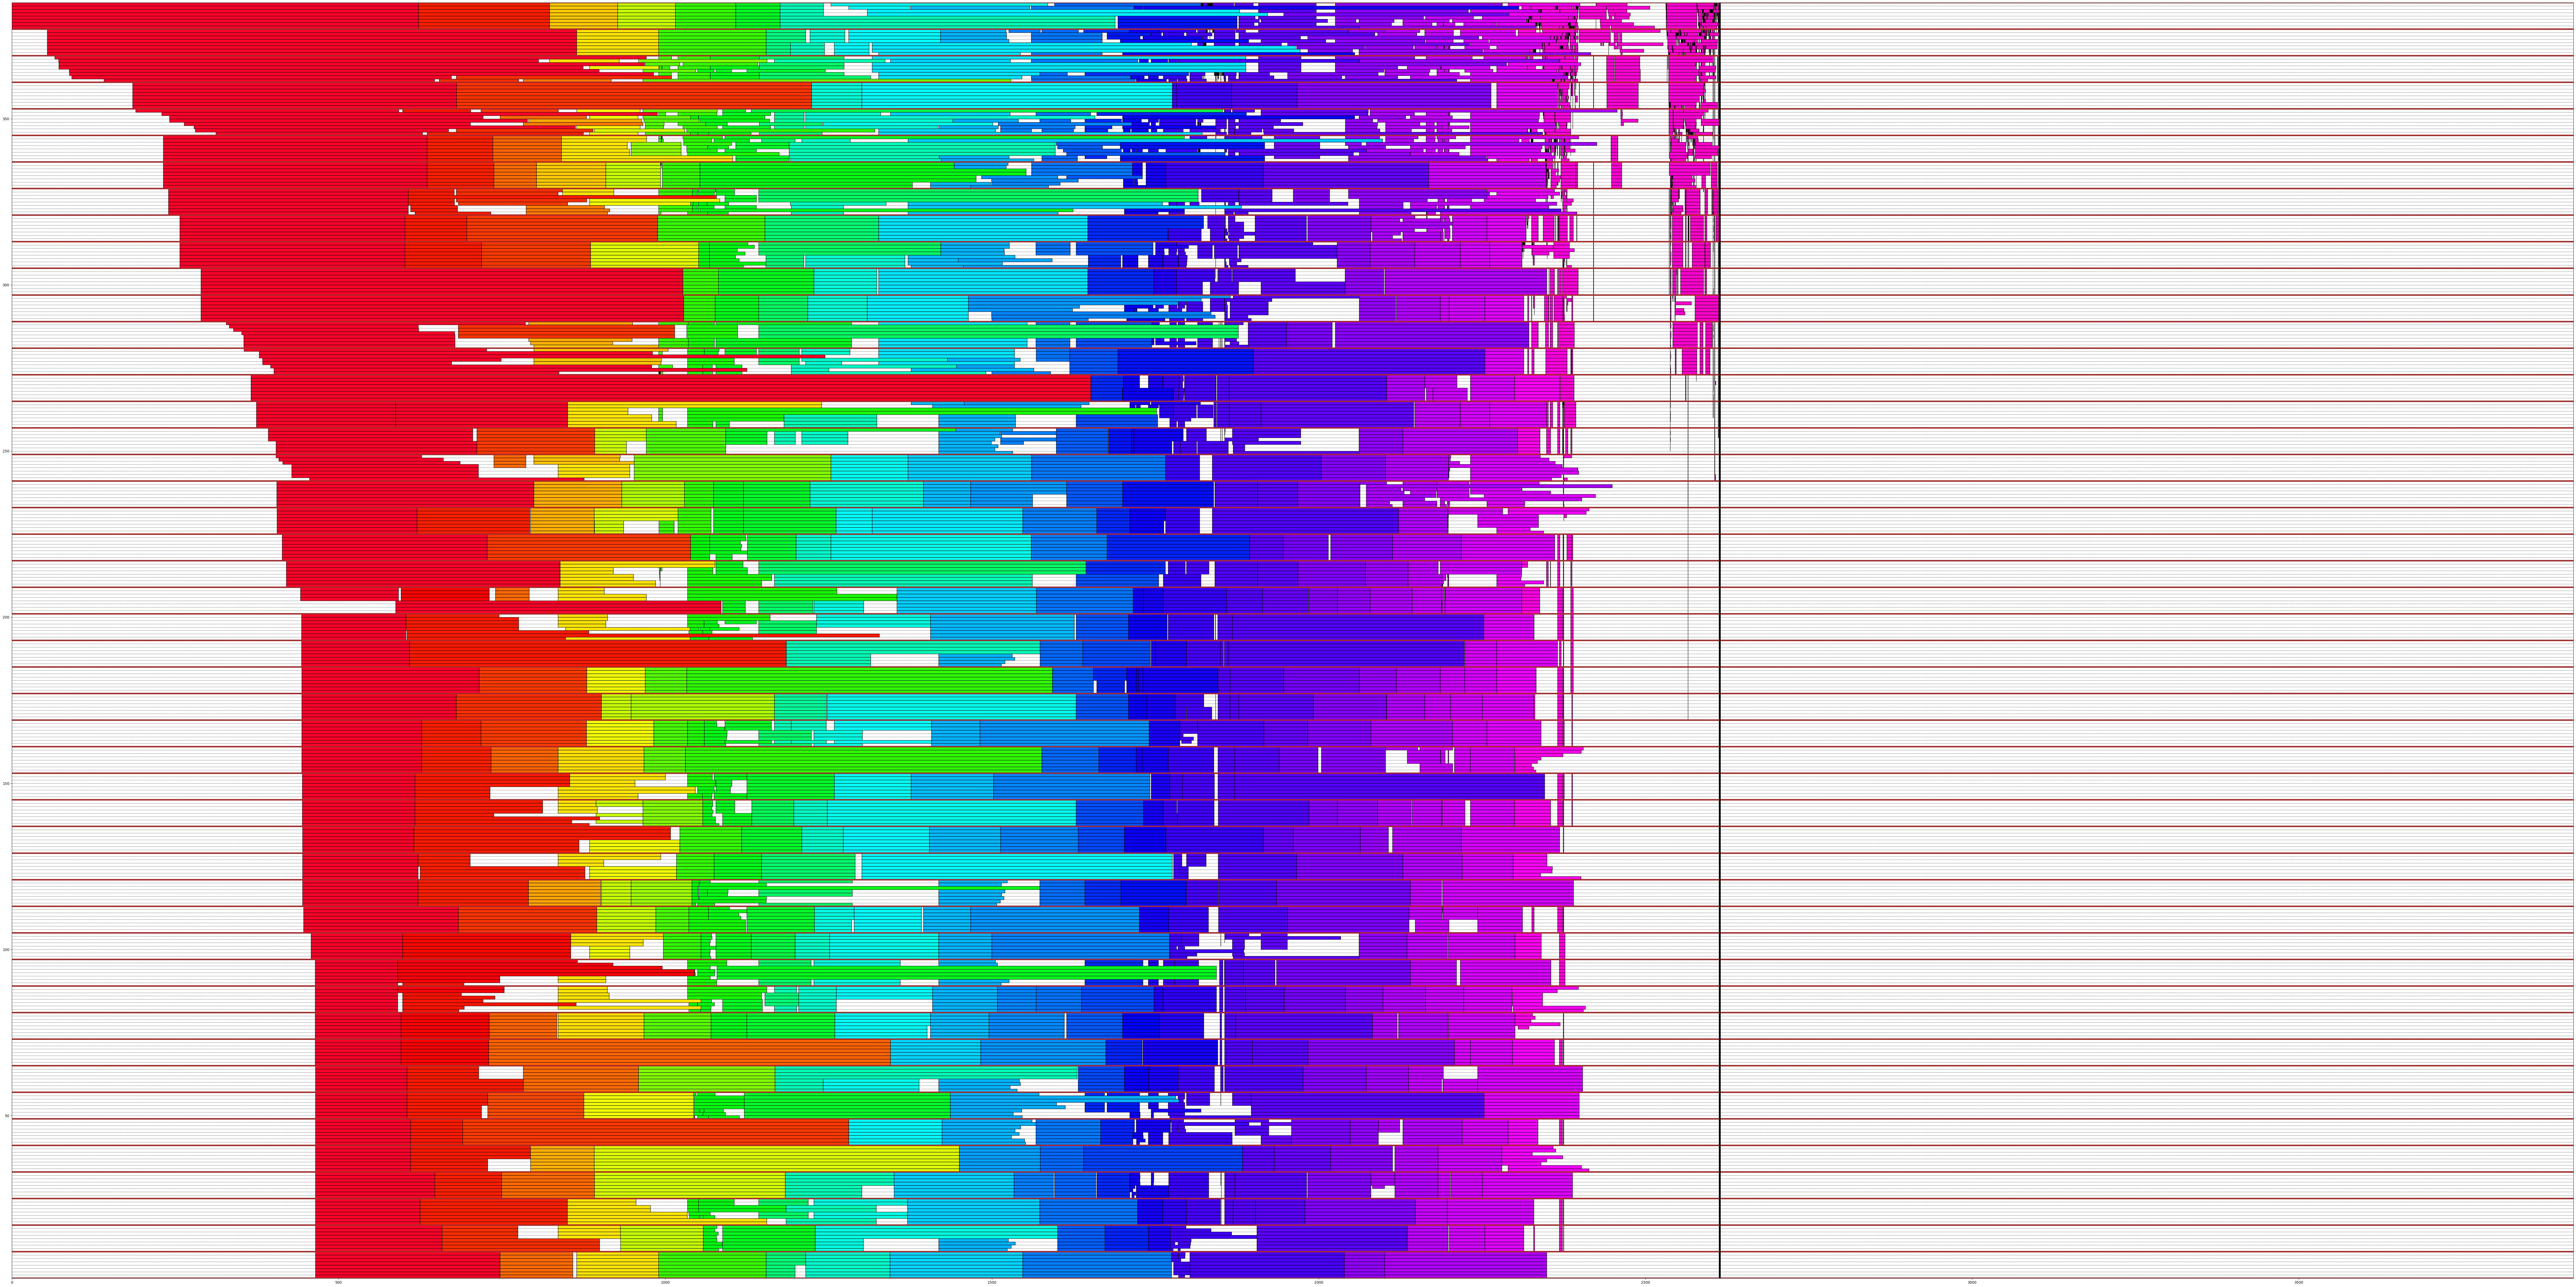

In [23]:
quantized_gpu_traces(hybrid_results['fifo-48'], num_nodes=48)

all


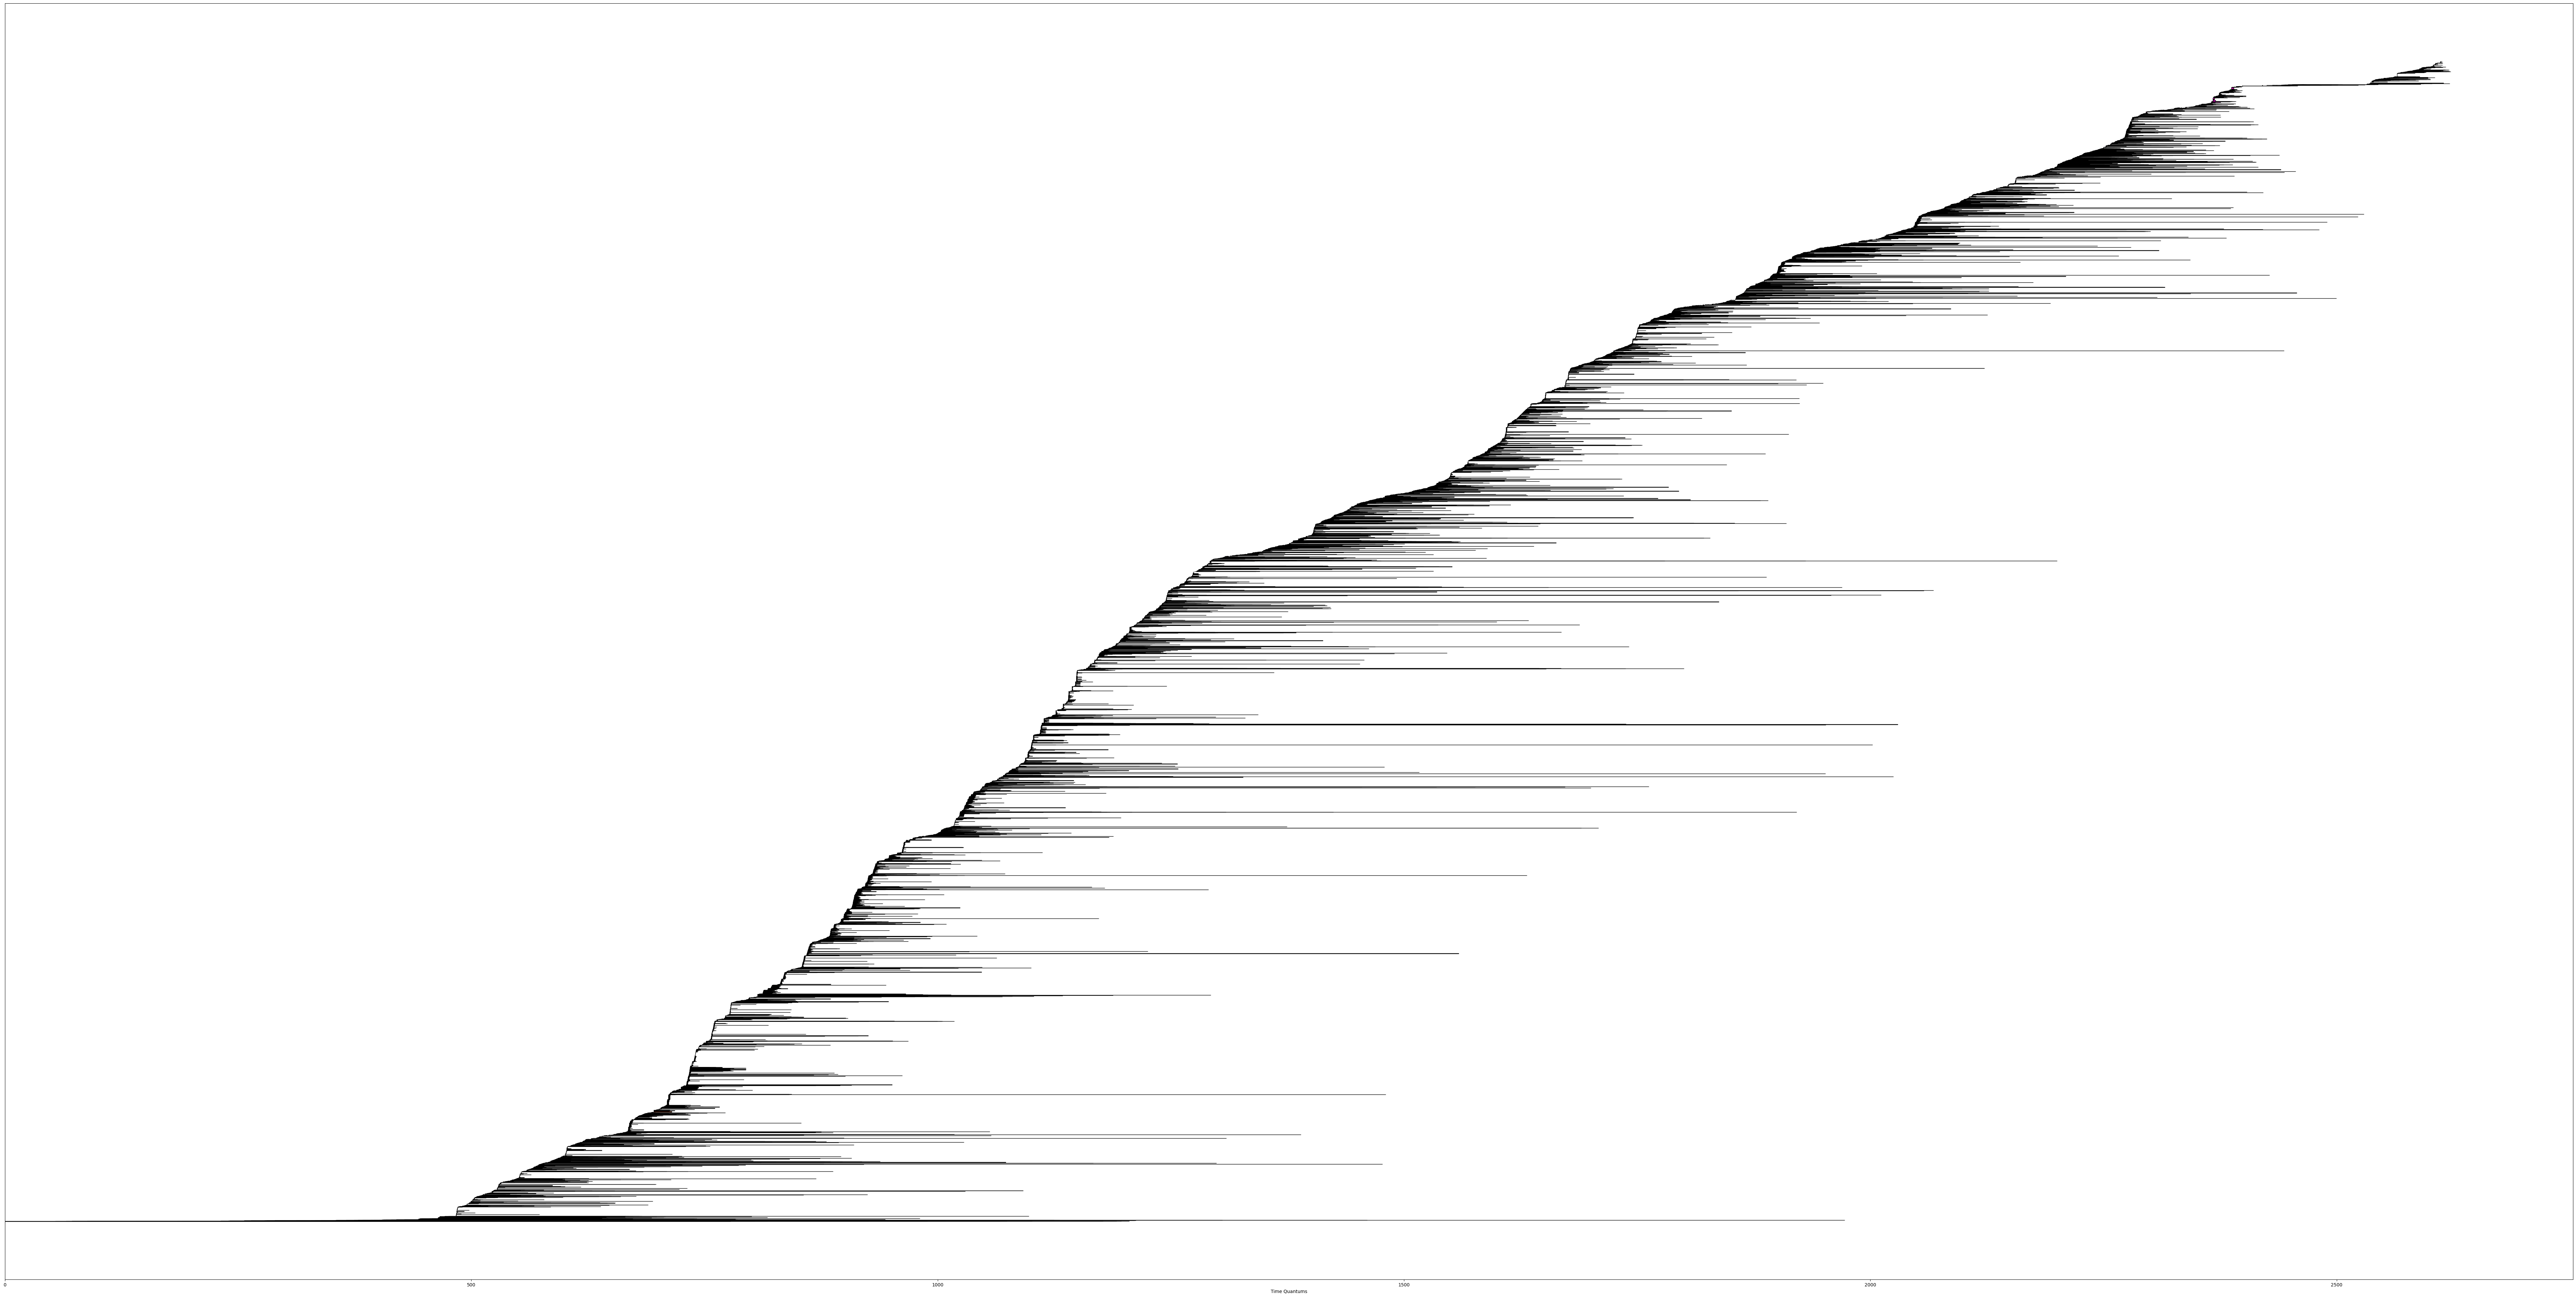

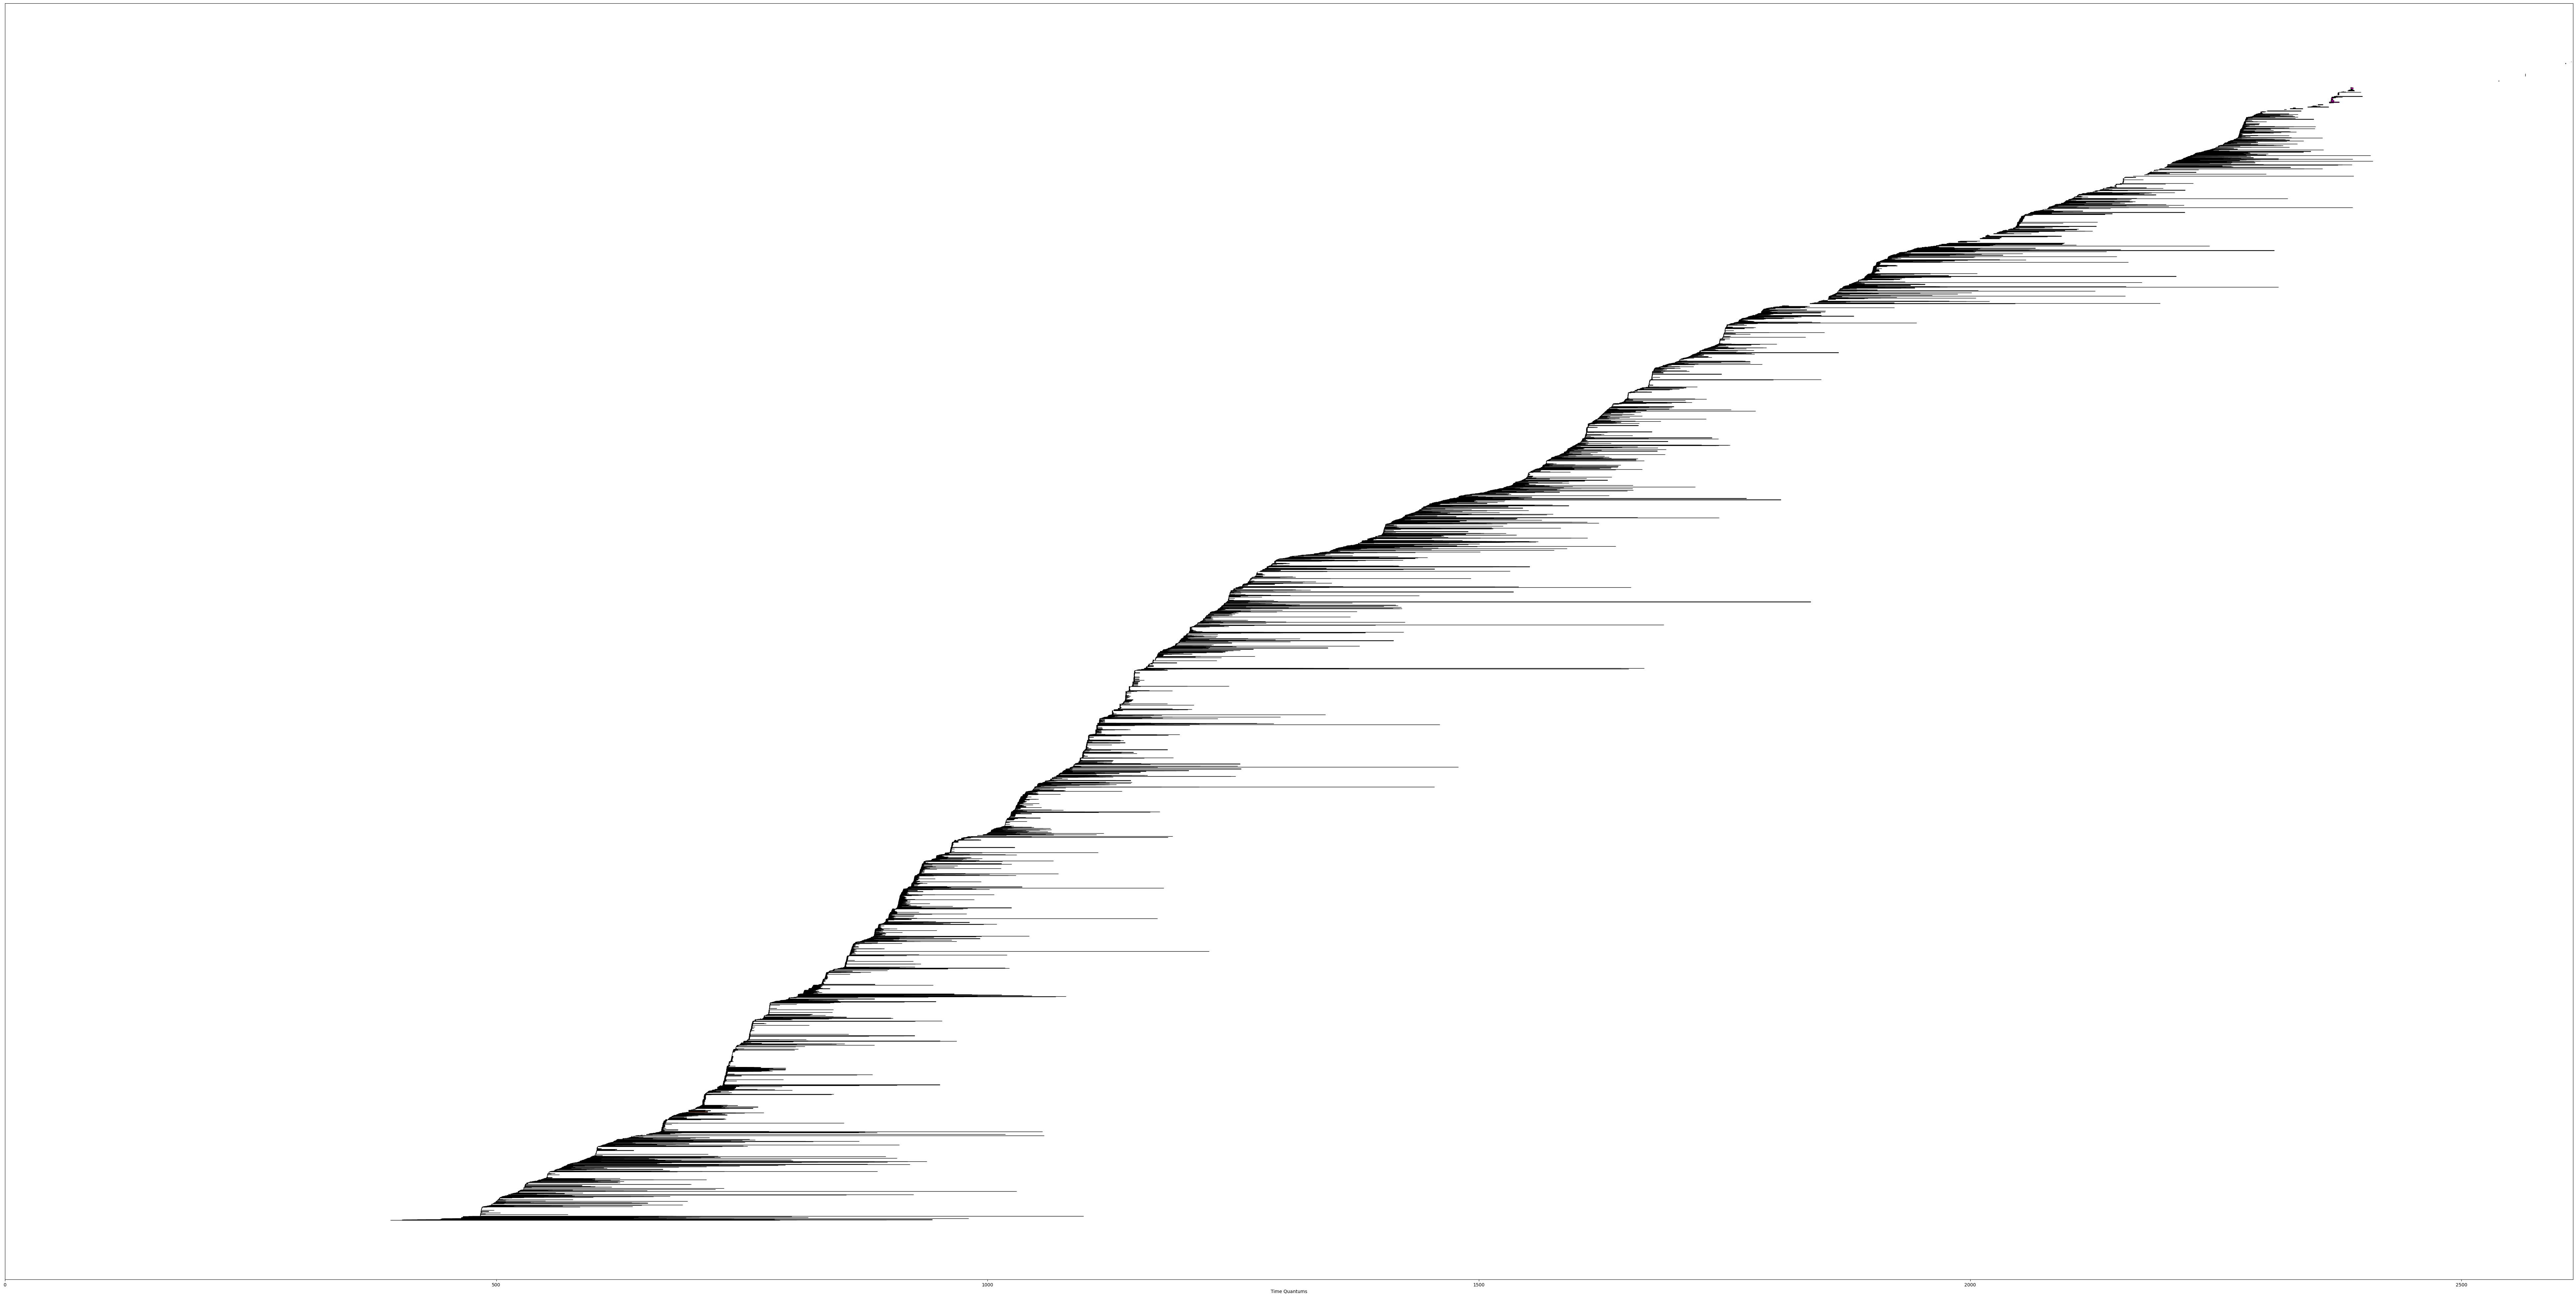

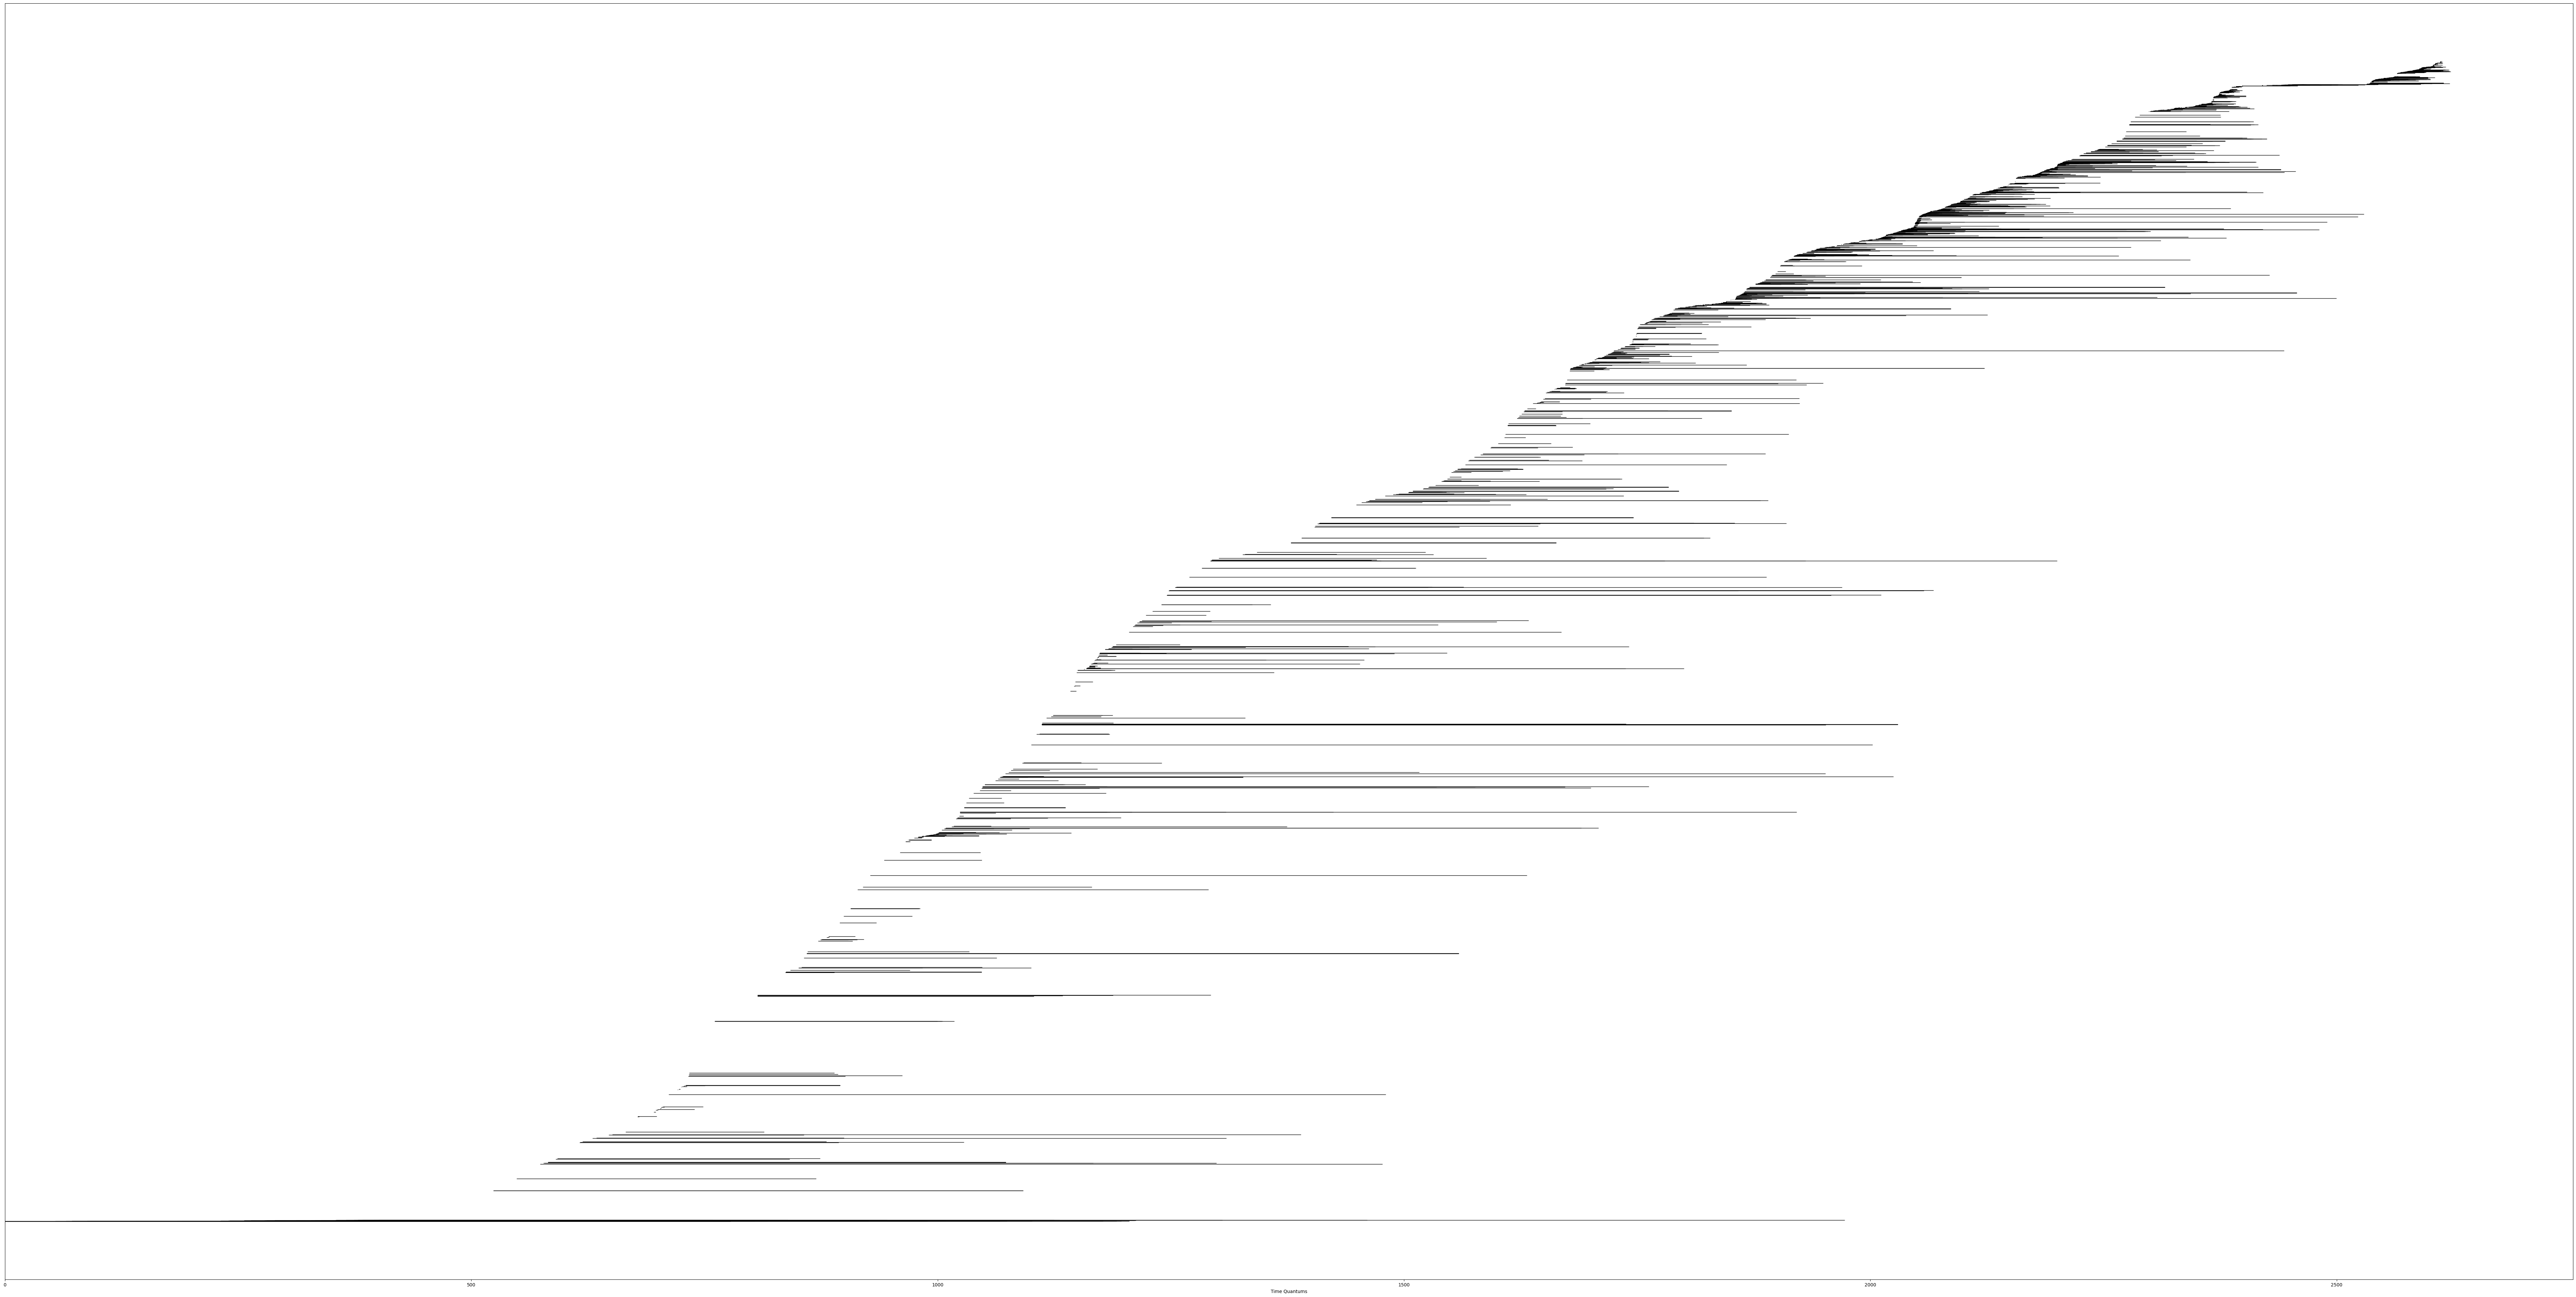

In [141]:


print('all')
plot_qjob_runtimes(results['lvjf-16'][1], mode='all')
for alg in algs:
    for job_filter in ['cloud', 'local']:
        plot_qjob_runtimes(results['lvjf-16'][1], mode=job_filter)

689.598888888889
331
fifo-preempt


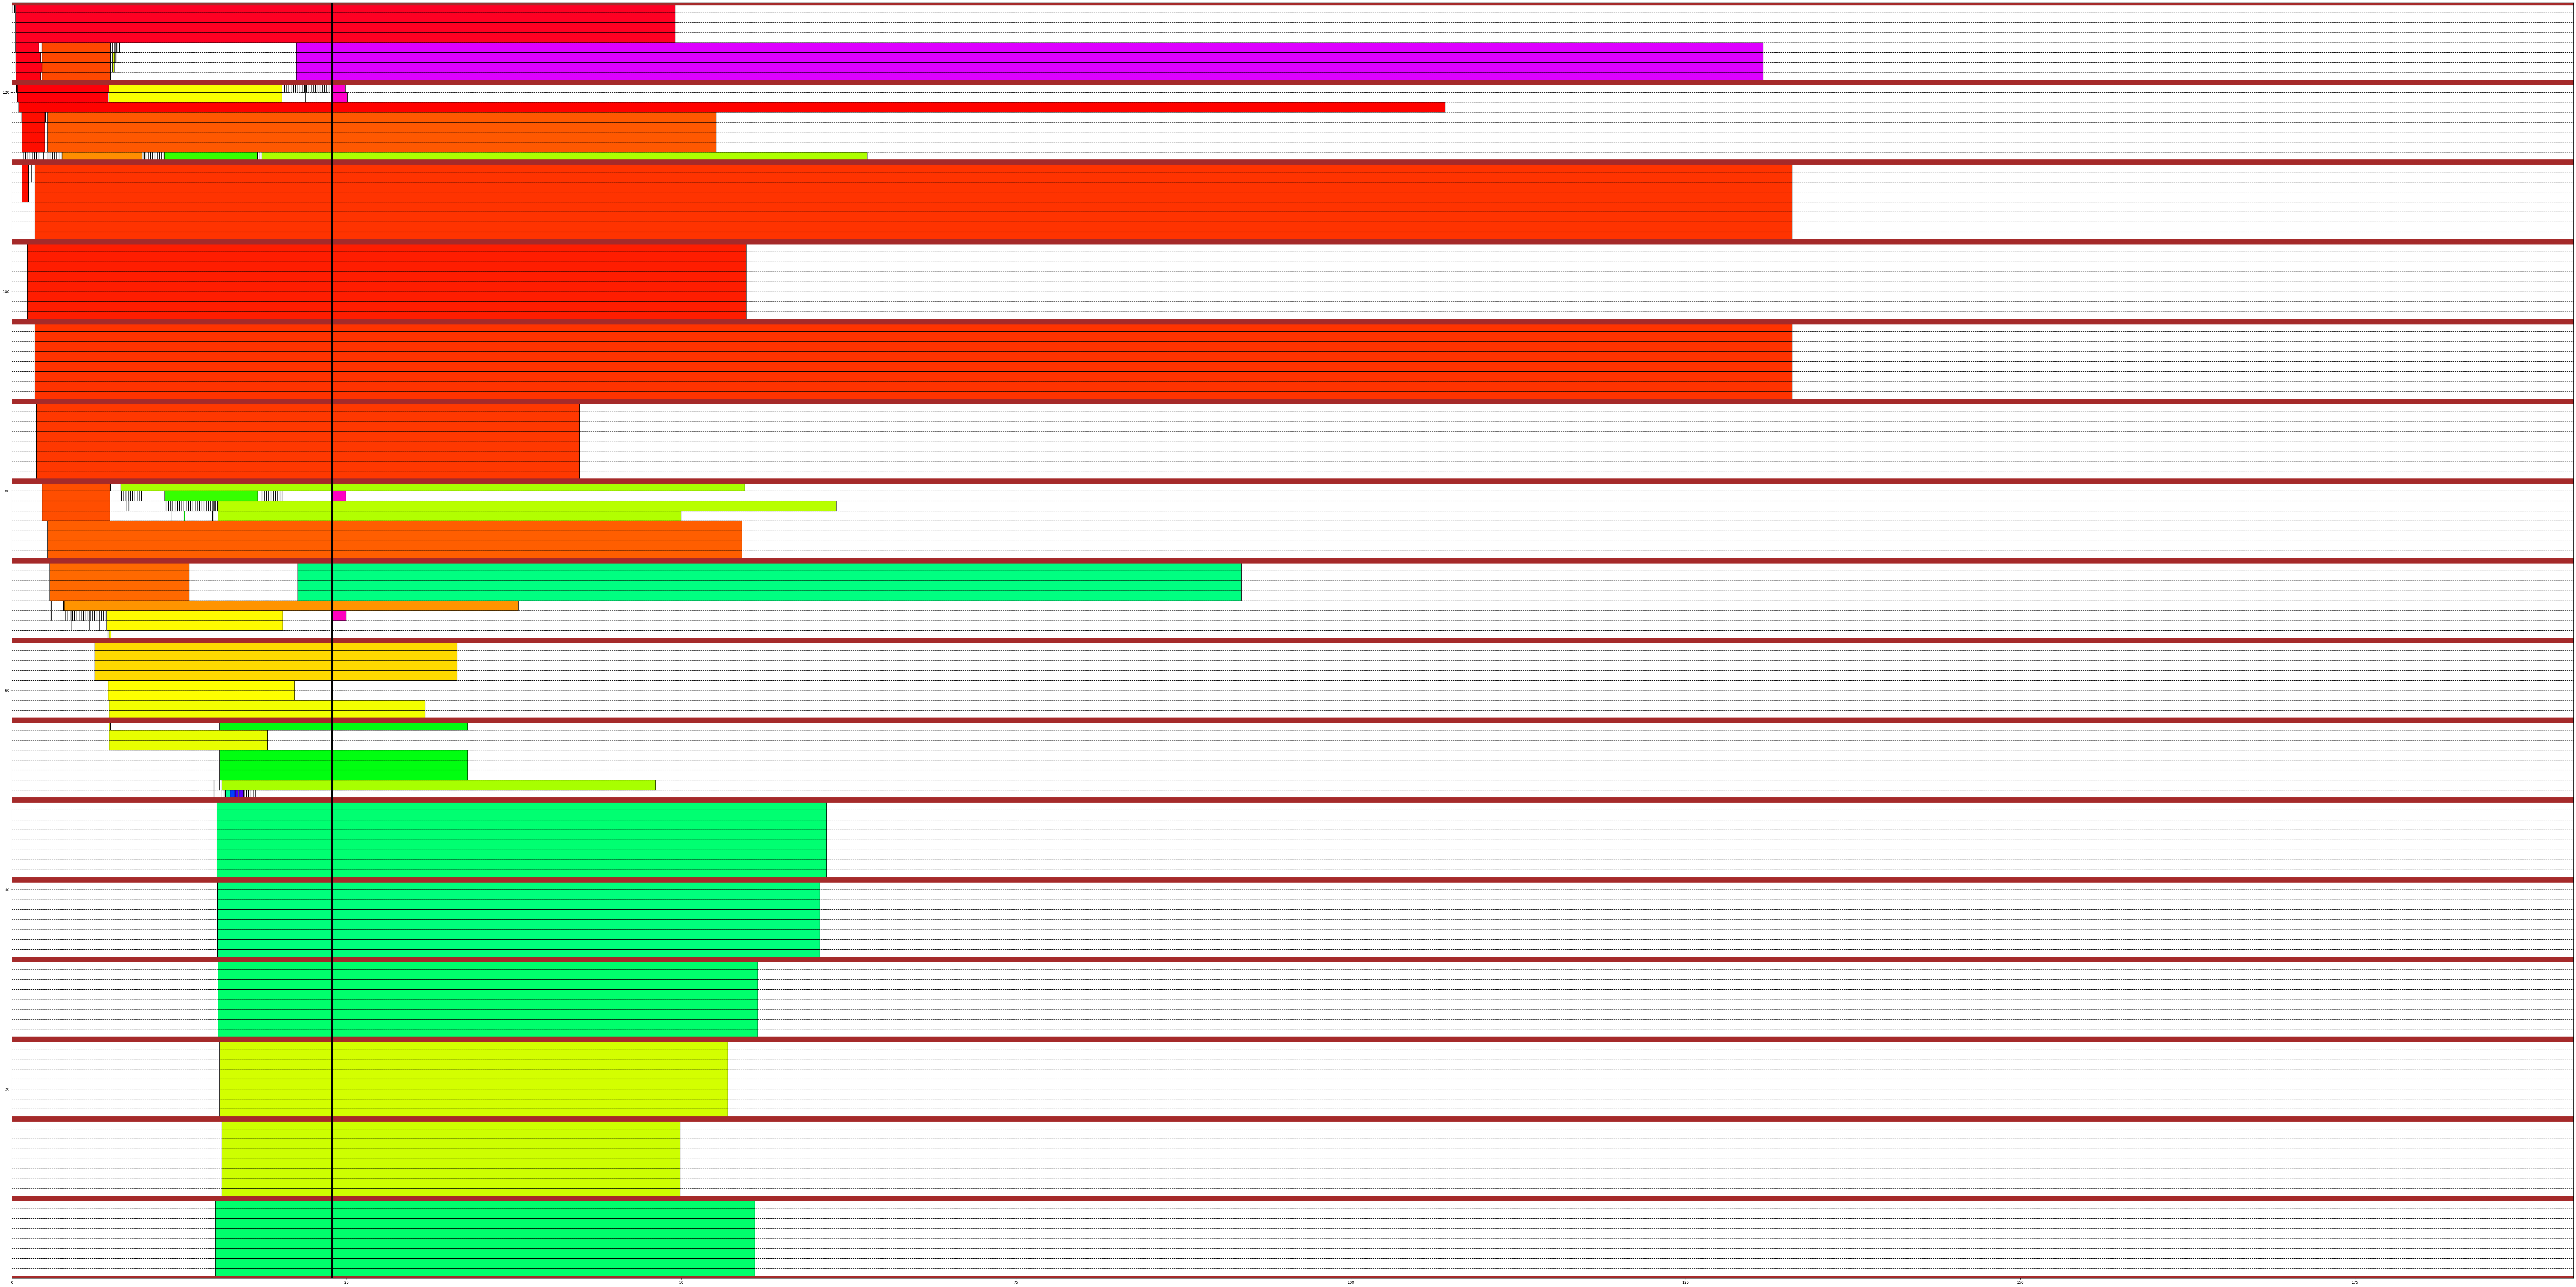

In [121]:
algs = ['lvjf'] #['fifo', 'edf', 'ljf', 'lvjf']
results = {}
num_nodes = [4,8,16,32,64,128, 256,512]
for alg in algs:
    for n_nodes in num_nodes:
        alg_str = f'{alg}-{n_nodes}'
        results[alg_str] = simulator(jobs_proc, policy=alg, num_nodes=n_nodes,preempt=True, verbose=False, debug=False)

# for alg in algs:
#     print(alg)
#     quantized_gpu_traces(results[alg][1])

973.8505555555555
331
fifo-preempt


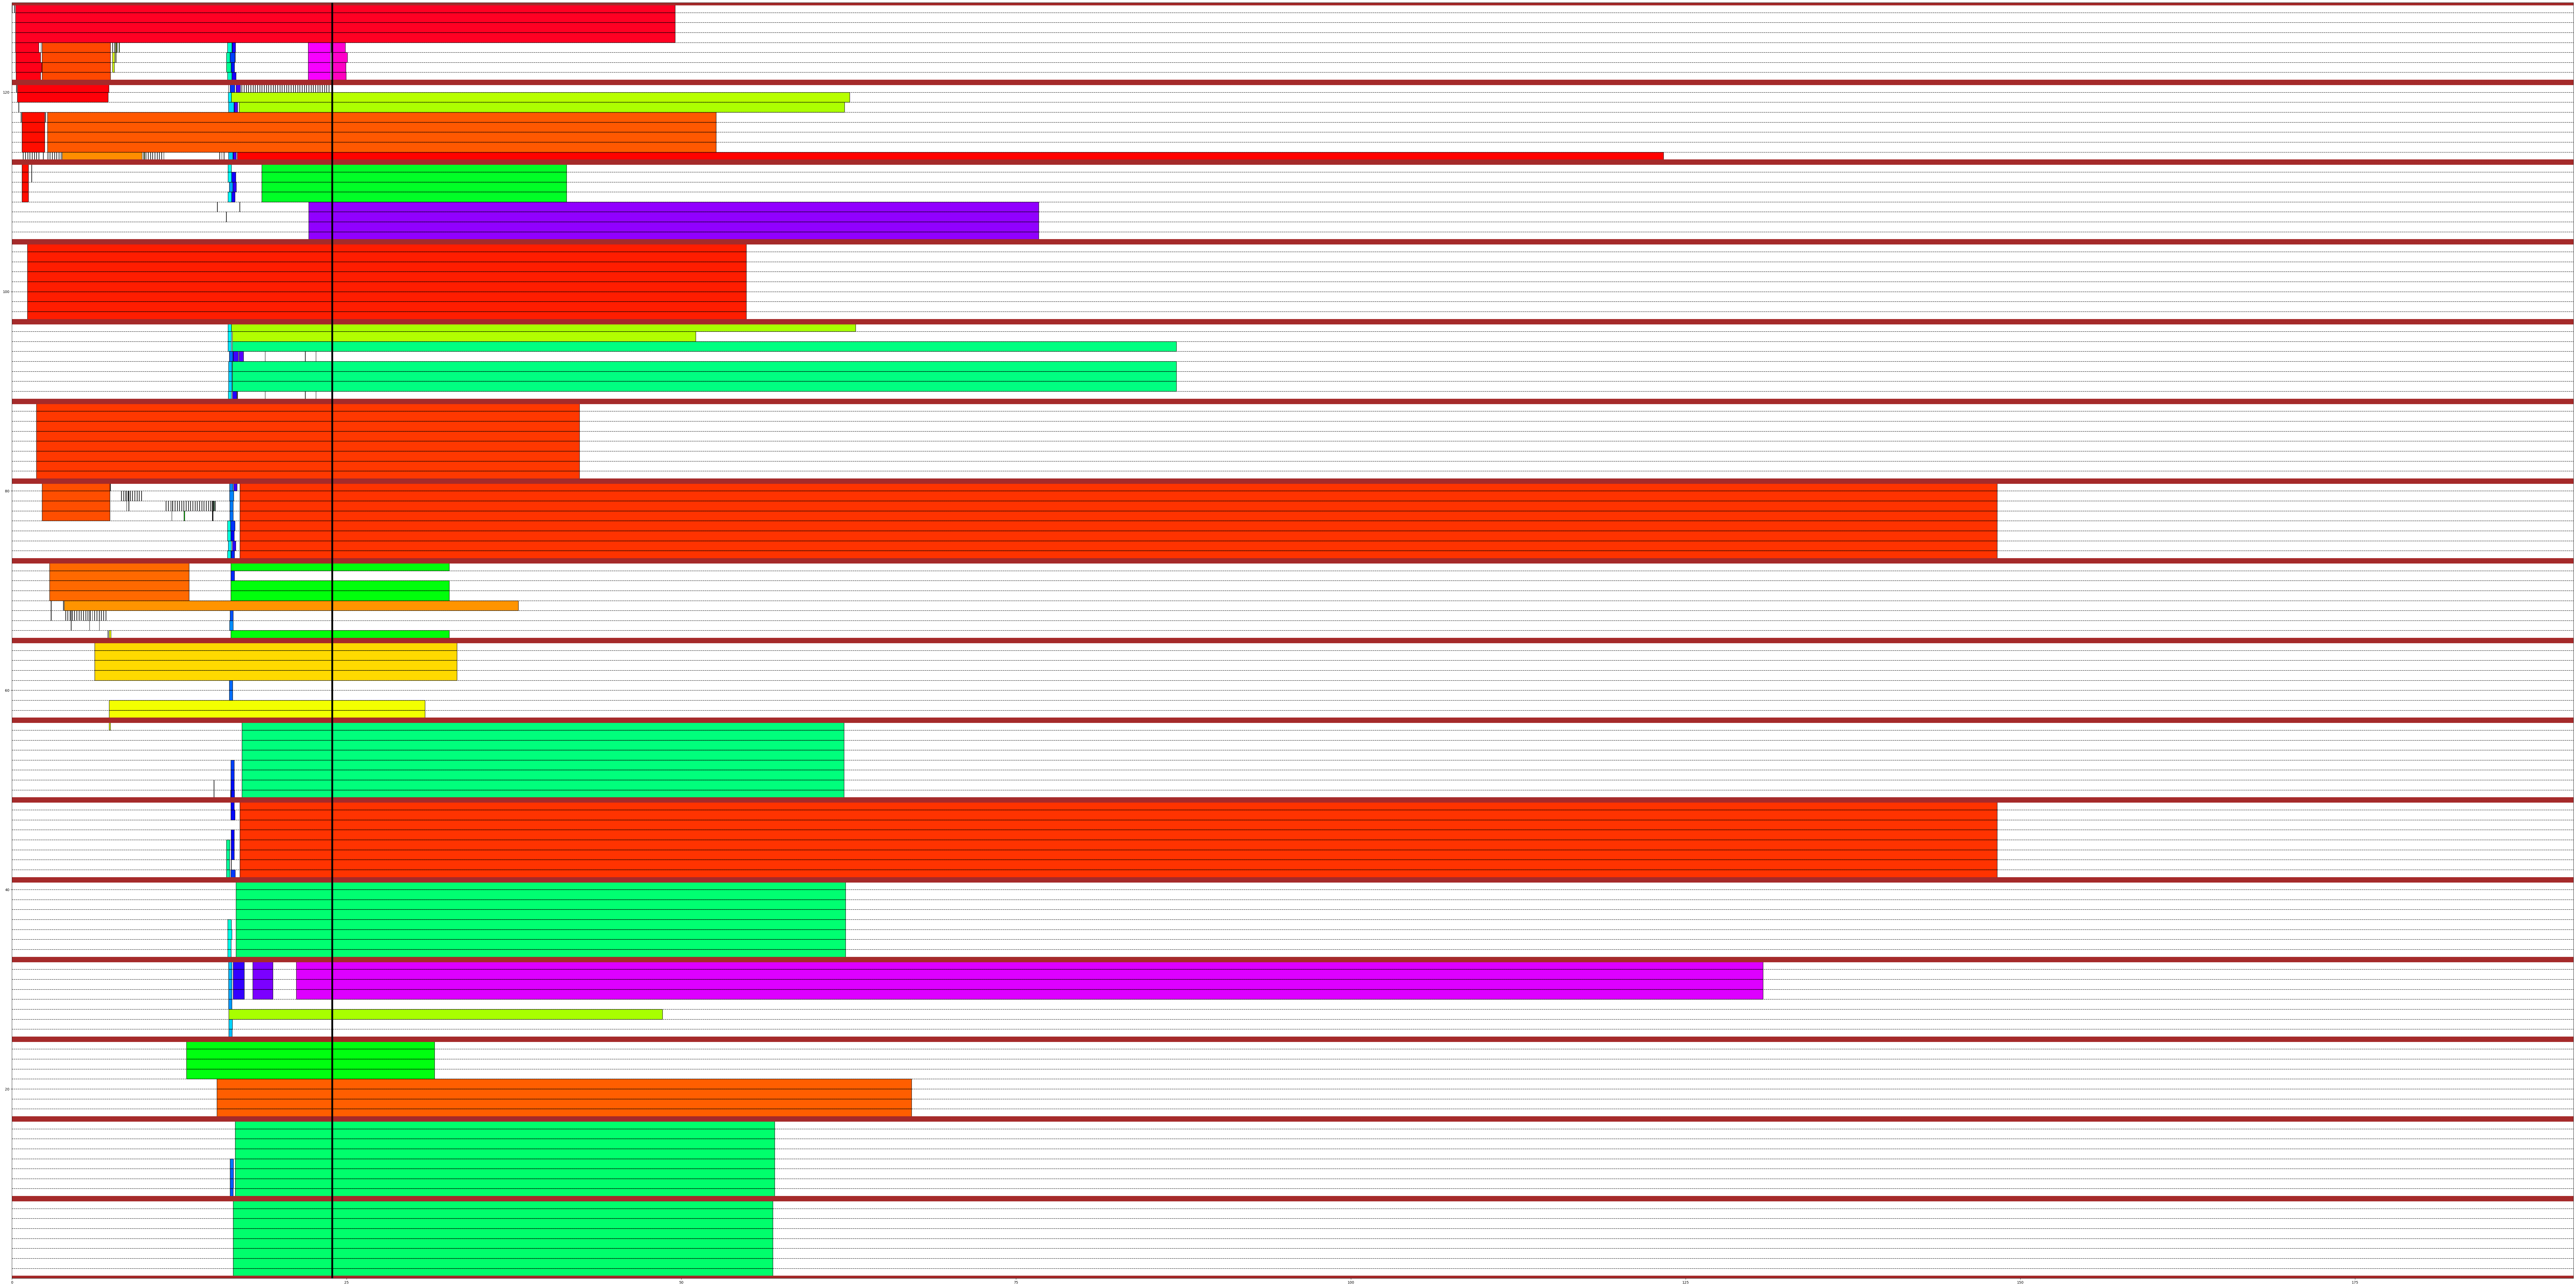

In [122]:
for alg in algs:
    results[alg] = simulator(jobs_proc, policy=alg, preempt=True, reserve=True, verbose=False, debug=False)

for alg in algs:
    print(f'{alg}-preempt')
    quantized_gpu_traces(results[alg][1])

In [18]:
def plot_qjob_runtimes(jobs: List[Job], mode='all'):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs)
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    jobs.sort(key=lambda x: x.idx)
    x = [(j.arrival, j.deadline) for j in jobs]
    fig, ax = plt.subplots(figsize=(100,50))
    
    count=0
    for i,evt in enumerate(x):
        if mode=='all':
            mask = 1
        elif mode=='cloud':
            if jobs[i].start is None:
                mask=1
            else:
                mask=0
        elif mode=='local':
            if jobs[i].start is None:
                mask=0
            else:
                mask=1
#         ax.barh(count,
#                 width=(evt[1]-evt[0]),
#                 edgecolor='black' if mask else None,
#                 height=1.0*jobs[i].num_gpus,
#                 left=evt[0],
#                 align='edge',
#                 color=colors[i] if mask else 'grey')
        ax.barh(count,
                width=mask*(evt[1]-evt[0]),
                edgecolor='black' if mask else None,
                height=1.0*jobs[i].num_gpus,
                left=evt[0],
                align='edge',
                color=colors[i] if mask else None)

        count+= jobs[i].num_gpus 
    ax.get_yaxis().set_visible(False)
    plt.xlabel('Time Quantums')
    plt.show()

all


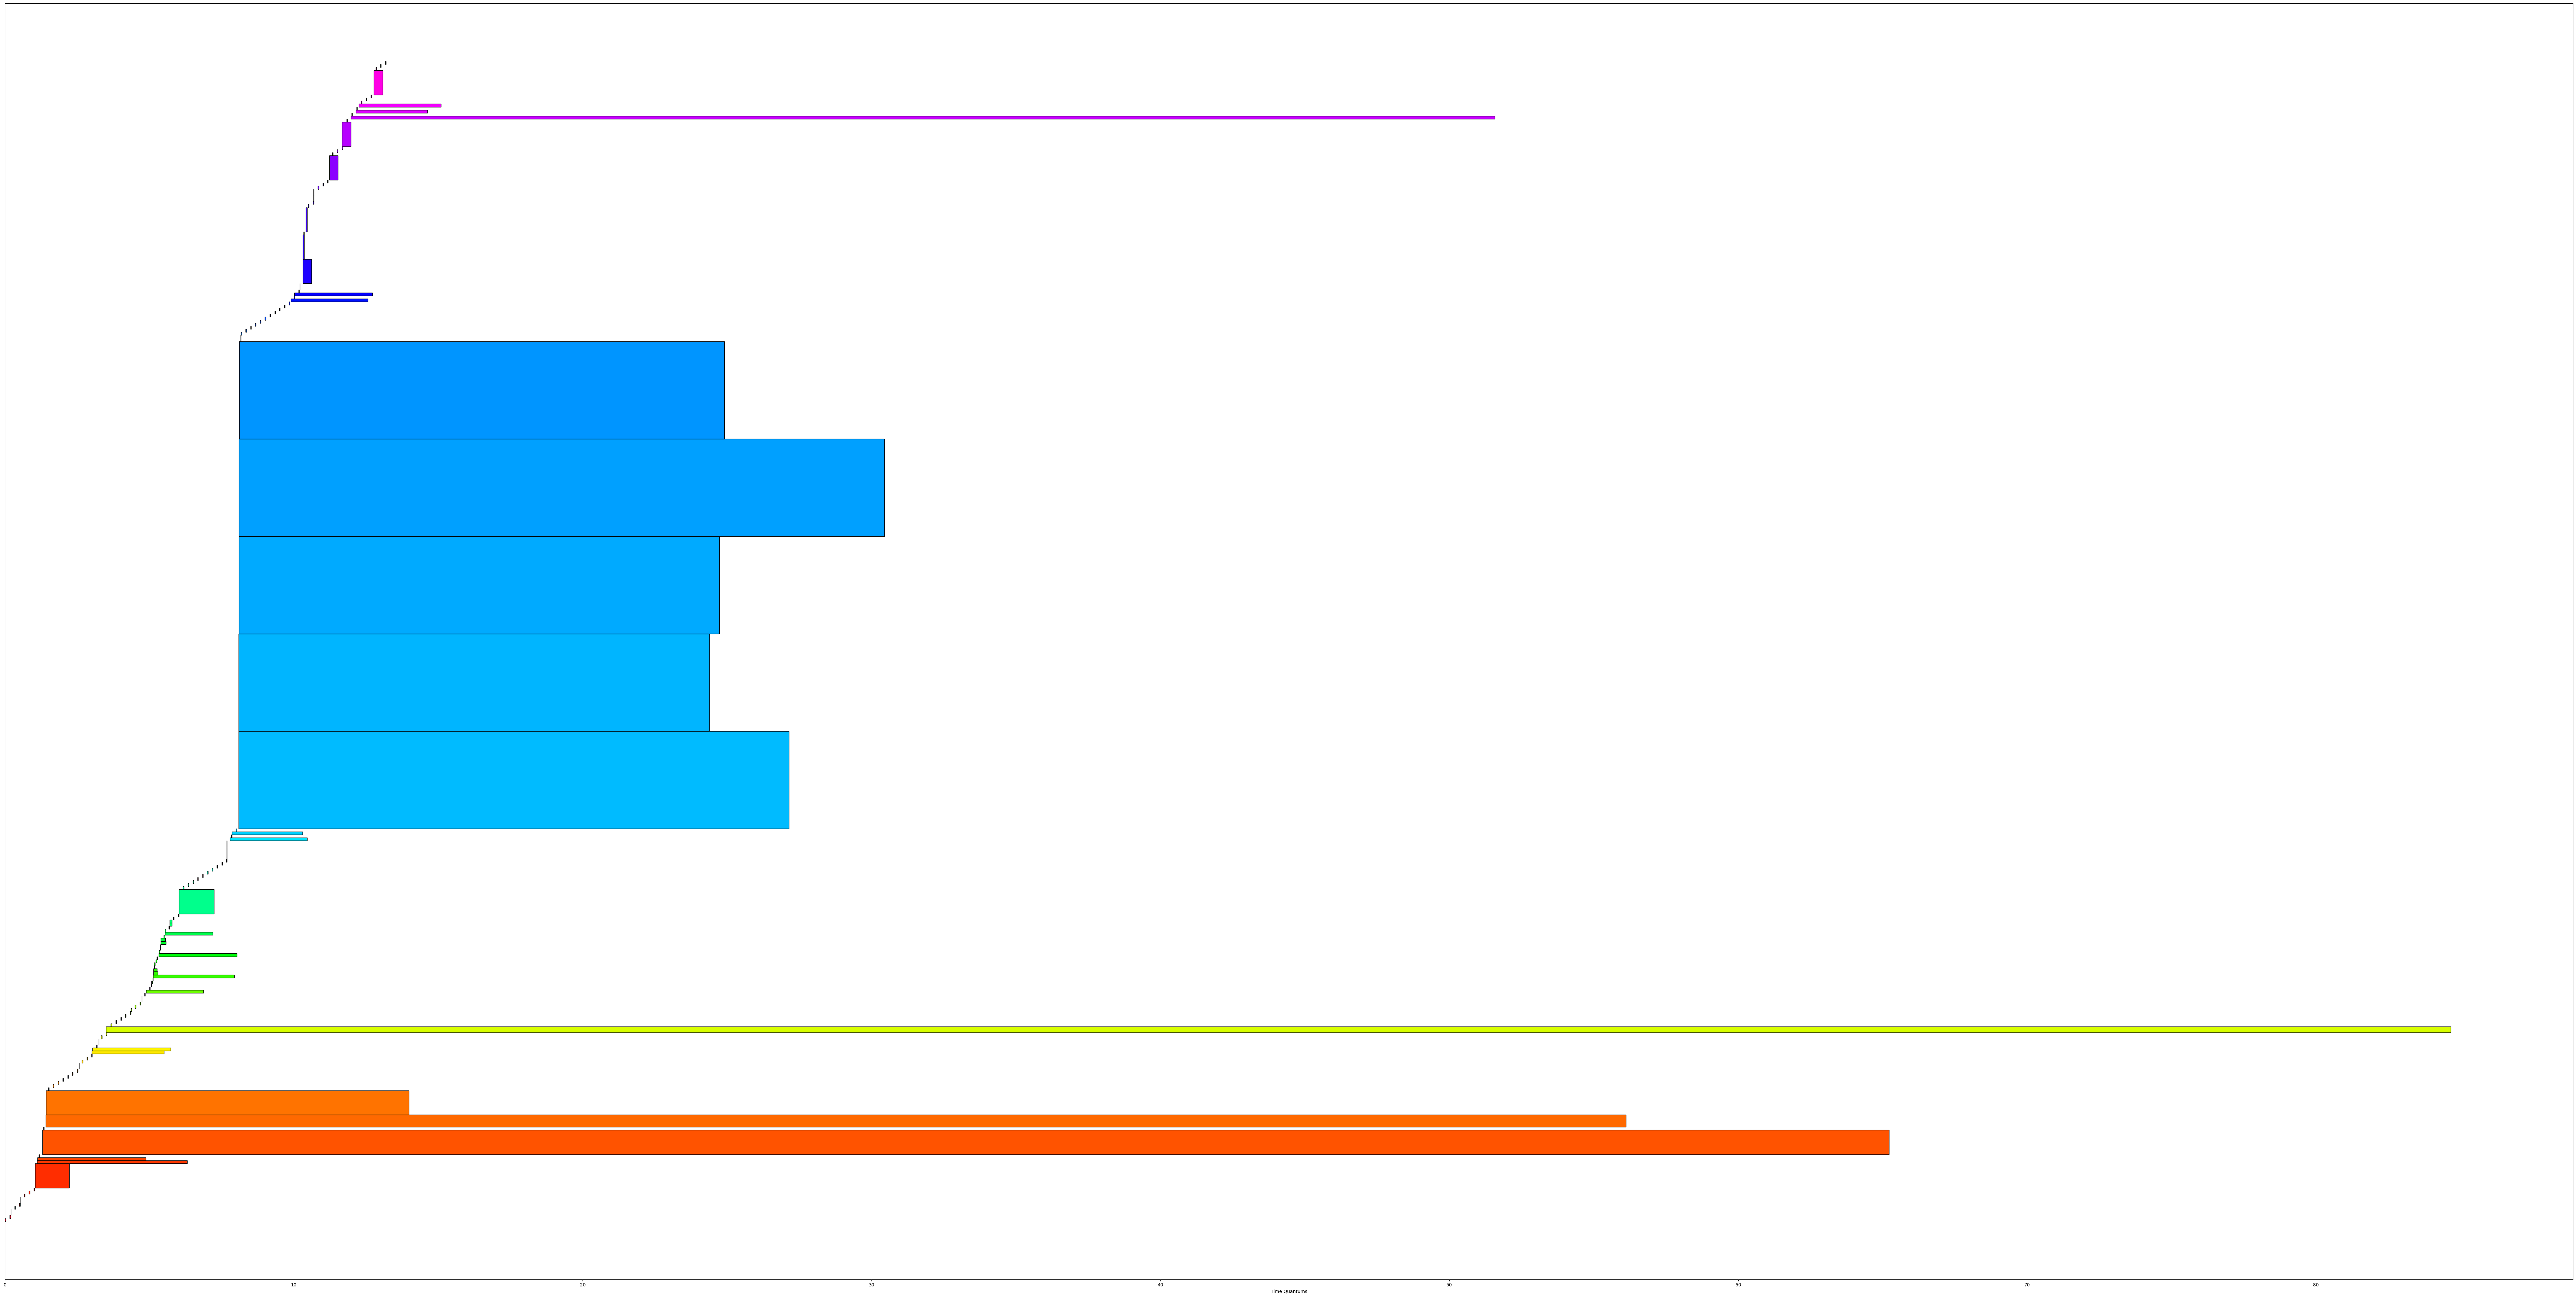

fifo-cloud


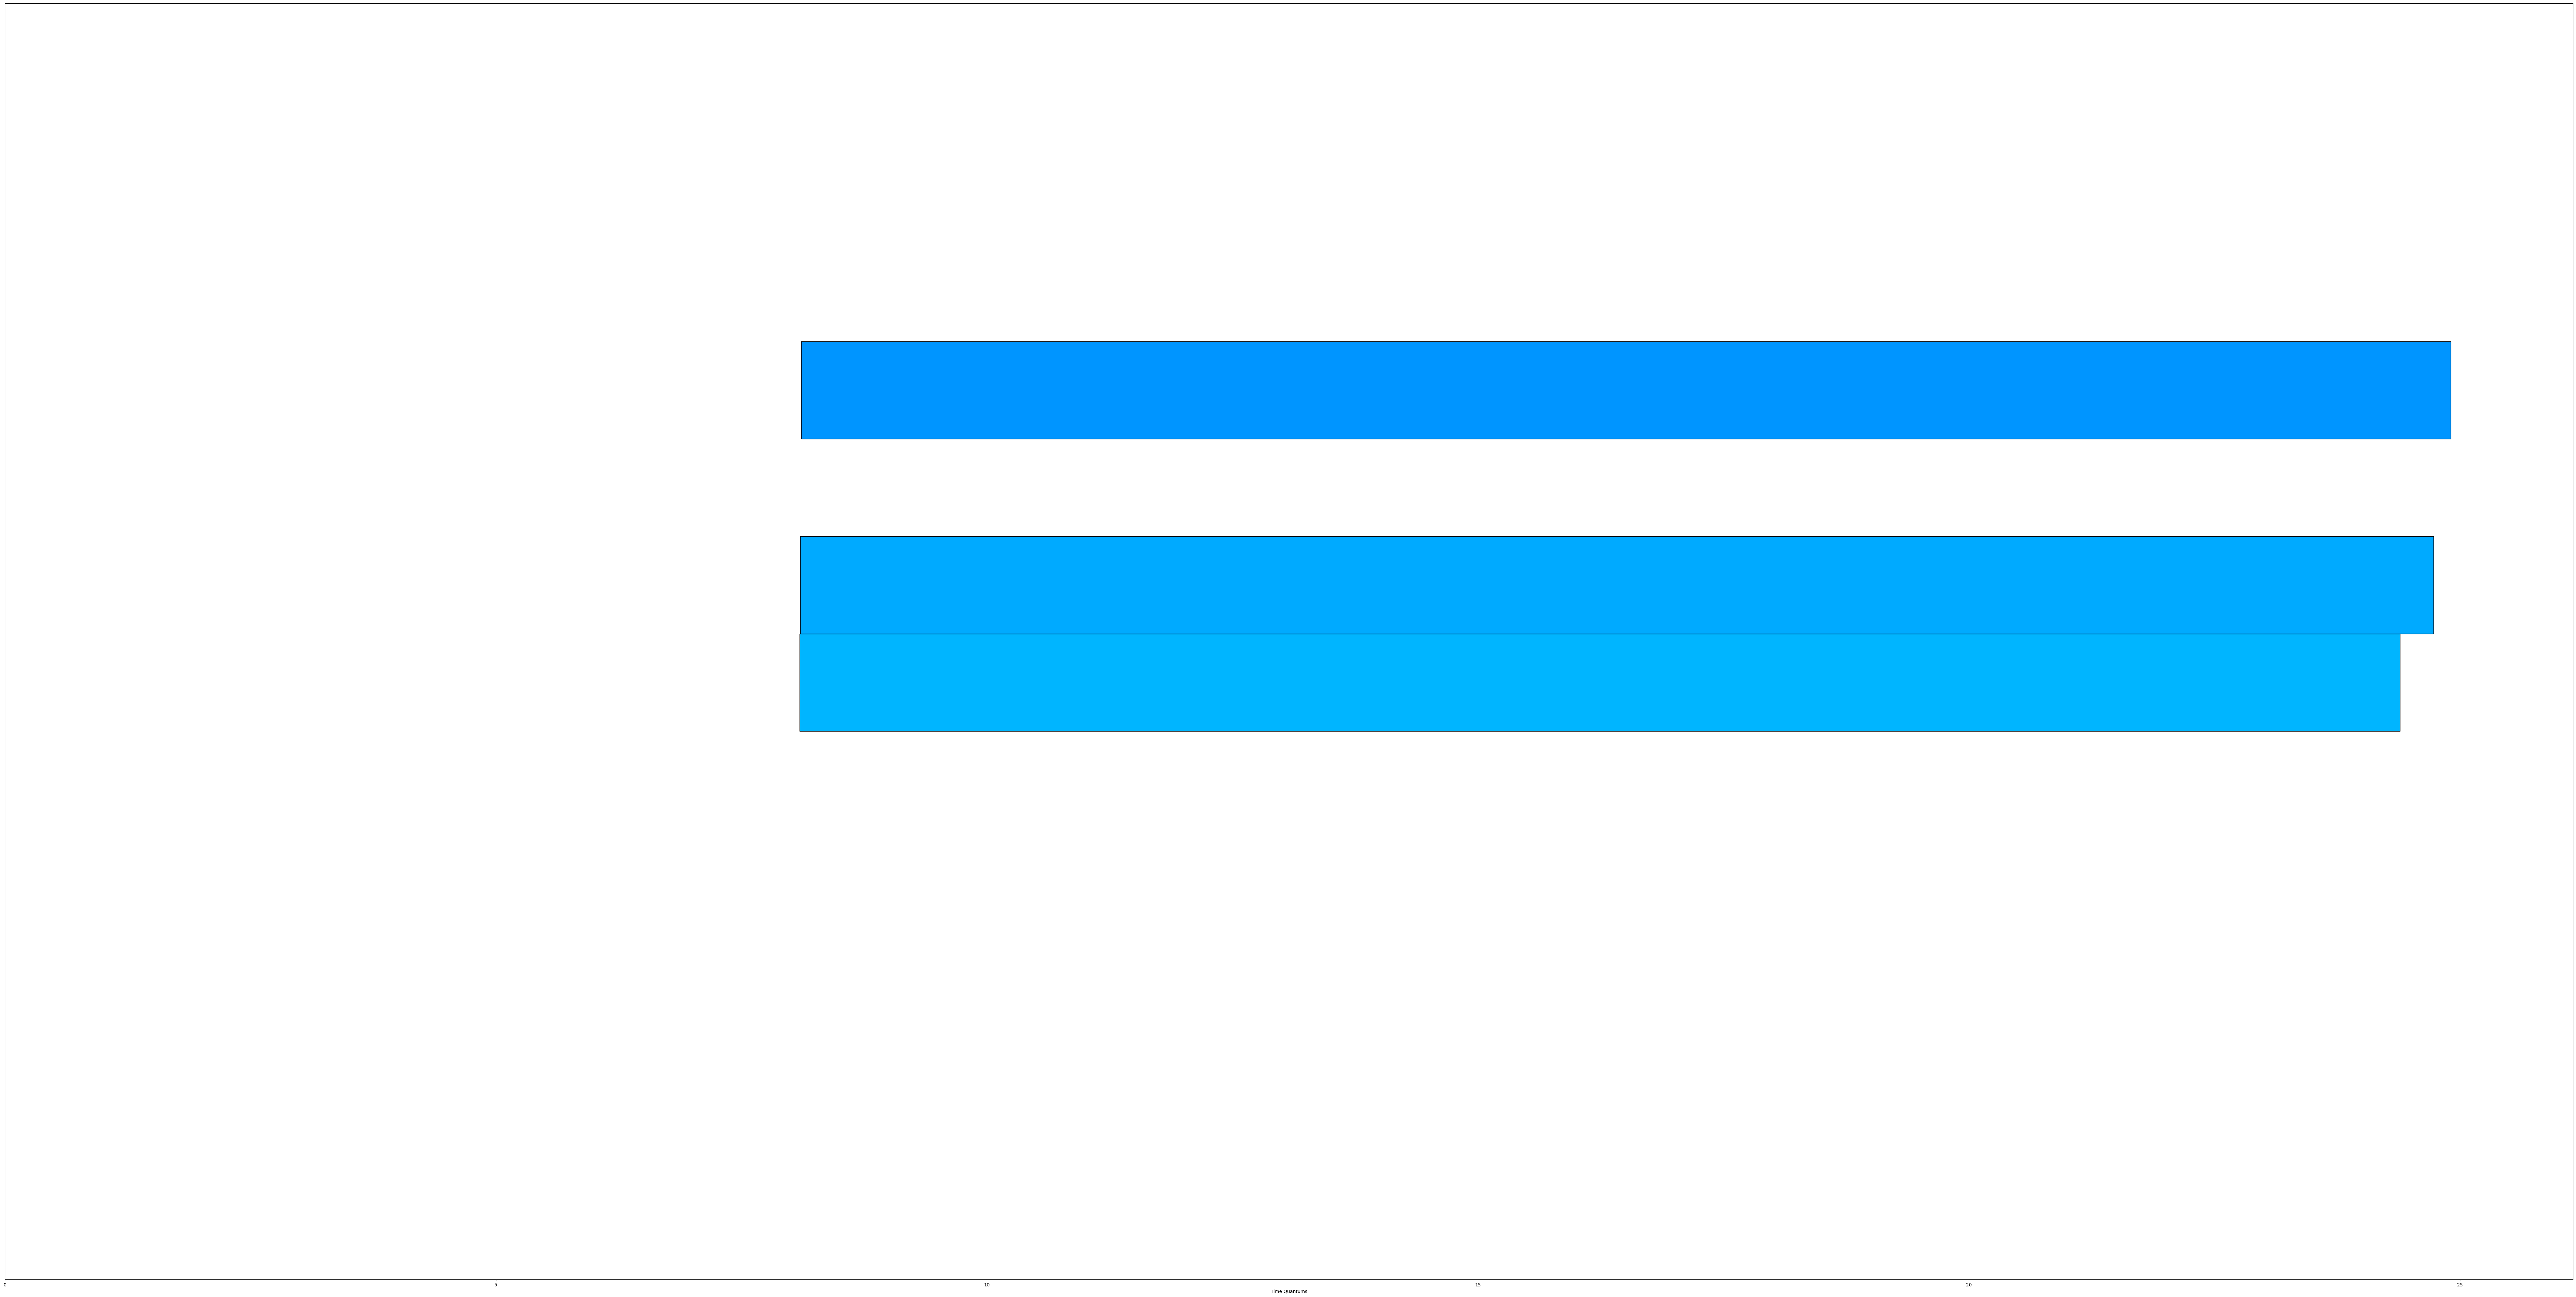

fifo-local


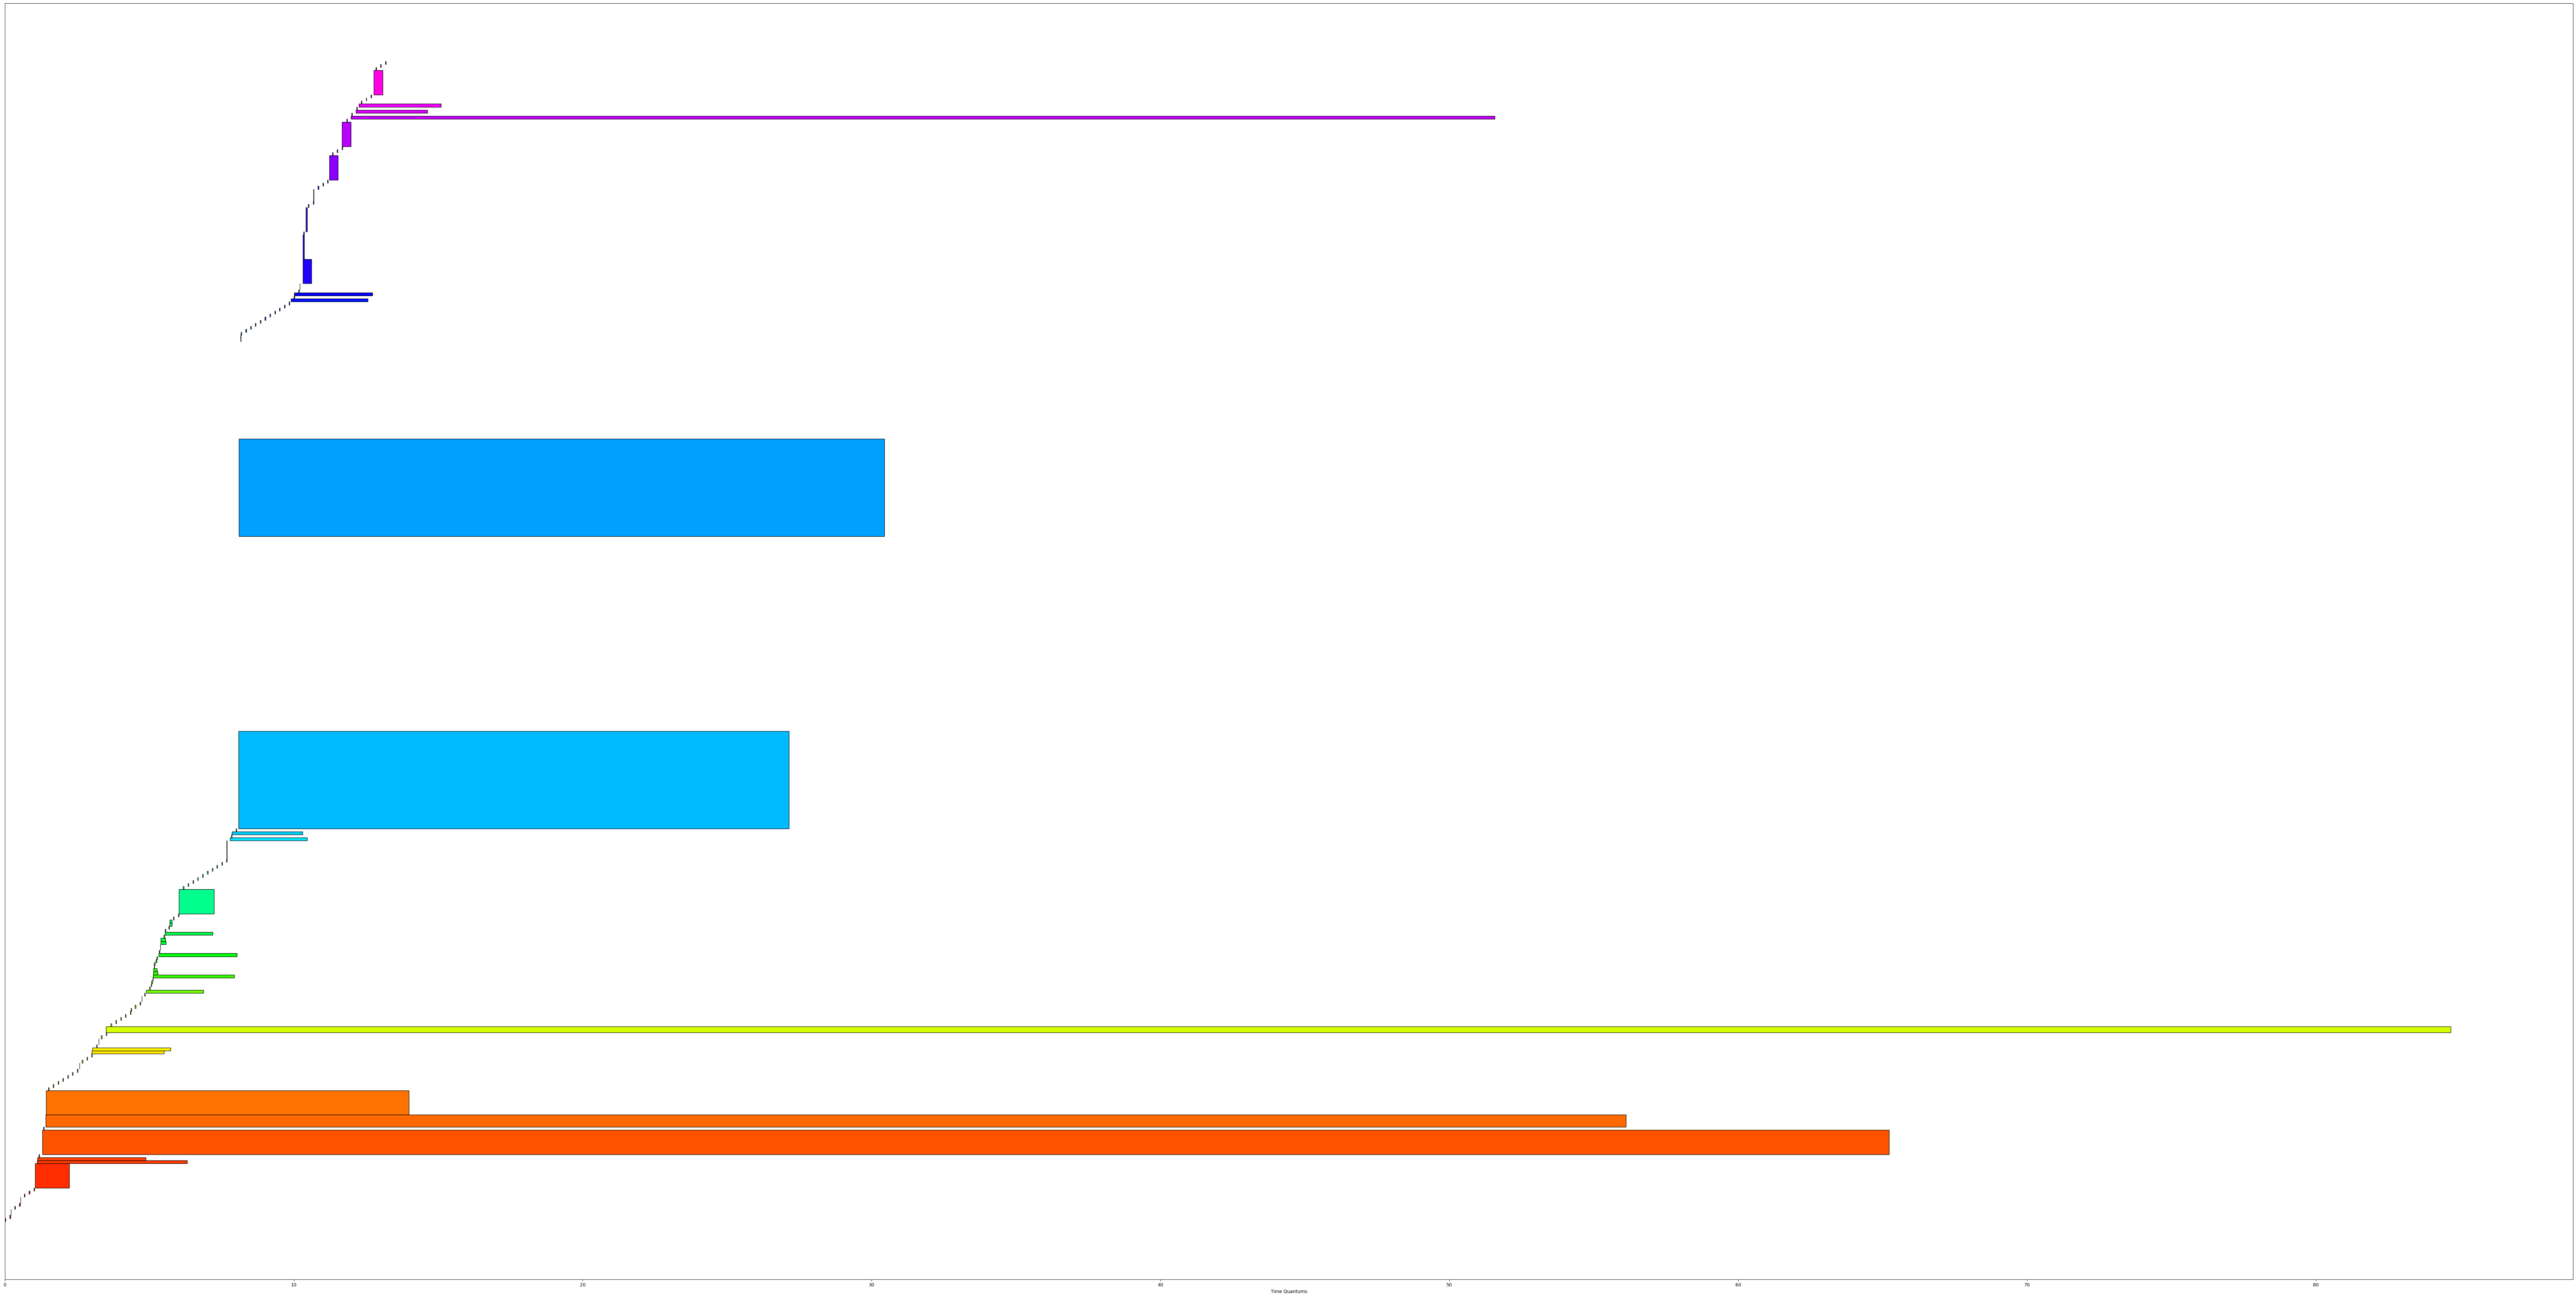

edf-cloud


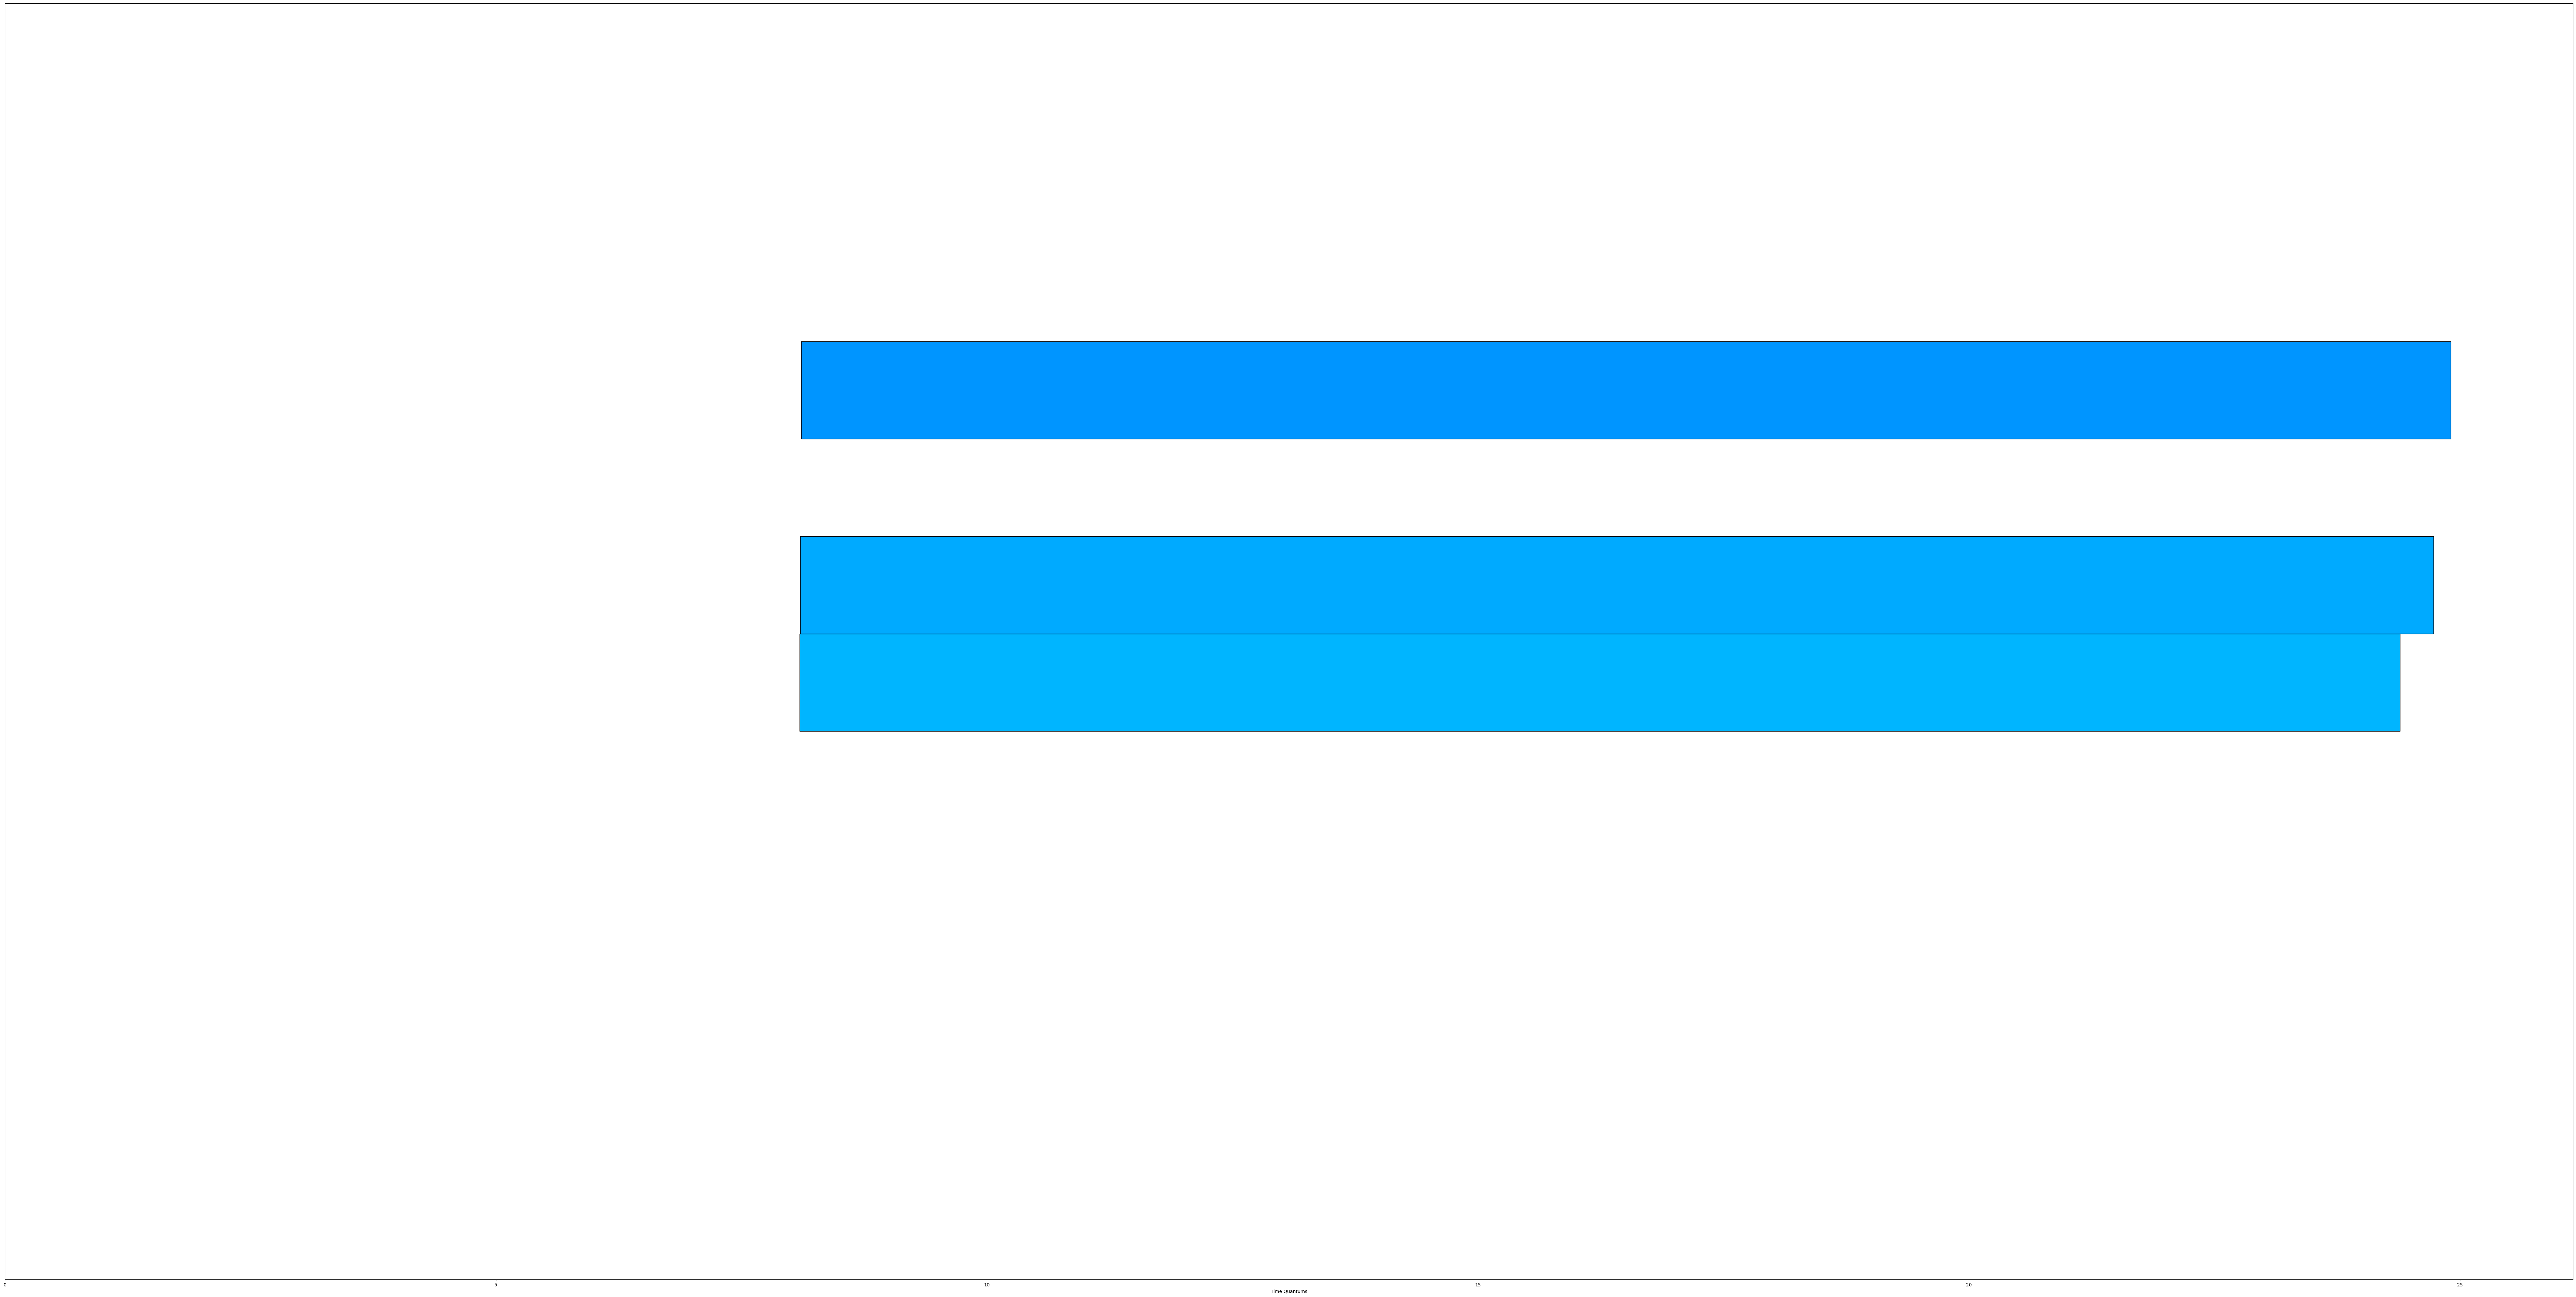

edf-local


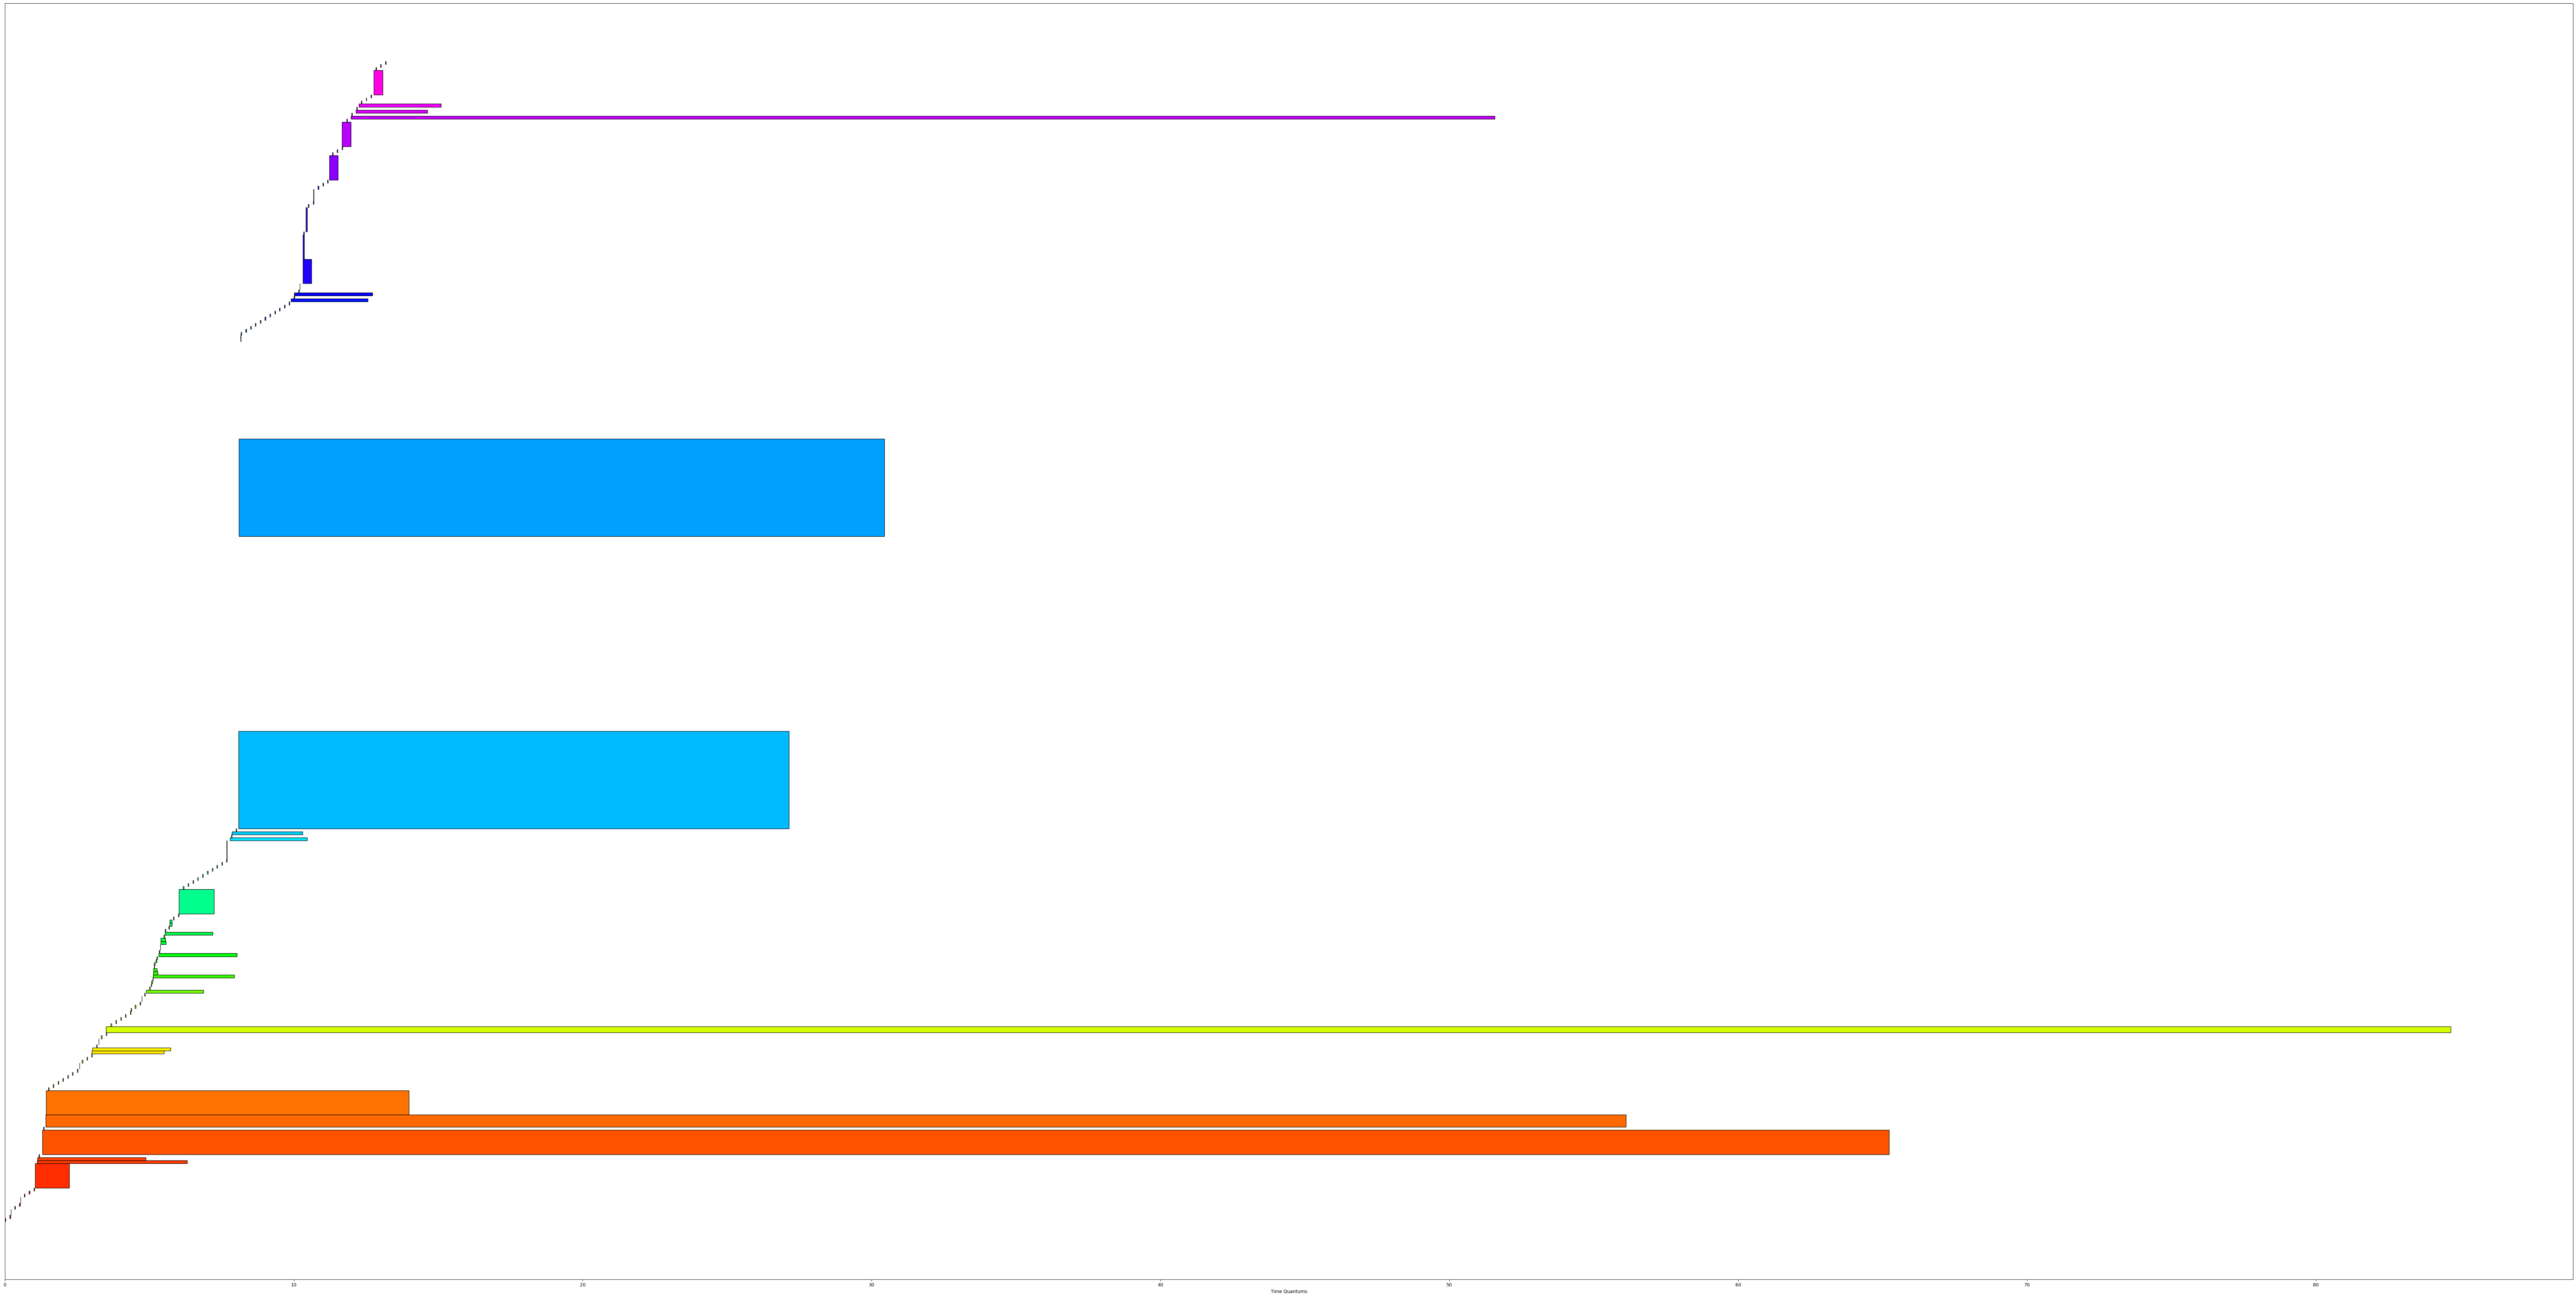

ljf-cloud


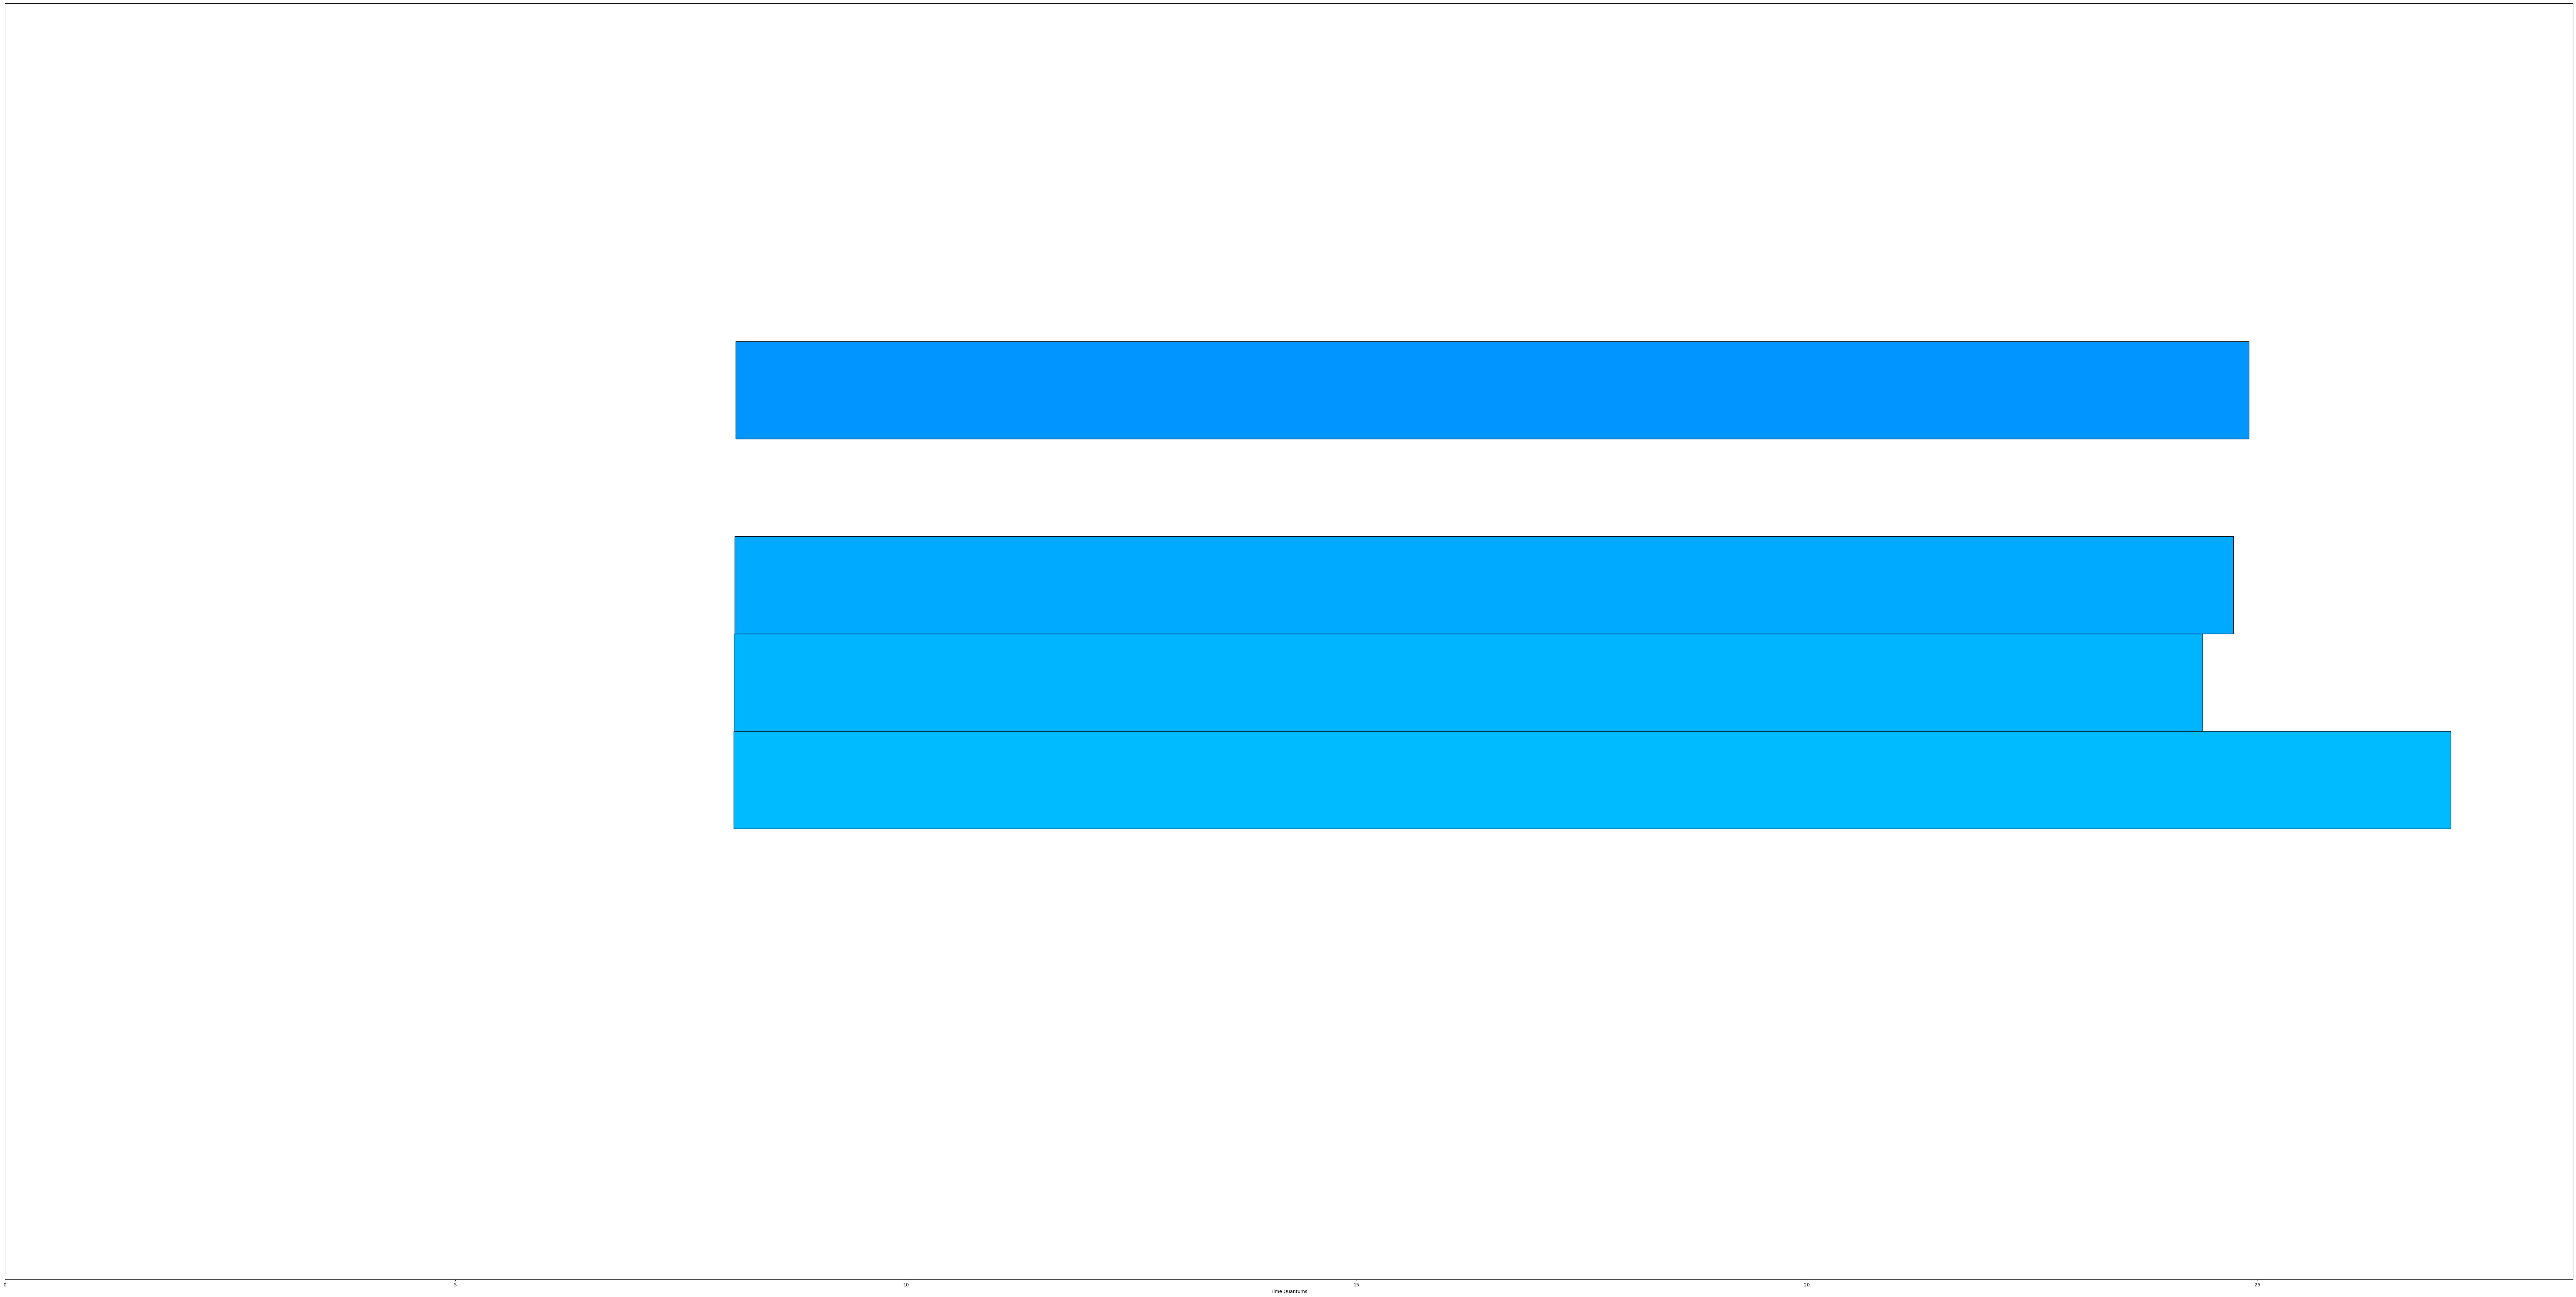

ljf-local


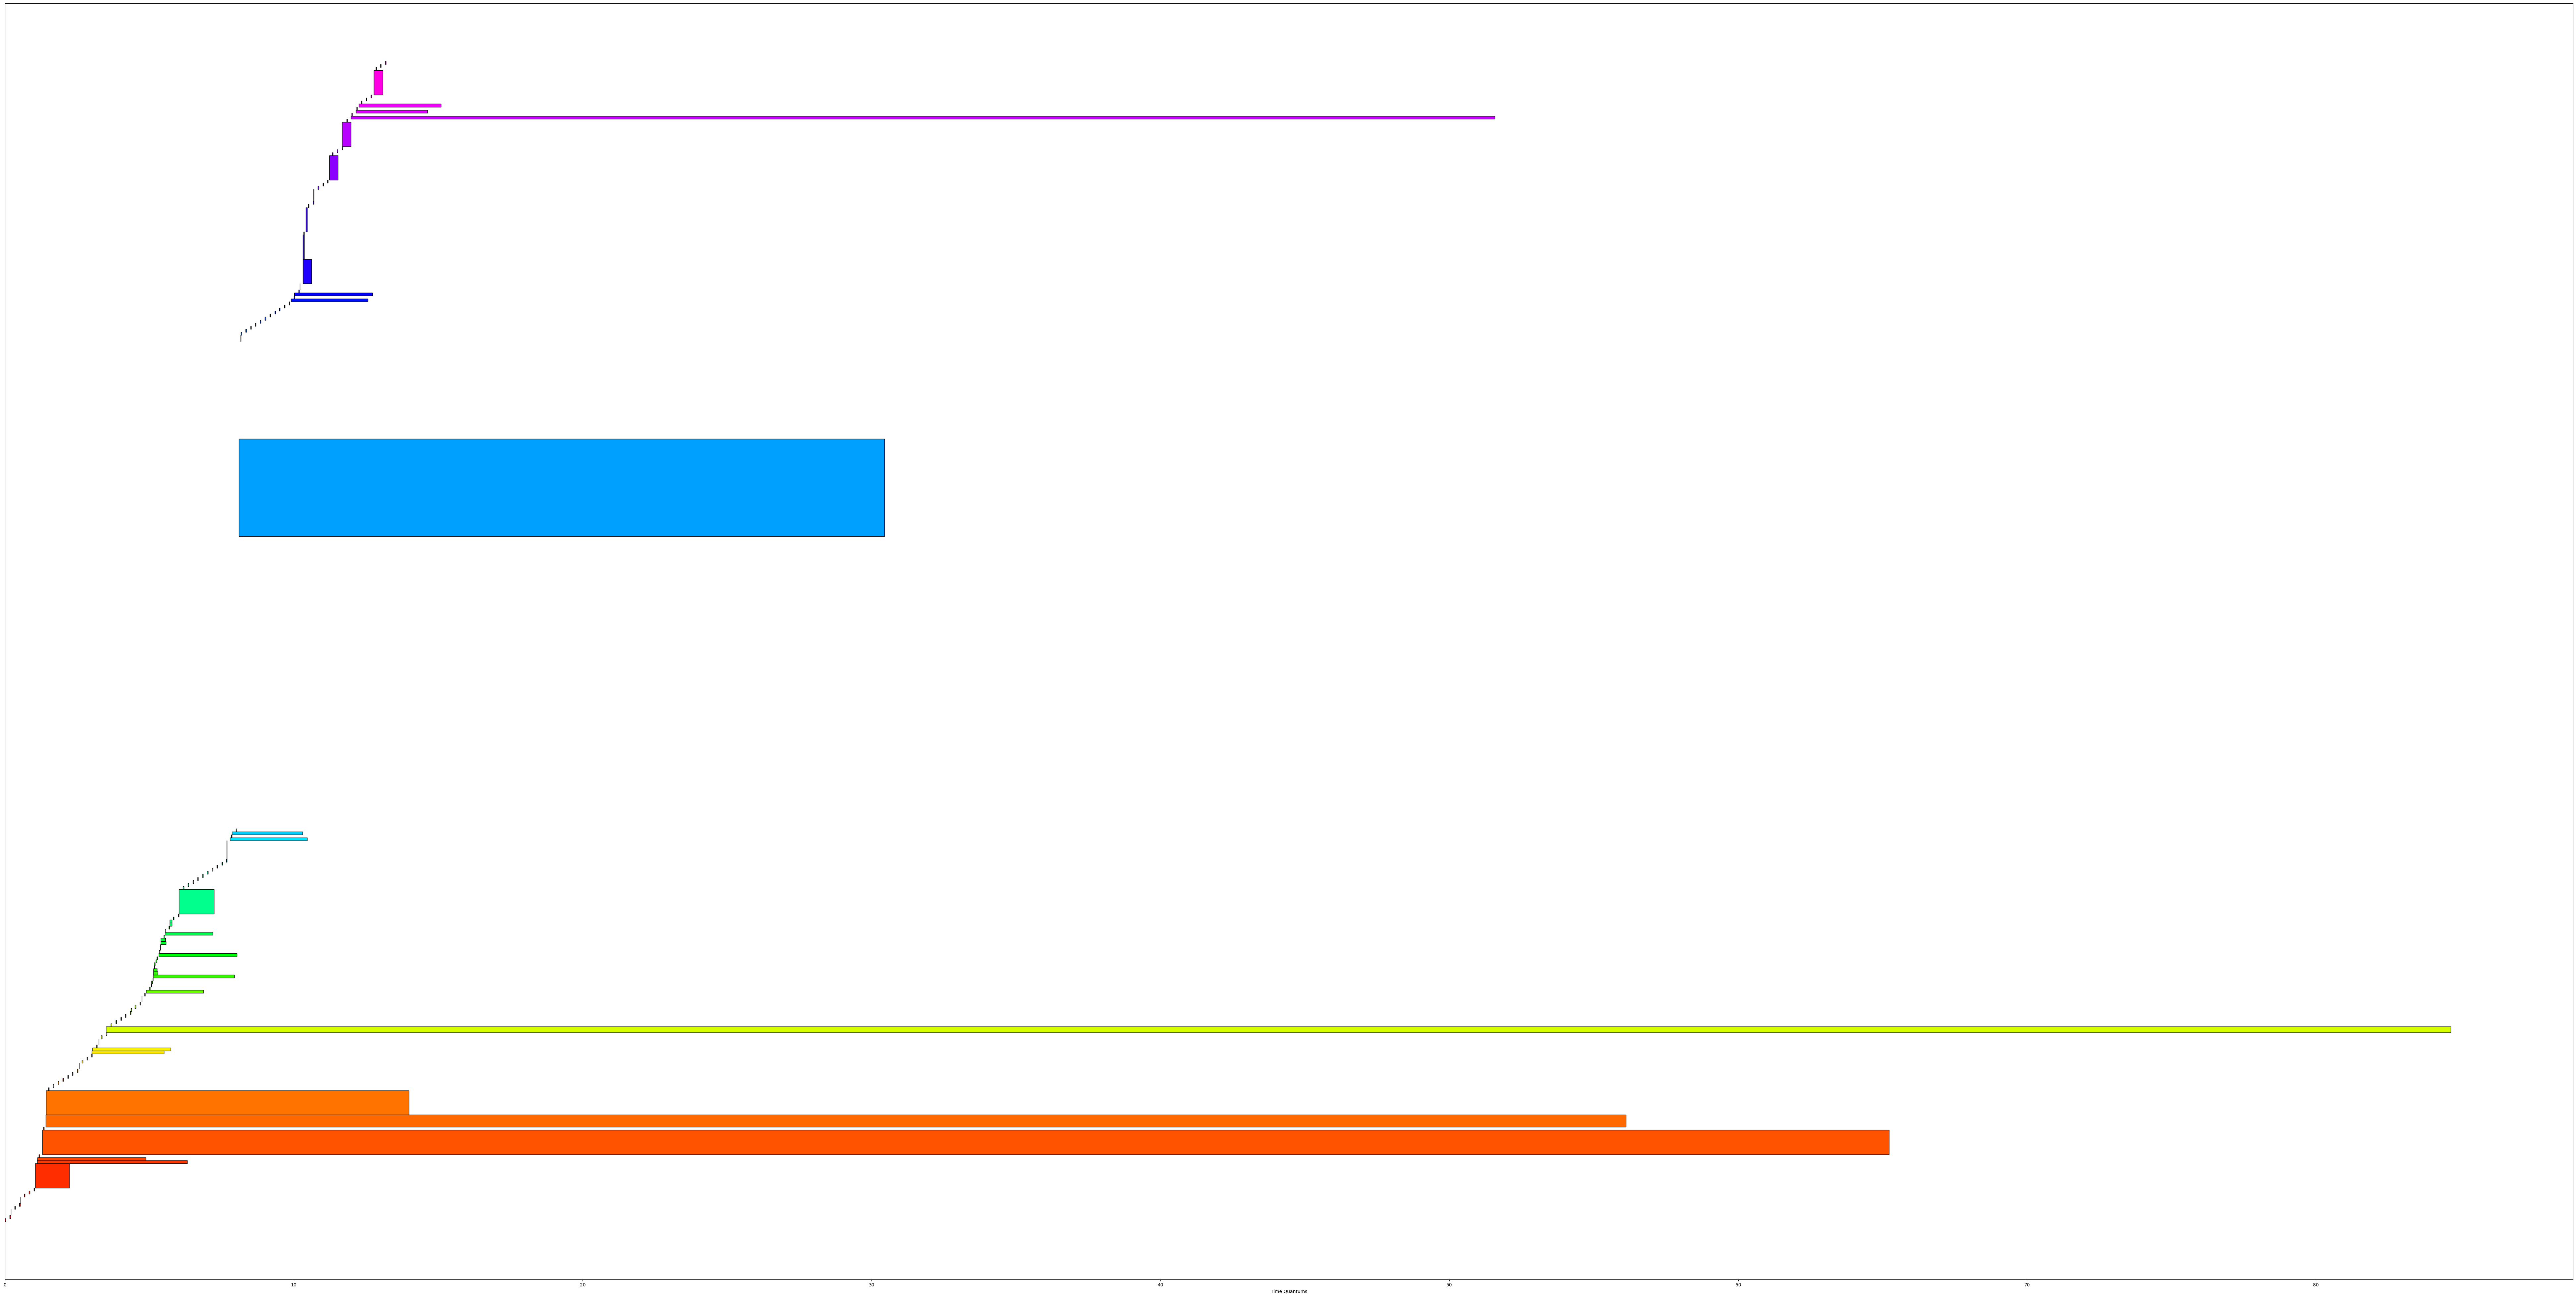

lvjf-cloud


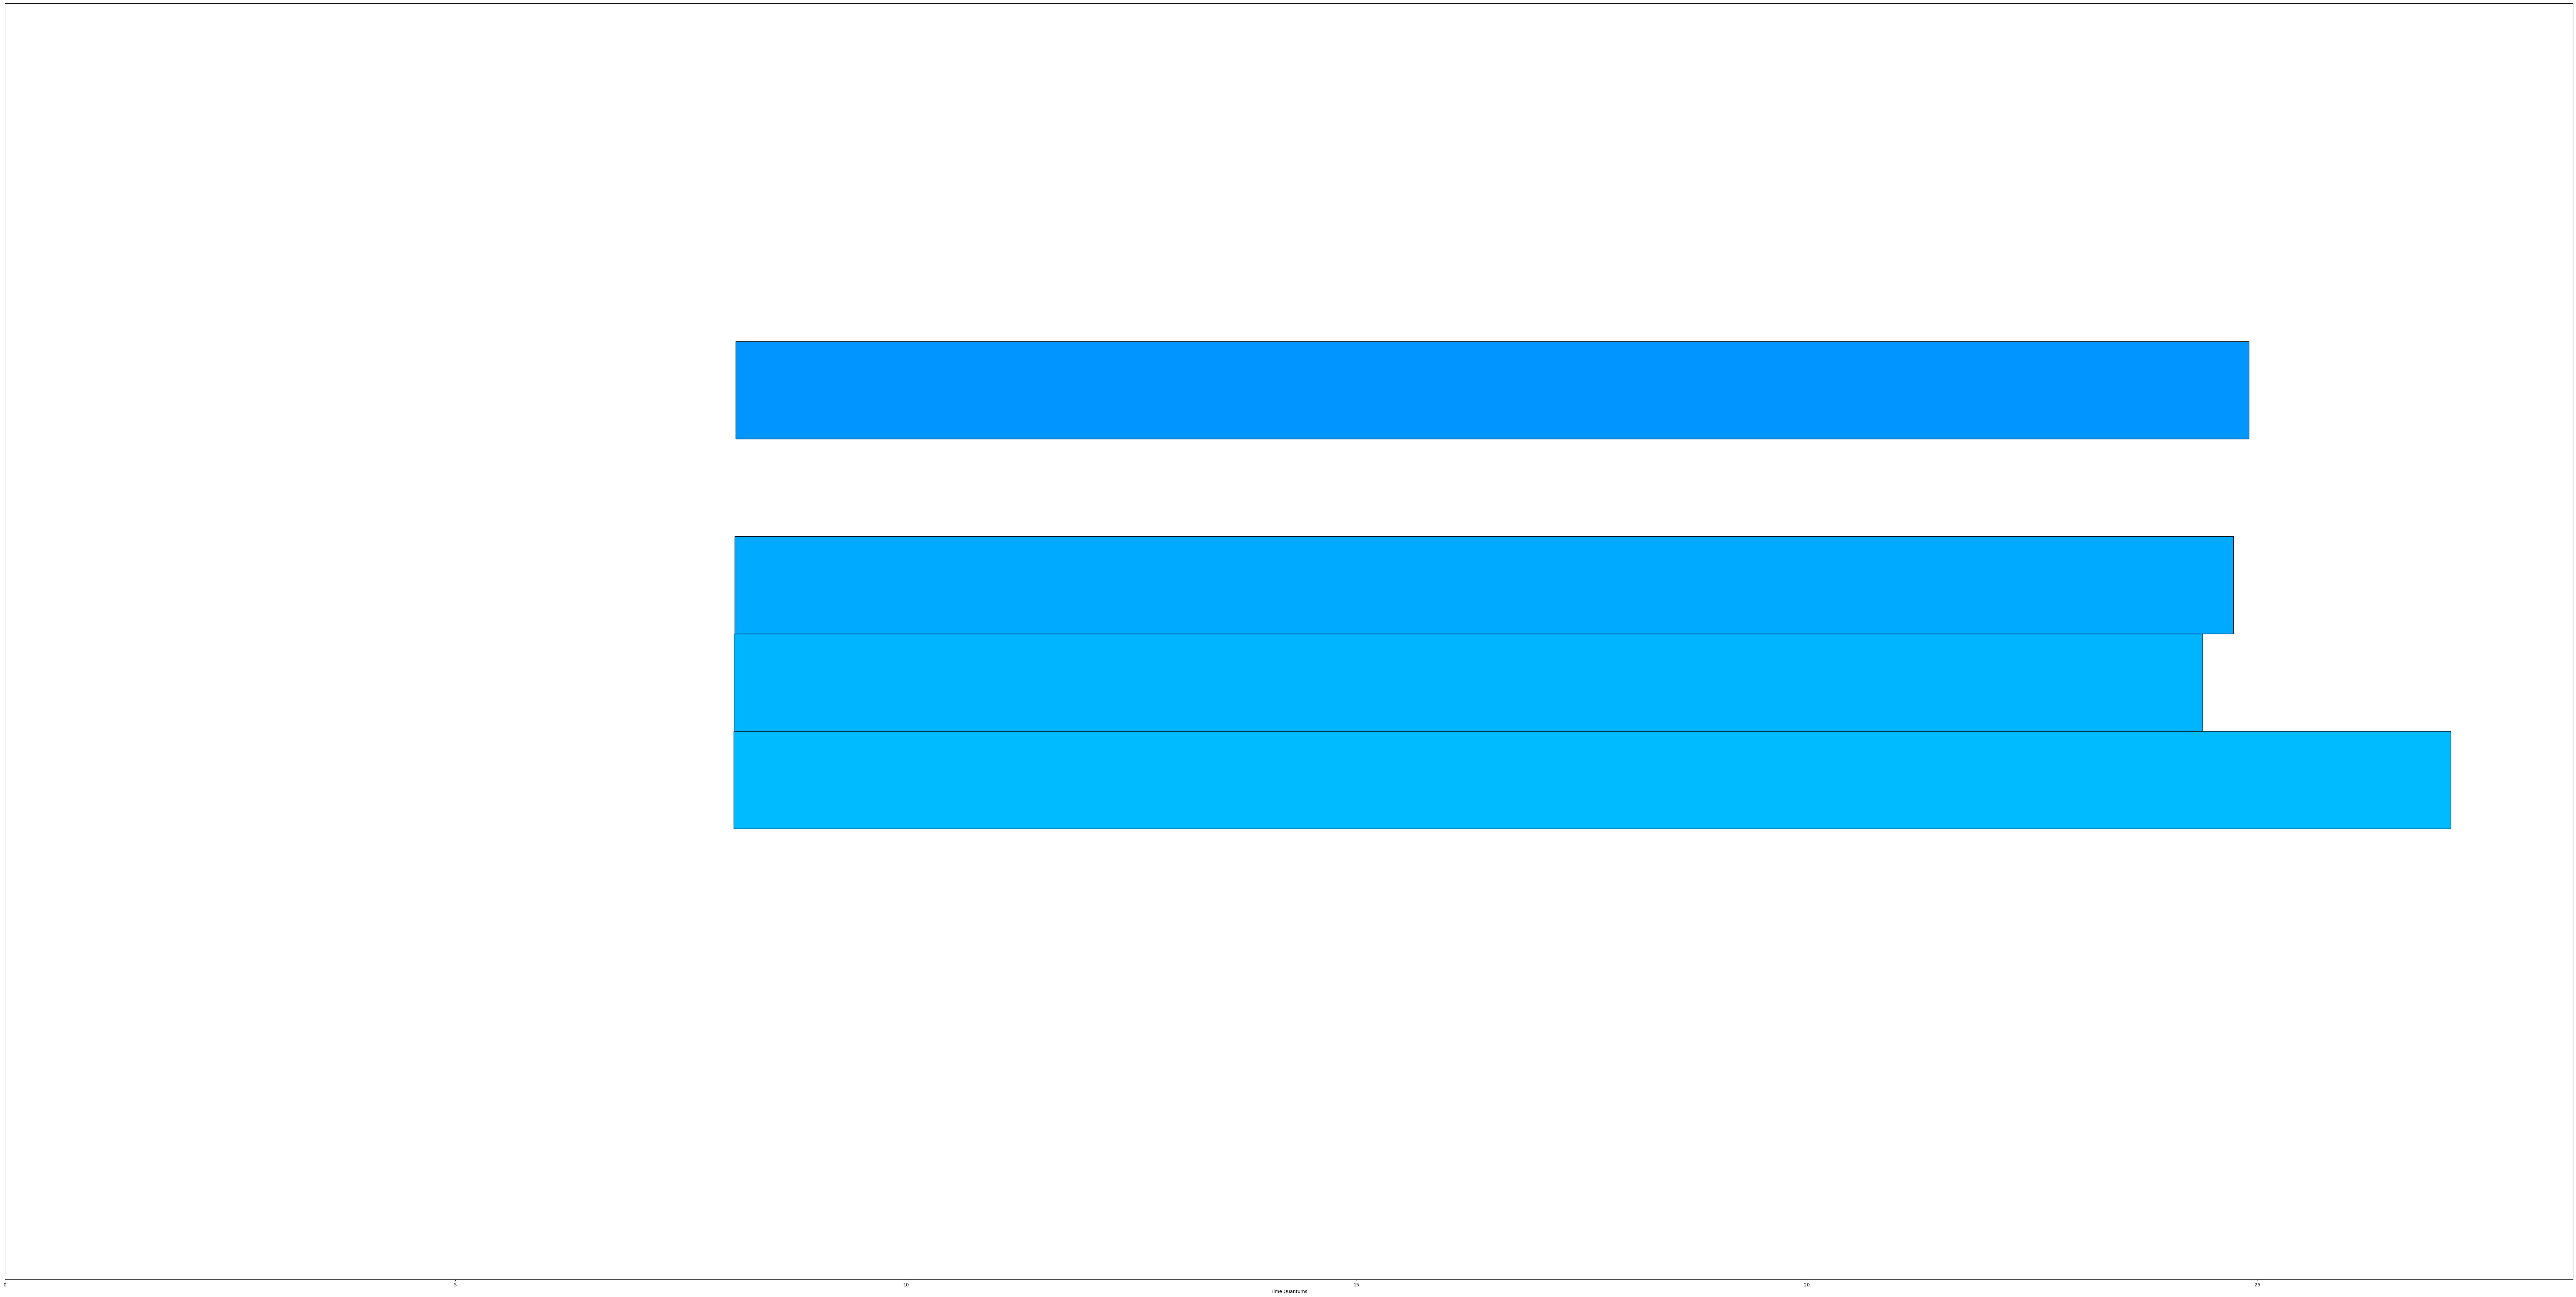

lvjf-local


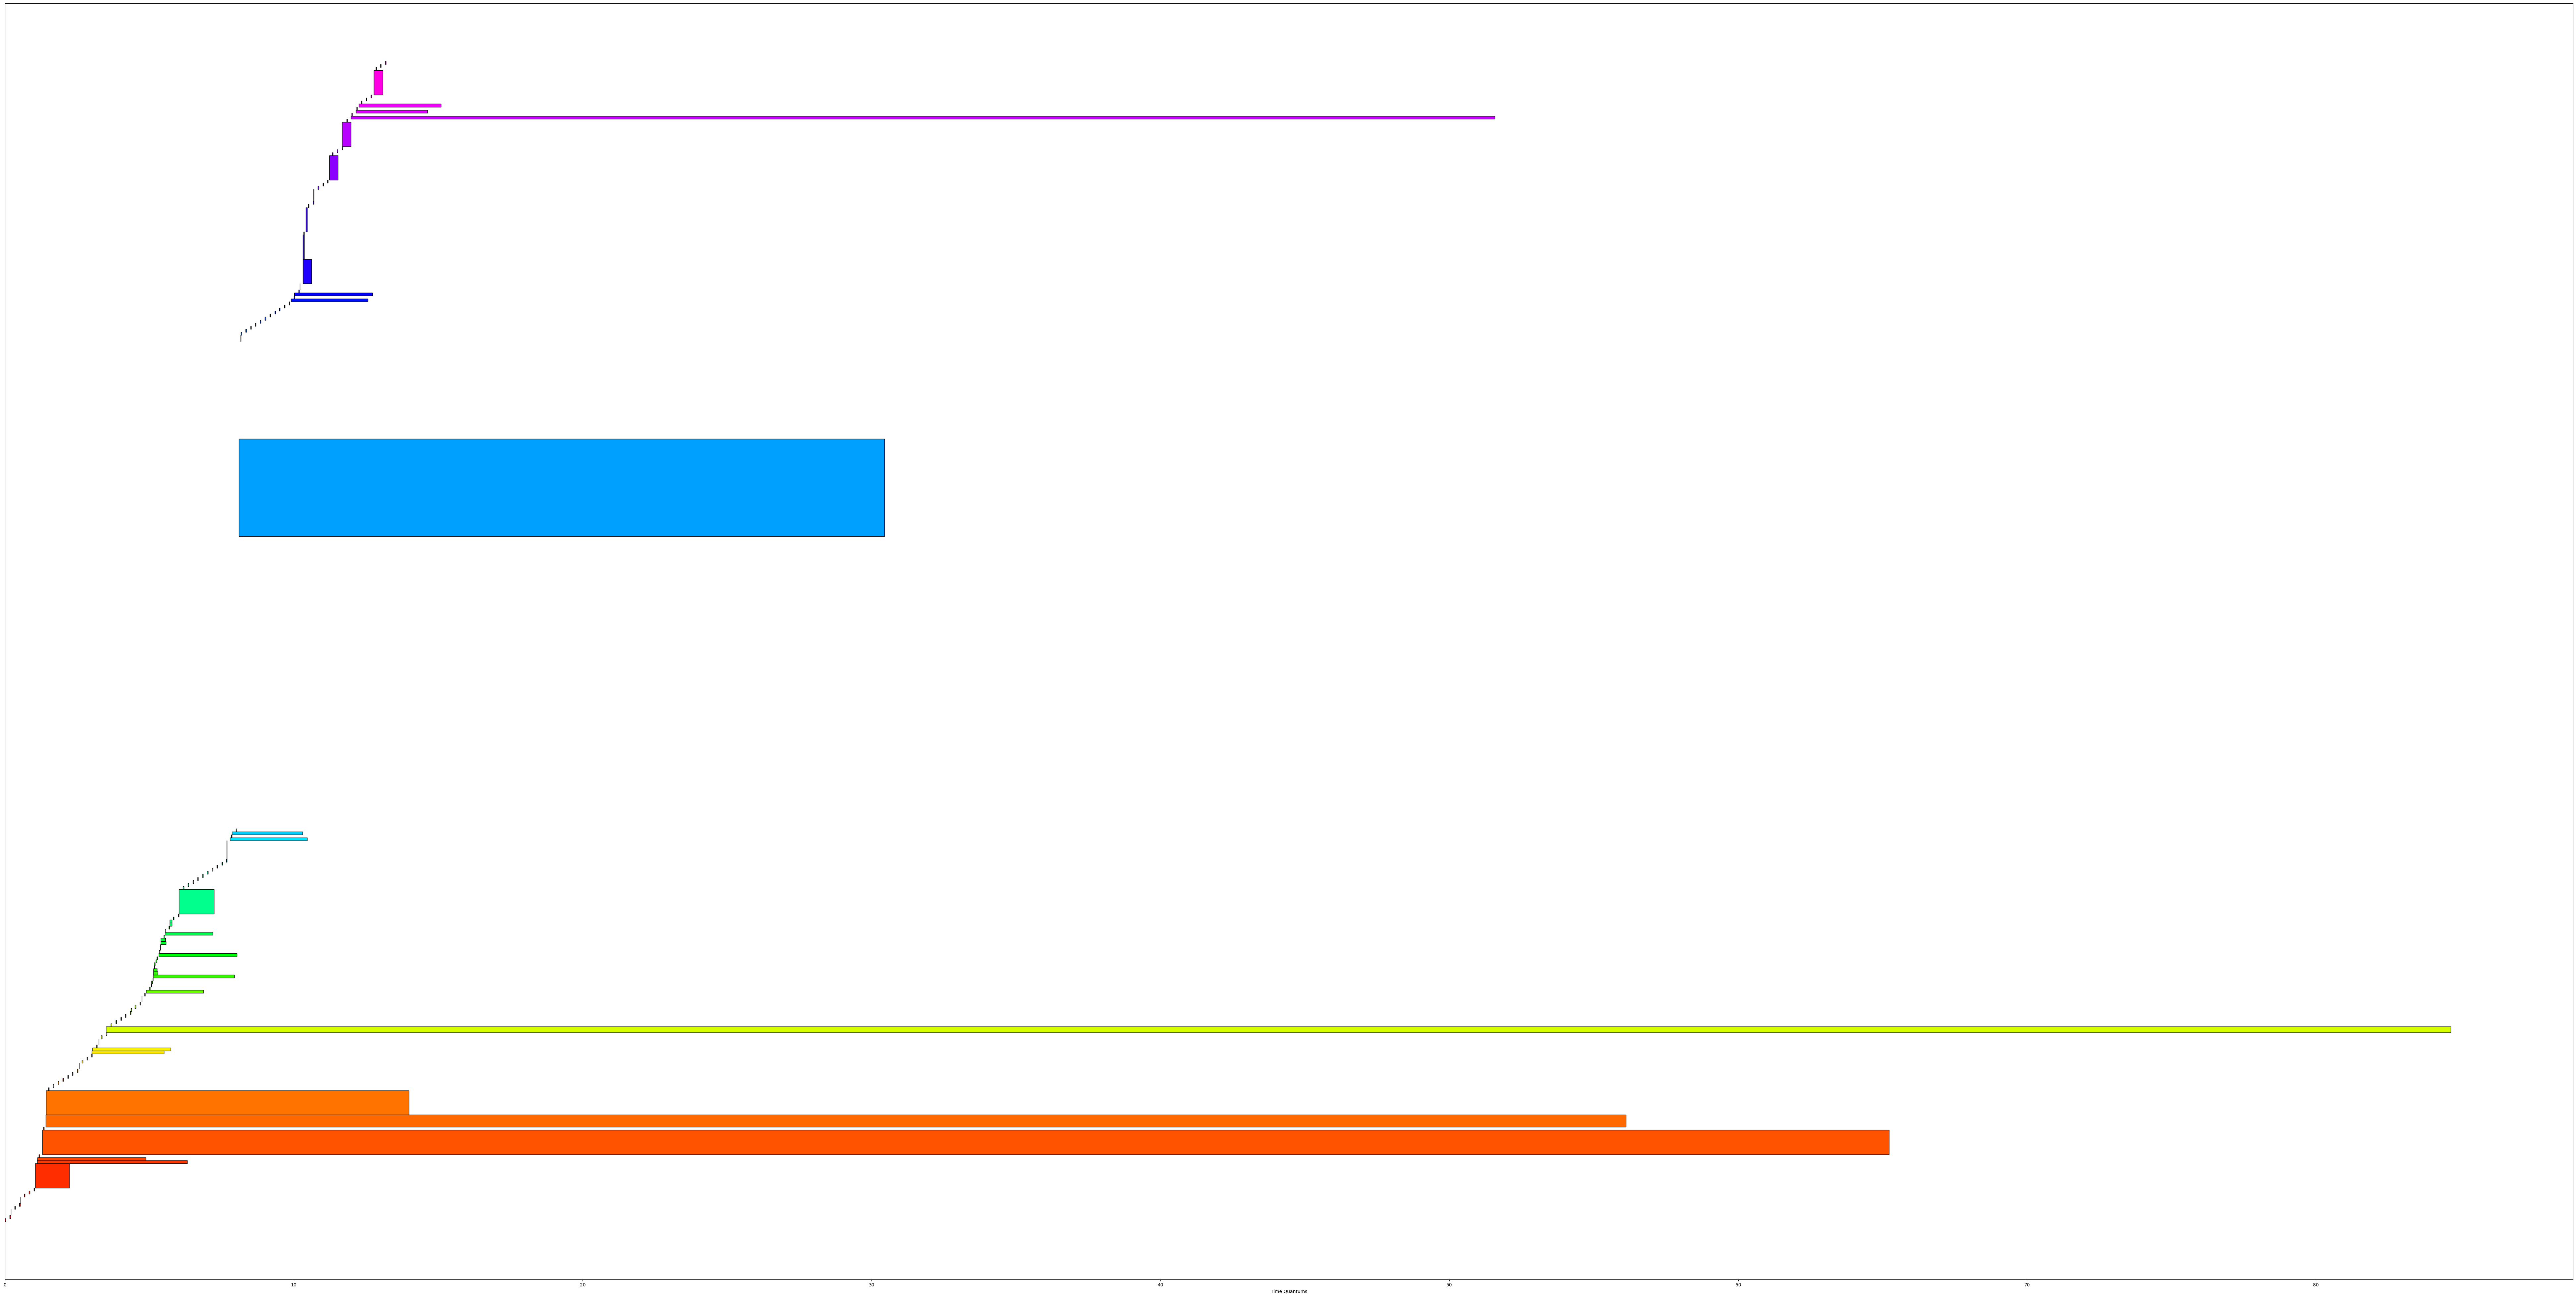

In [70]:
print('all')
plot_qjob_runtimes(results['fifo'][1], mode='all')
for alg in algs:
    for job_filter in ['cloud', 'local']:
        print(f'{alg}-{job_filter}')
        plot_qjob_runtimes(results[alg][1], mode=job_filter)

In [19]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def quantized_gpu_traces(jobs: List[Job], num_nodes=NUM_NODES):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs)+5
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    jobs.sort(key=lambda x: x.idx)
    fig, ax = plt.subplots(figsize=(100,50))
    total_gpus = num_nodes * GPUS_PER_NODE
    for j_idx, job in enumerate(jobs):
        allocated_gpus = job.allocated_gpus
        if not allocated_gpus:
            continue
        for node_idx in allocated_gpus.keys():
            for node_gpu_idx in allocated_gpus[node_idx]:
                gpu_idx = total_gpus - (GPUS_PER_NODE * node_idx + node_gpu_idx)
#                 print(job.idx)
#                 print(len(colors))
                ax.barh(gpu_idx,
                        width=job.runtime,
                        edgecolor='black',
                        height=1.0,
                        left=job.start,
                        align='edge',
                        color=colors[job.idx])
    import math
    for i in range(total_gpus+1):
        multiplier = math.ceil(num_nodes/32)
        if (i+1)%GPUS_PER_NODE==1:
            plt.axhline(y=i+1,linewidth=8/multiplier, color='brown')
        else:
            plt.axhline(y=i+1,linewidth=1/multiplier, color='black', linestyle='--')
    plt.ylim(bottom=1, top=total_gpus+1)
    plt.xlim(right=1.5*max([j.arrival for j in jobs]))
    plt.axvline(x=max([j.arrival for j in jobs]), color='black', linewidth=5)
    plt.tight_layout()
    plt.show()

In [54]:
def milp_solver_v3(jobs: List[Job]):
    import cvxpy
    import numpy as np
    bin_width = GPUS_PER_NODE
    bin_height = 1e6
    num_jobs = len(jobs)
    arrivals = np.array([j.arrival for j in jobs])
    runtimes = np.array([j.runtime for j in jobs])
    deadlines = np.array([j.deadline for j in jobs])
    num_gpus = []
    num_nodes = []
    costs = []
    for j in jobs:
        gpus = j.num_gpus
        if gpus > bin_width:
            assert gpus % bin_width == 0
            num_nodes.append(int(gpus/bin_width))
            num_gpus.append(bin_width)
            costs.append(j.cost/int(gpus/bin_width))
        else:
            num_nodes.append(1)
            num_gpus.append(gpus)
            costs.append(j.cost)
    
    num_gpus = np.array(num_gpus)
    num_nodes = np.array(num_nodes)
    costs = np.array(costs).reshape((num_jobs, 1))
    
    
    
    left = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    bottom = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    selection =  cvxpy.Variable((NUM_NODES, num_jobs), boolean=True)
    x_w = cvxpy.Variable((num_jobs,), integer=True)
    y_h = cvxpy.Variable((num_jobs,))
    all_or_nothing = cvxpy.Variable((num_jobs,), boolean=True)
    
    constraints = []
    
    # Restriction on X,Y coordinates
    constraints.append(x_w >= 0)
    constraints.append(x_w <= bin_width - num_gpus)
    constraints.append(y_h >= arrivals)
    constraints.append(y_h <=deadlines - runtimes)
    
    # Restriction on selection
    constraints.append(cvxpy.sum(selection, axis=0) == cvxpy.multiply(num_nodes, all_or_nothing))
    
    # Restriction on Boxes not intersecting
    triangle_filter = 100*np.triu(np.ones((num_jobs, num_jobs)))
    var_filter = triangle_filter + left + left.T + bottom + bottom.T 

    # Add constraints for each node boxes
    for n_idx in range(NUM_NODES):
        row = selection[n_idx]
        outer_sum = cvxpy.reshape(row, (num_jobs, 1)) + cvxpy.reshape(row, (1, num_jobs))
        constraints.append(var_filter + (2 - outer_sum) >=1)

    eq_1 = cvxpy.reshape(x_w + num_gpus, (num_jobs, 1)) - cvxpy.reshape(x_w, (1, num_jobs)) + bin_width * left <= bin_width 
    eq_2 = cvxpy.reshape(y_h + runtimes, (num_jobs, 1)) - cvxpy.reshape(y_h, (1, num_jobs)) + bin_height * bottom <= bin_height
    constraints.append(eq_1)
    constraints.append(eq_2)
    # Our total utility is the sum of the item utilities
    total_utility = cvxpy.sum(selection@costs)

    super_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), constraints)

    # Solving the problem
    opts = {'limits/time' : 120} #, 'parallel/minnthreads': 8, 'parallel/maxnthreads': 32} #{'maxiters' : 5000}
    super_problem.solve(solver=cvxpy.SCIP, verbose=True, scip_params = opts)

    # Restriction on intersections
    return (left, bottom, selection, x_w, y_h, all_or_nothing)

variables  = milp_solver_v3(jobs_proc)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 22 08:18:43 AM: Your problem has 20900 variables, 13 constraints, and 0 parameters.
(CVXPY) Feb 22 08:18:43 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 22 08:18:43 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 22 08:18:43 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 22 08:18:43 AM: Compiling problem (target solver=SCIP).
(CVXPY) Feb 22 08:18:43 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> 

 unknown
  7.4s|   100 |    87 | 39222 | 379.5 |   219M |  25 |2033 |5863 |5818 | 226 |  0 | 121 |  19 |-2.152976e+03 |-1.970250e+03 |   9.27%| unknown
  8.3s|   200 |   110 | 41923 | 202.4 |   227M |  31 |2033 |5950 |5813 | 228 |  1 | 211 |  19 |-2.152976e+03 |-1.970250e+03 |   9.27%| unknown
L 8.8s|   240 |   116 | 42401 | 170.5 |    rins|  31 |2033 |5953 |5821 | 238 |  1 | 218 |  19 |-2.152976e+03 |-1.978851e+03 |   8.80%| unknown
  9.5s|   300 |   160 | 47932 | 154.8 |   228M |  31 |2033 |5983 |5822 | 253 |  1 | 249 |  19 |-2.152976e+03 |-1.978851e+03 |   8.80%| unknown
 10.9s|   400 |   218 | 52393 | 127.2 |   229M |  31 |2033 |6015 |5826 | 310 |  2 | 297 |  19 |-2.152976e+03 |-1.978851e+03 |   8.80%| unknown
 13.1s|   500 |   302 | 57005 | 110.9 |   231M |  31 |2033 |6044 |5823 | 422 |  1 | 348 |  19 |-2.152976e+03 |-1.978851e+03 |   8.80%| unknown
 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   

/opt/conda/envs/sky/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-2.152976e+03 |-1.979602e+03 |   8.76%| unknown
 42.8s|   500 |   234 |161876 |  44.4 |   297M |  26 |2033 |7094 |5742 | 750 |  1 |2237 |  39 |-2.152976e+03 |-1.979602e+03 |   8.76%| unknown
 43.5s|   600 |   286 |163991 |  43.8 |   298M |  26 |2033 |7092 |5742 | 984 |  1 |2253 |  39 |-2.152976e+03 |-1.979602e+03 |   8.76%| unknown
 44.1s|   700 |   340 |166827 |  43.4 |   298M |  27 |2033 |7143 |5750 |1056 |  2 |2315 |  39 |-2.152976e+03 |-1.979602e+03 |   8.76%|   0.19%
 45.2s|   800 |   406 |173559 |  44.0 |   299M |  27 |2033 |7158 |5756 |1345 |  0 |2350 |  39 |-2.152976e+03 |-1.979602e+03 |   8.76%|   0.19%
 46.3s|   900 |   464 |180269 |  44.6 |   299M |  27 |2033 |7169 |5763 |1637 |  0 |2376 |  39 |-2.152976e+03 |-1.979602e+03 |   8.76%|   0.19%
 47.0s|  1000 |   538 |183750 |  44.3 |   299M |  32 |2033 |7171 |5768 |1746 |  1 |2396 |  39 |-2.152976e+03 |-1.979602e+03 |   8.76%|   0.19%
 47.4s|  1100 |   622 |184808 |  43.5 |   299M |  32 |2033 |7160 |5768 |1807 |  1 |2400 |  39 

0 + 2 + {2: [0, 1]}
1 + 2 + {5: [0, 1]}
2 + 1 + {5: [0]}
3 + 1 + {5: [0]}
4 + 1 + {5: [0]}
5 + 1 + {5: [0]}
6 + 1 + {5: [0]}
7 + 1 + {5: [0]}
8 + 1 + {5: [0]}
9 + 1 + {5: [0]}
10 + 1 + {5: [0]}
11 + 1 + {5: [0]}
12 + 1 + {5: [0]}
13 + 1 + {5: [0]}
14 + 1 + {5: [0]}
15 + 1 + {5: [0]}
16 + 1 + {5: [0]}
17 + 1 + {5: [0]}
18 + 1 + {5: [0]}
19 + 1 + {0: [1]}
20 + 1 + {1: [2]}
21 + 1 + {5: [0]}
22 + 1 + {5: [0]}
23 + 1 + {5: [0]}
24 + 2 + {5: [0, 1]}
25 + 1 + {5: [0]}
26 + 1 + {5: [0]}
27 + 1 + {0: [0]}
28 + 1 + {0: [0]}
29 + 1 + {0: [0]}
30 + 1 + {0: [0]}
31 + 1 + {0: [0]}
32 + 1 + {0: [0]}
33 + 4 + {2: [4, 5, 6, 7]}
34 + 4 + {5: [0, 1, 2, 3]}
36 + 4 + {5: [4, 5, 6, 7]}
37 + 1 + {0: [7]}
38 + 1 + {0: [7]}
39 + 1 + {0: [7]}
41 + 4 + {2: [0, 1, 2, 3]}
42 + 1 + {0: [7]}
43 + 1 + {0: [7]}
44 + 1 + {0: [7]}
45 + 1 + {0: [7]}
46 + 1 + {0: [7]}
47 + 1 + {0: [7]}
48 + 1 + {0: [7]}
49 + 1 + {0: [7]}
50 + 1 + {0: [6]}
51 + 1 + {0: [7]}
52 + 1 + {0: [6]}
53 + 1 + {0: [7]}
54 + 1 + {0: [7]}
55 + 1 + {0

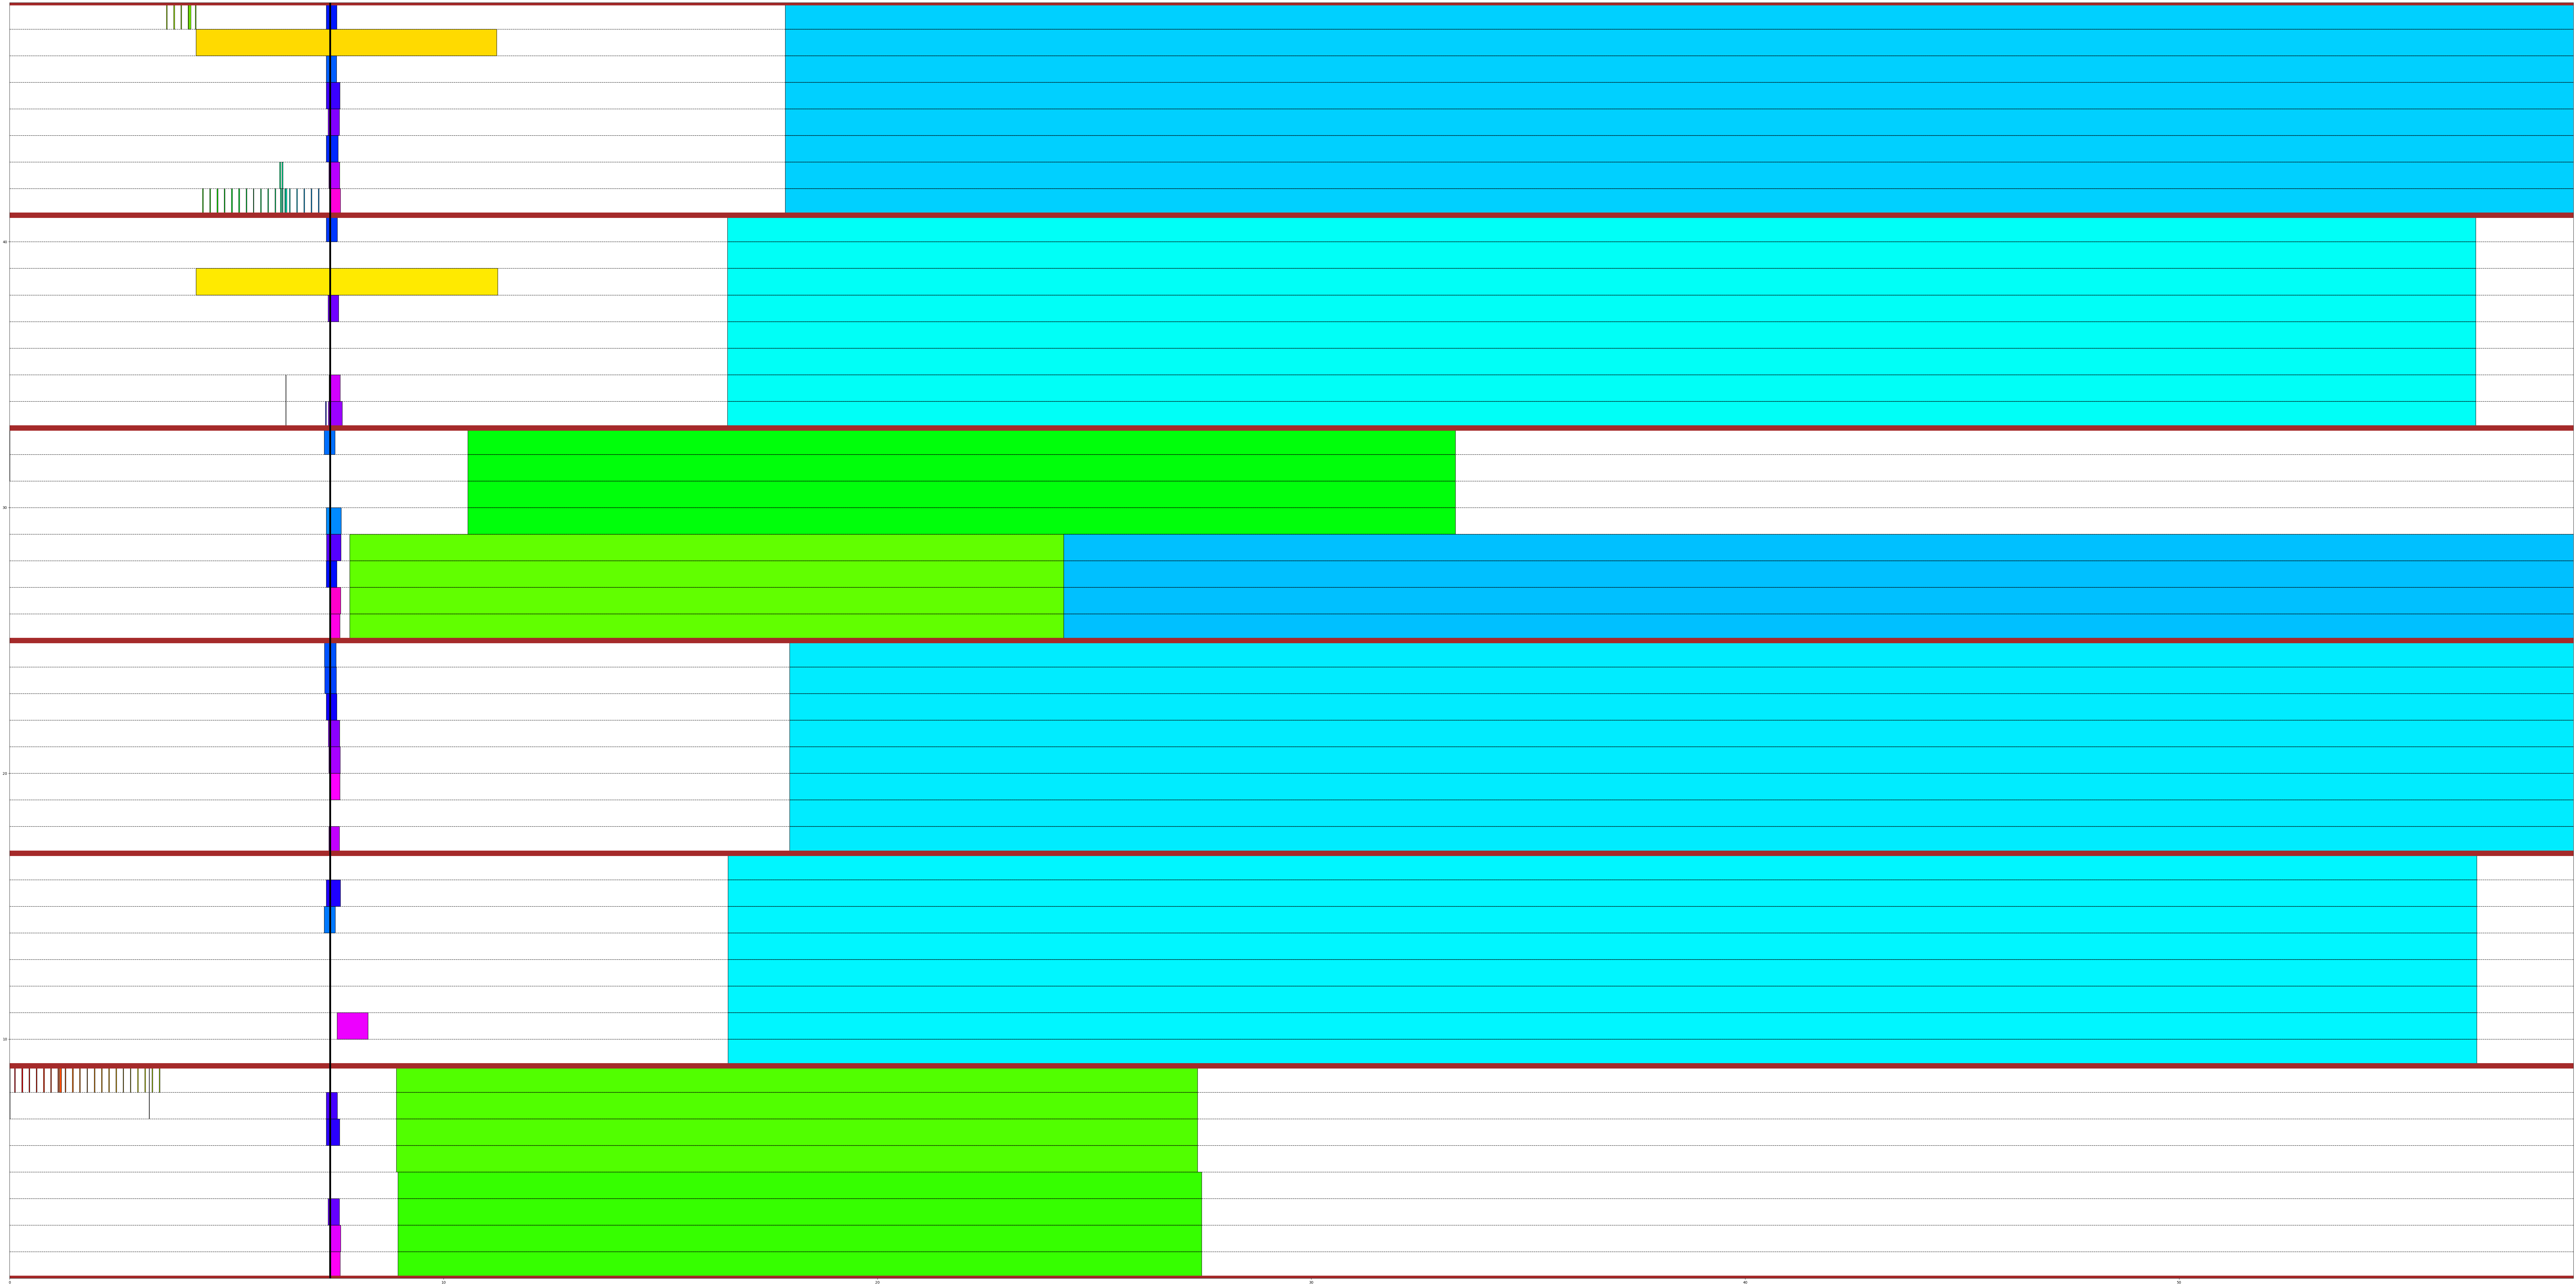

In [55]:
left, bottom, selection, x_w, y_h, all_or_nothing = variables

copy_jobs = copy.deepcopy(jobs_proc)
copy_jobs.sort(key=lambda x: x.idx)


gpu_values = selection.value
summed_values = np.sum(gpu_values, axis=0)
cloud_cost = 0
for j in copy_jobs:
    idx = j.idx
    if summed_values[idx]==0:
        cloud_cost += j.cost
        continue
    j.start = y_h.value[idx]
    #print(gpu_values[:,idx])
    for gpu_idx, gpu_v in enumerate(gpu_values[:,idx]):
        if gpu_v ==1:
            j.allocated_gpus[gpu_idx] = list(range(int(x_w.value[idx]), int(x_w.value[idx]) + j.num_gpus))    
    print(f'{idx} + {j.num_gpus} + {j.allocated_gpus}')
print(cloud_cost)
quantized_gpu_traces(copy_jobs)

MILP-local


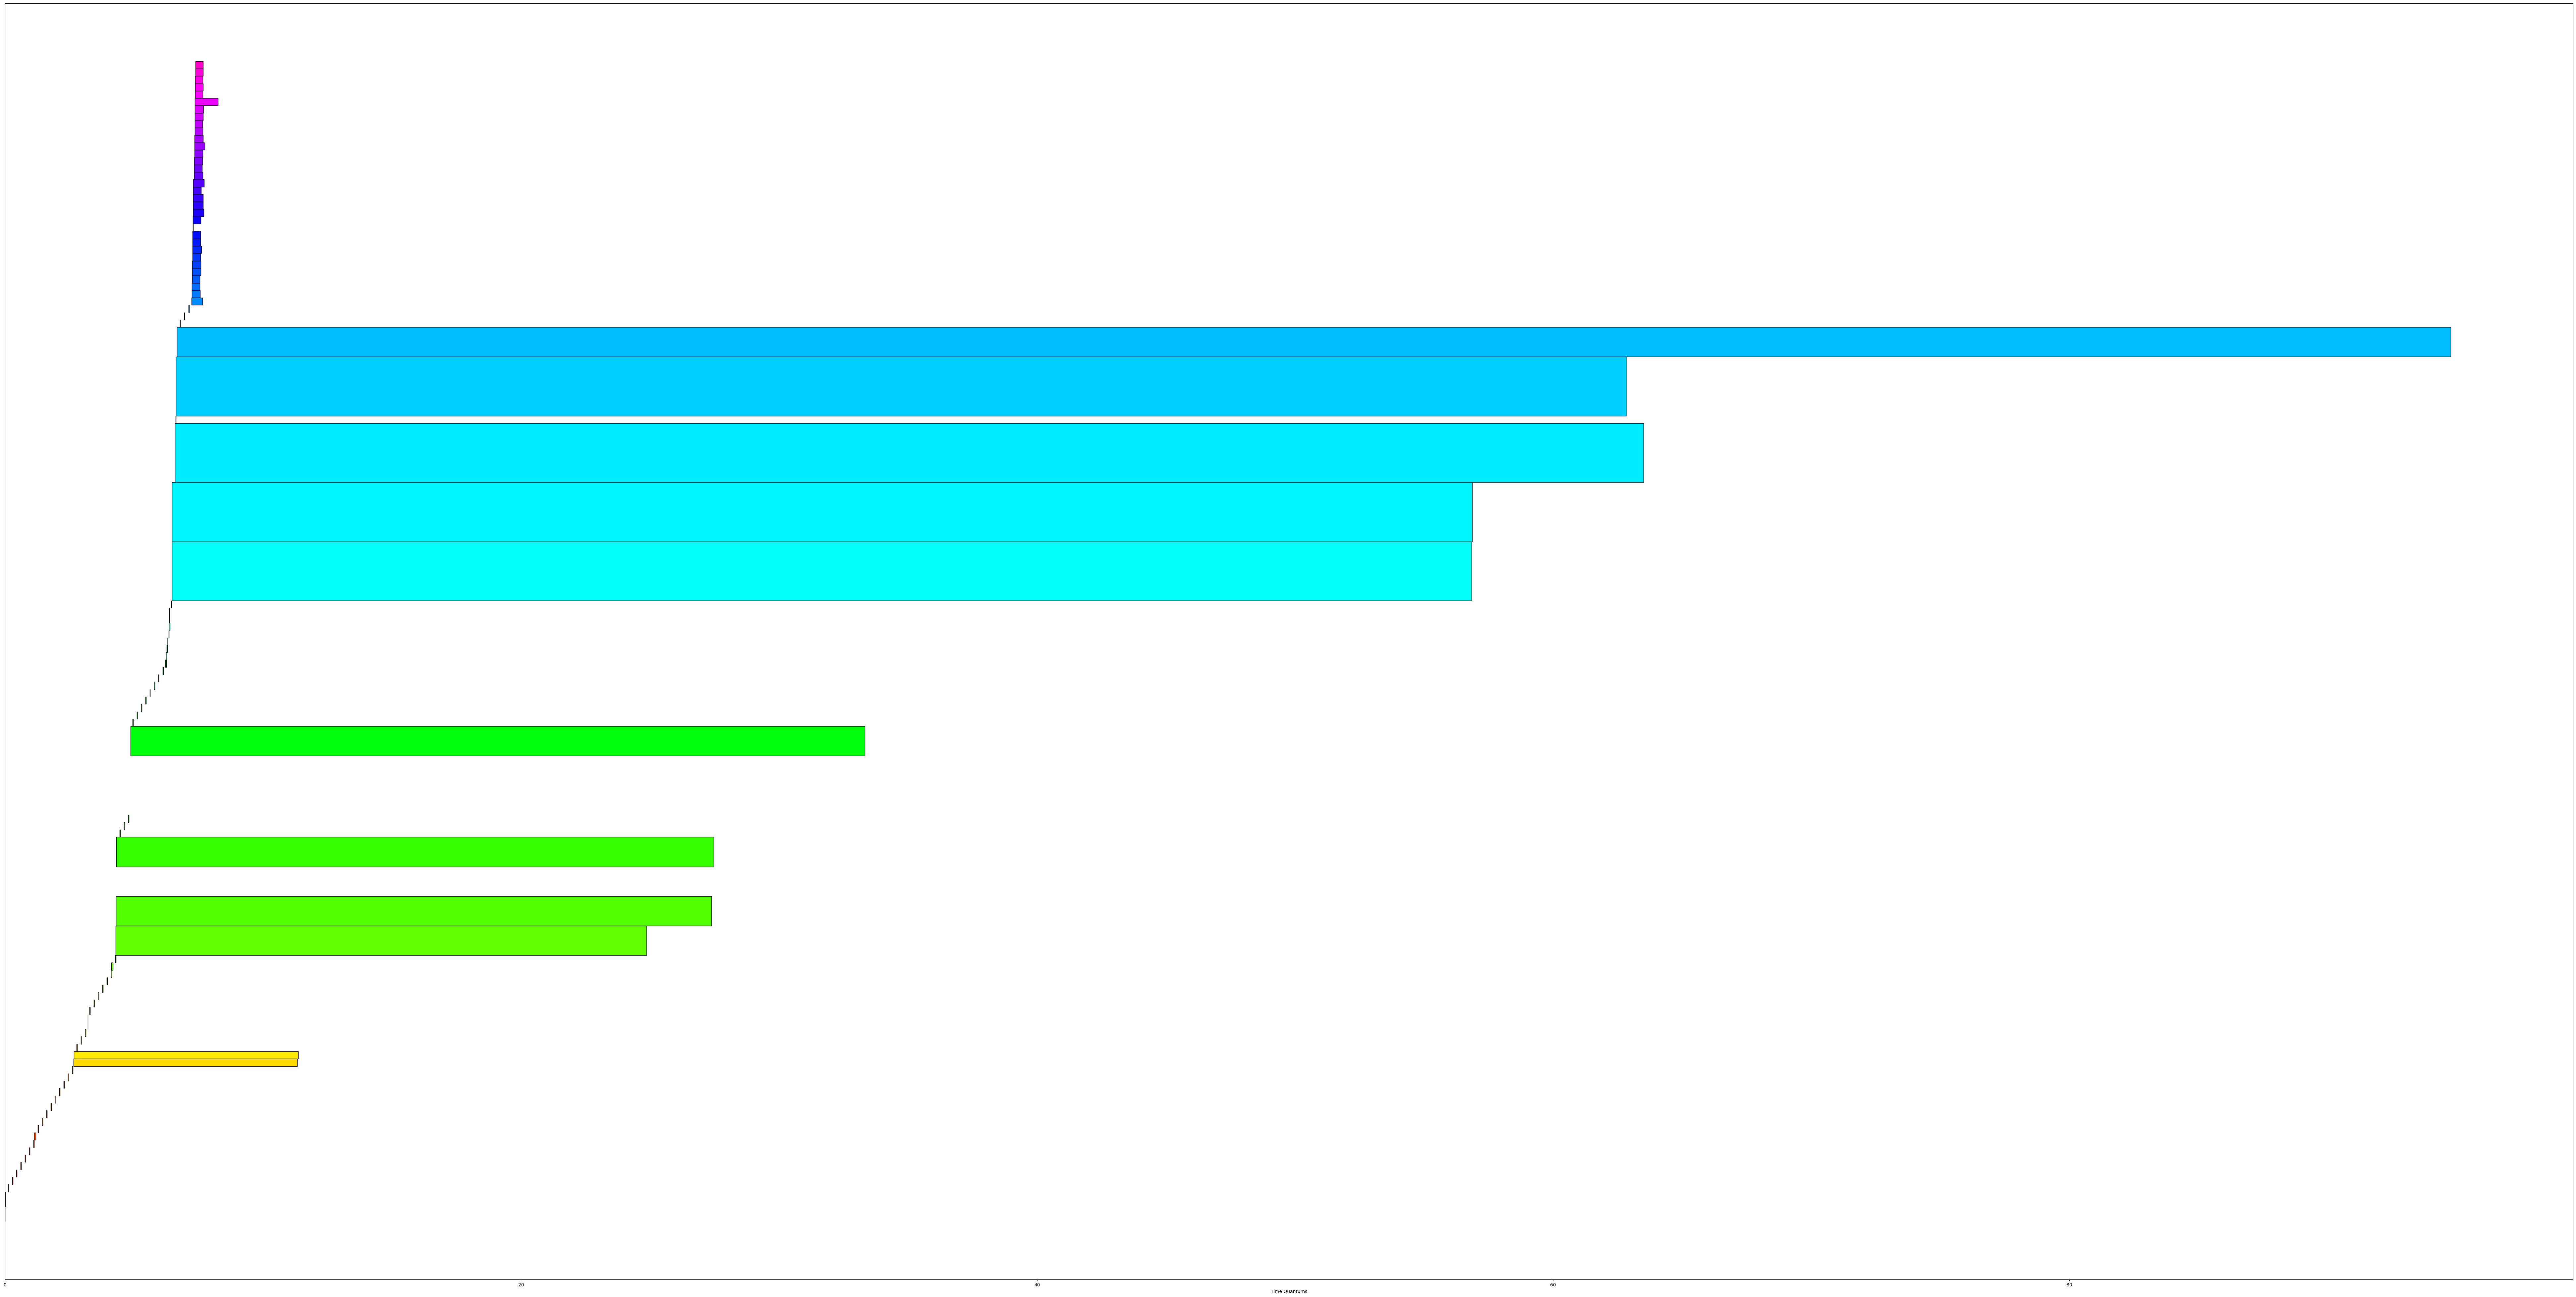

MILP-cloud


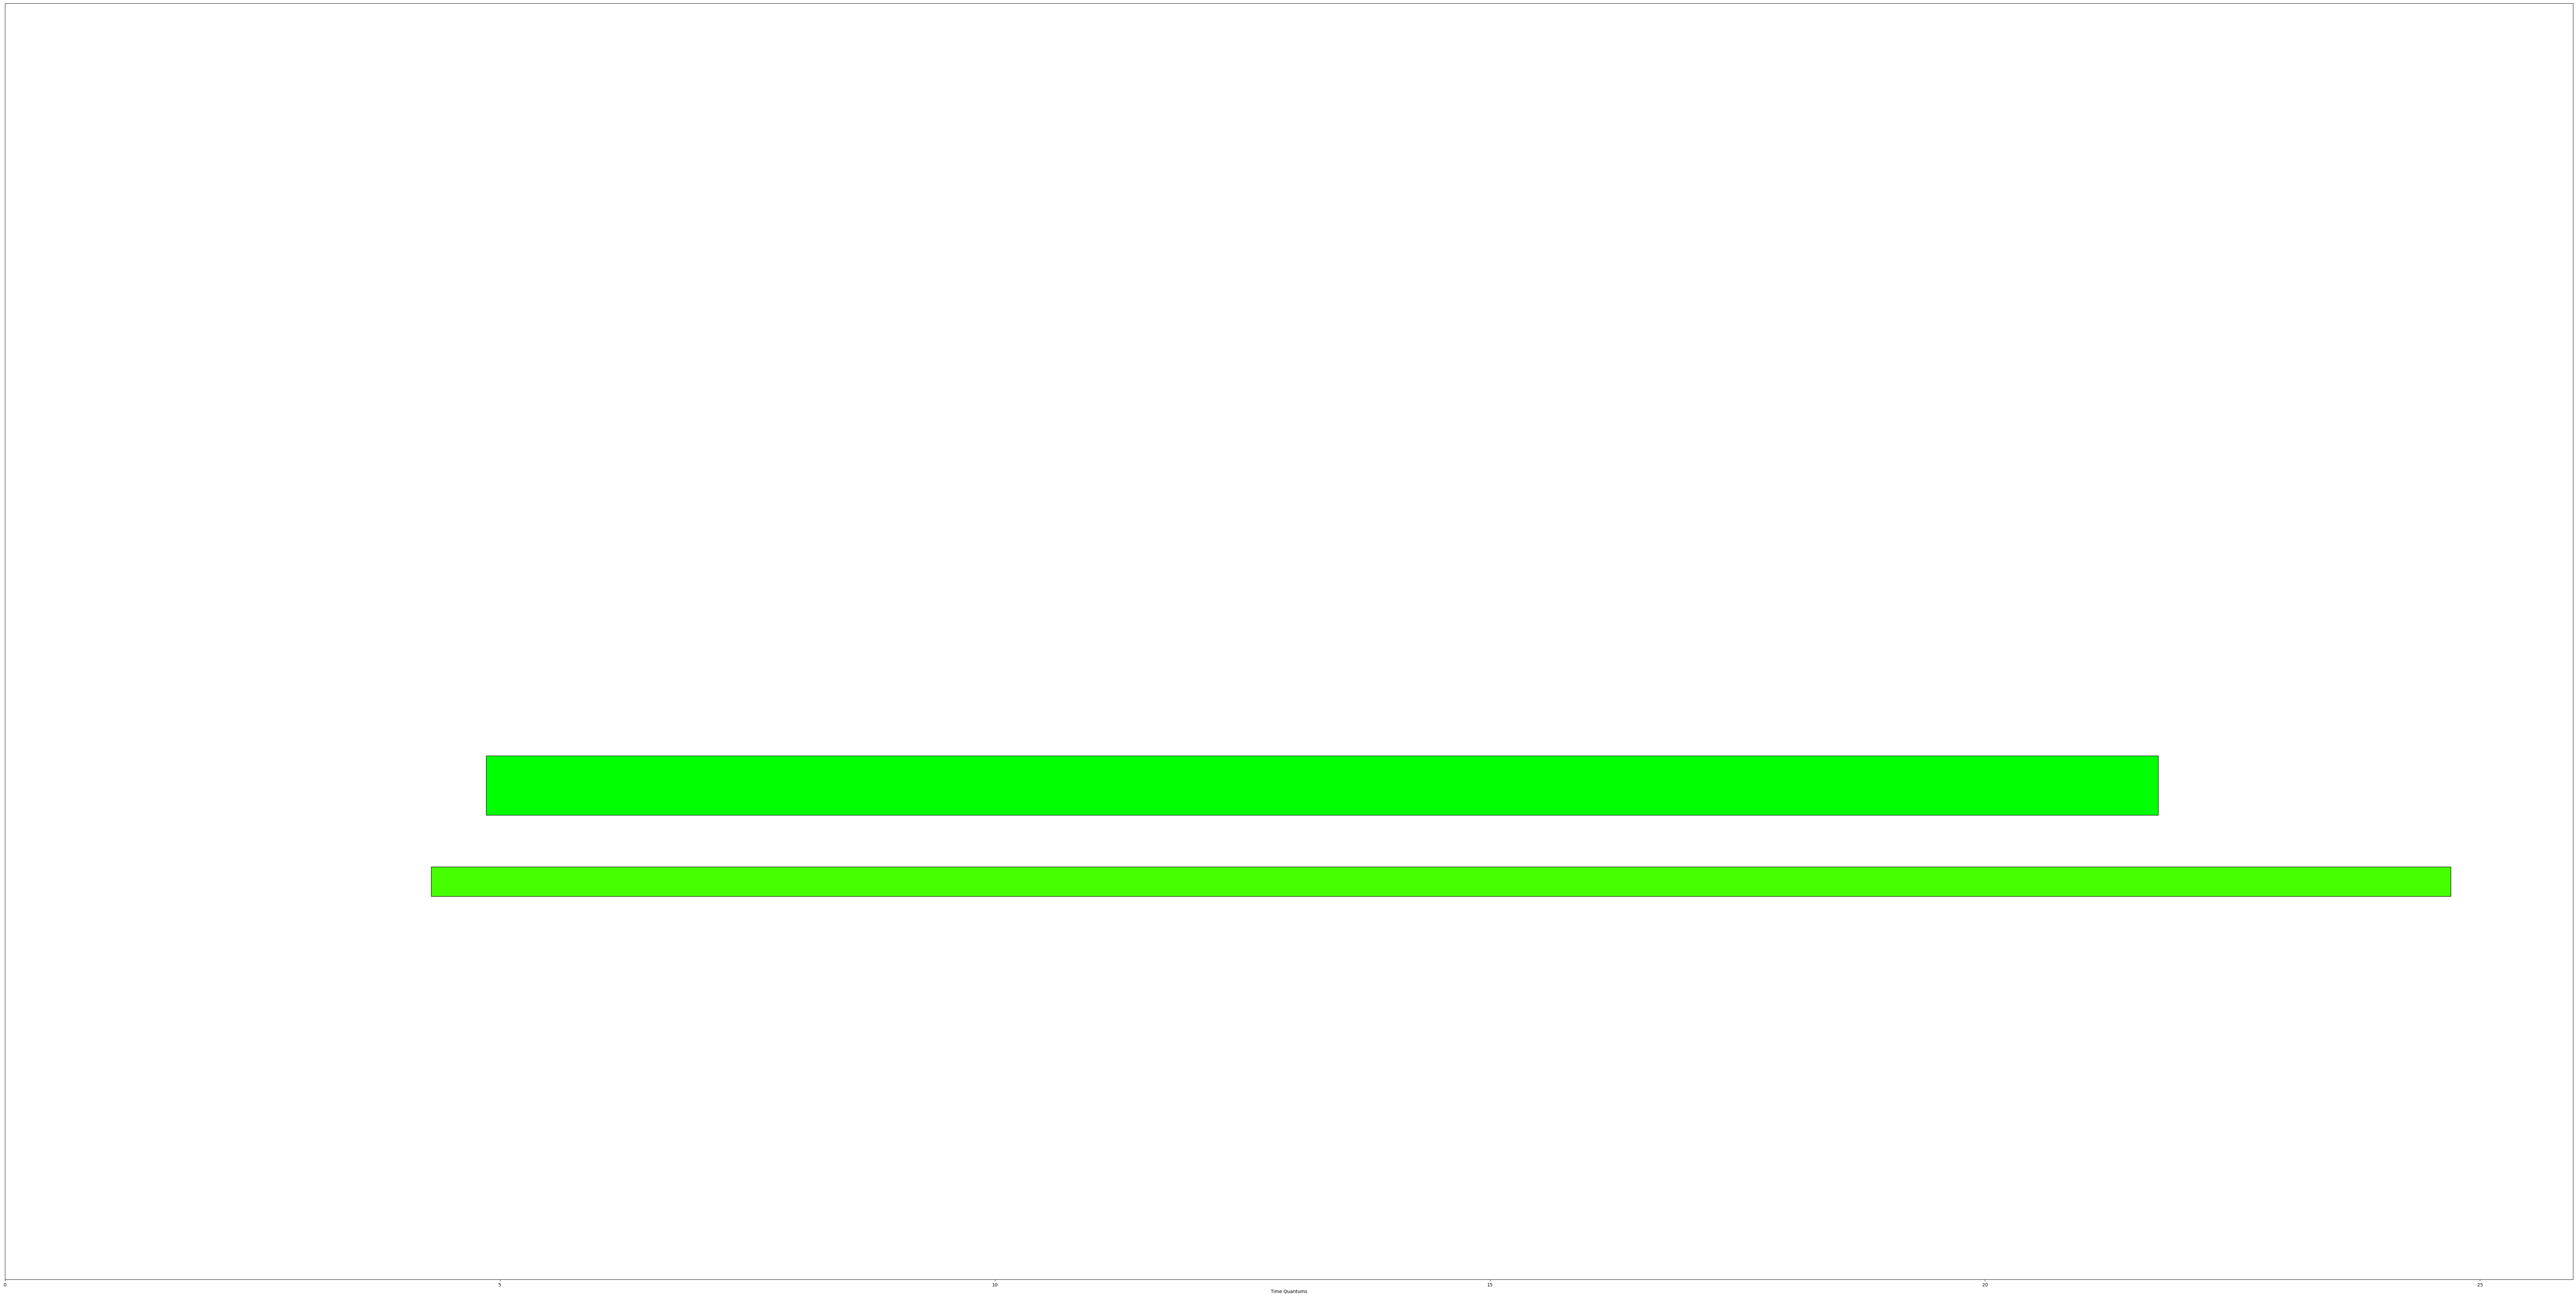

In [57]:
for job_filter in ['local', 'cloud']:
    print(f'MILP-{job_filter}')
    plot_qjob_runtimes(copy_jobs, mode=job_filter)

(0.0, 900000.0)

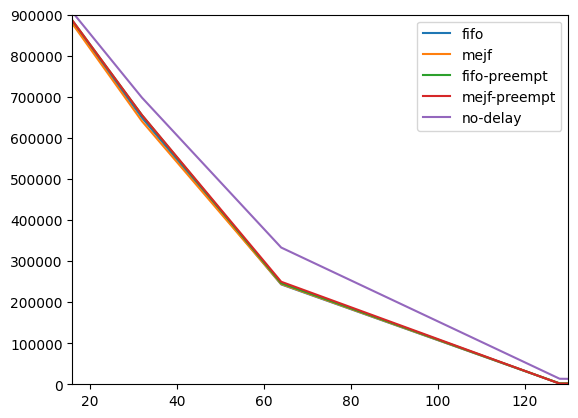

In [32]:
# importing package
import matplotlib.pyplot as plt
import pandas as pd

result_dict = {'fifo': [1077538.671, 1008040.84, 880702.1297222135, 
                        649006.4663888791, 243240.76222222525, 1920.9083333333326, 0, 0 ],
               'mejf': [1077880.7344444417, 1007618.9963888723, 878126.4544444343, 
                       640596.998333324, 244145.94694444753, 2076.698333333333, 0, 0],
               
               'fifo-preempt': [1080090.3283333292, 1011353.7508333167,
                               885838.918888875, 655320.2599999845,246081.49222222637, 1991.161111111113, 0, 0],
               
               'mejf-preempt': [1080090.3288888847, 1011381.1388888725, 886088.9491666529, 655578.8319444294, 
                               249681.00472222632, 1611.28, 0, 0],
               
               'no-delay': [1082489.9933333322, 1020699.5211111109, 906541.6291666661, 698012.485277777,
                           332983.46666666743, 13446.630833333307, 0, 0],
              }
num_nodes = [4,8,16,32,64,128, 256,512]
asdf = pd.DataFrame(data=result_dict, index=num_nodes)

ax = asdf.plot()
ax.set_xlim(16, 130)
ax.set_ylim(0, 900000)

In [ ]:
def create_results_df(simulator_results: dict):
    results_df = pd.DataFrame({'alg': pd.Series(dtype='str'),
                   'size': pd.Series(dtype='int'),
                   'cost': pd.Series(dtype='float'),
                   'waiting_time': pd.Series(dtype='float')})
    for key, finished_jobs in simulator_results.items():
        alg, num_nodes = key.split('-')
        num_nodes = int(num_nodes)
        cloud_cost = 0.0
        total_waiting_time = 0.0
        for j in finished_jobs:
            if j.start is None:
                cloud_cost += j.cost
                total_waiting_time += j.deadline - j.runtime - j.arrival
            else:
                total_waiting_time += j.start - j.arrival
        avg_waiting_time = total_waiting_time / len(finished_jobs)
        df = pd.DataFrame(data={'alg': [alg], 'size': [num_nodes], 'cost': [cloud_cost], 'waiting_time': [avg_waiting_time]})
        results_df = pd.concat([results_df, df], ignore_index=True)
    return results_df

def ajw_plot_waiting_cost_graph(results_df):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        grp.plot(x = 'size', y = 'cost',ax = ax, marker='^', label = label, xlabel='Cluster Resource(s)', \
                ylabel='Cloud Price')
        grp.plot(x = 'size', y = 'waiting_time', ax = ax2, marker='v', label = label, ylabel = 'Avg. Waiting Time', legend=None, style='--')
    ax.set_ylim(bottom=0.0)
    plt.title('Infinite Waiting Time')
    ax.grid(True, which='both')
    plt.show()
    
file = open('logs/ajw_philly.log', 'rb')
ajw_results = pickle.load(file)
ajw_results_df = create_results_df(ajw_results)
ajw_plot_waiting_cost_graph(ajw_results_df)


def njw_plot_waiting_cost_graph(results_df):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        grp.plot(x = 'size', y = 'cost',ax = ax, marker='^', label = label, xlabel='Cluster Resource(s)', \
                ylabel='Cloud Price')
        grp.plot(x = 'size', y = 'waiting_time', ax = ax2, marker='v', label = label, ylabel = 'Avg. Waiting Time', legend=None, style='--', ylim=(0, 10))
    ax.set_ylim(bottom=0.0)
    plt.title('No Waiting Time')
    ax.grid(True, which='both')
    plt.show()

file = open('logs/njw_philly.log', 'rb')
njw_results = pickle.load(file)
njw_results_df = create_results_df(njw_results)
njw_plot_waiting_cost_graph(njw_results_df)


def variable_plot_waiting_cost_graph(results_df, deadline=1.25):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        grp.plot(x = 'size', y = 'cost',ax = ax, marker='^', label = label, xlabel='Cluster Resource(s)', \
                ylabel='Cloud Price')
        grp.plot(x = 'size', y = 'waiting_time', ax = ax2, marker='v', label = label, ylabel = 'Avg. Waiting Time', legend=None, style='--')
    ax.set_ylim(bottom=0.0)
    plt.title(deadline)
    ax.grid(True, which='both')
    plt.show()

for ddl in [1.25, 1.5, 2, 5]:
    file = open(f'logs/vjw_philly_{ddl}.log', 'rb')
    hybrid_results = pickle.load(file)
    hybrid_results_df = create_results_df(hybrid_results)
    variable_plot_waiting_cost_graph(hybrid_results_df, deadline=ddl)
            
                
        